# IEEE-CIS Fraud Detection Dataset
https://www.kaggle.com/competitions/ieee-fraud-detection/overview



## About Dataset


Here we need to  predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.


The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### Transaction data 

* Transactionid: Id related to transaction
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD  [Categorical]: product code(the product for each transaction)
* card1 - 6 [Categorical]: payment card related information like card type, country etc
* addr1, addr2 [Categorical]: address information
* dist1,dist2: some distance information
* P_emaildomain [Categorical]: email domain of purchaser
* R_emaildomain [Categorical]: emaildomain of recipient
* C1-C14:  counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9 [Categorical]: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.



#### Identity data

* Transactionid: Id related to transaction
* DeviceType [Categorical]: Type of device used for transaction
* DeviceInfo [Categorical]: More information about device used
* id 1 - 38 [Categorical+numeric]: network connection information,browser information etc (id 12 - 38 are categorical information)

Note: Actually we dont have access to exact information about columns. Mostly it is beacuse of security purposes as we are handling transaction data.



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use("seaborn-v0_8-talk")
import warnings
warnings.simplefilter("ignore")
colors = [x["color"] for x in plt.rcParams["axes.prop_cycle"]]
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


#### Data Loading and Exploration

1. Getting the shape of trainig data

In [8]:
df_train_transaction = pd.read_csv('Data/train_transaction.csv')
df_train_identity = pd.read_csv('Data/train_identity.csv')
print(f'Shape of transaction train data: {df_train_transaction.shape}')
print(f'Shape of identity train data: {df_train_identity.shape}')

Shape of transaction train data: (590540, 394)
Shape of identity train data: (144233, 41)


2. Getting shape of testing data

In [9]:
df_test_transaction = pd.read_csv('Data/test_transaction.csv')
df_test_identity = pd.read_csv('Data/test_identity.csv')


# Fixed some columns (id) that are wrongly labeled in test_identity
id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
df_test_identity = df_test_identity.rename(columns=rename_cols)


print(f'Shape of transaction test data: {df_test_transaction.shape}')
print(f'Shape of identity test data: {df_test_identity.shape}')

Shape of transaction test data: (506691, 393)
Shape of identity test data: (141907, 41)


3. Merge both transaction and identity data with Transaction_ID into one

In [10]:
df_train = df_train_transaction.merge(
    df_train_identity, on=["TransactionID"], how="left"
)
df_test = df_test_transaction.merge(df_test_identity, on=["TransactionID"], how="left")
df_train.to_csv('Data/train_combined.csv',index=False)
df_test.to_csv('Data/test_combined.csv',index=False)

4. Show Shape of Combined Data

In [11]:
df_train = pd.read_csv("data/train_combined.csv")
df_test = pd.read_csv("data/test_combined.csv")
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


5. Display combined training data

In [12]:
df_train.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

#### Data Cleaning and Preprocessing

In data analysis, identifying columns with a high percentage of missing values is essential to ensure data quality and make informed decisions about data preprocessing. Columns with *more than 90% missing values* are unlikely to provide meaningful insights and are candidates for removal.

In [13]:
def top_missing_cols(df, n=10, thresh=80):
    """
    returns missing columns in dataframe with missing values percent > threshold
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """

    dff = (df.isnull().sum() / df.shape[0]) * 100
    dff = dff.reset_index()
    dff.columns = ["col", "missing_percent"]
    dff = dff.sort_values(by=["missing_percent"], ascending=False).reset_index(
        drop=True
    )
    print(
        f"There are {df.isnull().any().sum()} columns in this dataset with missing values."
    )
    print(
        f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%'
    )
    if n:
        return dff.head(n)
    else:
        return dff

In [14]:
top_missing_cols(df_train, thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


col  missing_percent
0  id_24        99.196159
1  id_25        99.130965
2  id_07        99.127070
3  id_08        99.127070
4  id_21        99.126393
5  id_26        99.125715
6  id_27        99.124699
7  id_23        99.124699
8  id_22        99.124699
9  dist2        93.628374

In [15]:
top_missing_cols(df_test, thresh=90)

There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%


col  missing_percent
0  id_24        99.064519
1  id_25        99.005508
2  id_26        99.003929
3  id_07        99.001561
4  id_08        99.001561
5  id_21        99.001561
6  id_22        99.000969
7  id_27        99.000969
8  id_23        99.000969
9  dist2        92.809030

##### Handling Categorical Columns and Missing Data
- <b>Feature Understanding</b>: The number of unique values in each categorical column helps decide appropriate encoding methods (e.g., one-hot encoding or label encoding).
- <b>Data Quality Assessment</b>: Identifying columns with a high percentage of missing values helps in deciding whether to impute missing data, remove the column, or use an alternative strategy.
- <b>Data Consistency</b>: Analyzing both training and testing data together ensures that any preprocessing steps are applied consistently across the datasets.

In [16]:
cat_cols = [
    "ProductCD",
    "card1",
    "card2",
    "card3",
    "card4",
    "card5",
    "card6",
    "P_emaildomain",
    "R_emaildomain",
    "M1",
    "M2",
    "M3",
    "M4",
    "M5",
    "M6",
    "M7",
    "M8",
    "M9",
    "id_12",
    "id_13",
    "id_14",
    "id_15",
    "id_16",
    "id_17",
    "id_18",
    "id_19",
    "id_20",
    "id_21",
    "id_22",
    "id_23",
    "id_24",
    "id_25",
    "id_26",
    "id_27",
    "id_28",
    "id_29",
    "addr1",
    "addr2",
    "id_30",
    "id_31",
    "id_32",
    "id_33",
    "id_34",
    "id_35",
    "id_36",
    "id_37",
    "id_38",
    "DeviceType",
    "DeviceInfo",
]

for col in cat_cols:
    df = pd.concat([df_train[col], df_test[col]], axis=0)
    sh = df.value_counts().shape[0]
    missing = round((df.isnull().sum() / df.shape[0]) * 100, 2)
    print(f"No of unique values in {col} is {sh} | missing percent is {missing}%")

No of unique values in ProductCD is 5 | missing percent is 0.0%
No of unique values in card1 is 17091 | missing percent is 0.0%
No of unique values in card2 is 501 | missing percent is 1.6%
No of unique values in card3 is 133 | missing percent is 0.42%
No of unique values in card4 is 4 | missing percent is 0.42%
No of unique values in card5 is 138 | missing percent is 0.8%
No of unique values in card6 is 4 | missing percent is 0.42%
No of unique values in P_emaildomain is 60 | missing percent is 14.91%
No of unique values in R_emaildomain is 60 | missing percent is 75.1%
No of unique values in M1 is 2 | missing percent is 40.81%
No of unique values in M2 is 2 | missing percent is 40.81%
No of unique values in M3 is 2 | missing percent is 40.81%
No of unique values in M4 is 3 | missing percent is 47.32%
No of unique values in M5 is 2 | missing percent is 60.16%
No of unique values in M6 is 2 | missing percent is 29.92%
No of unique values in M7 is 2 | missing percent is 52.98%
No of uni

#### Data Vizualisation

Calculation the target (isFraud) counts

In [17]:
fraud_counts = df_train["isFraud"].value_counts()
print(fraud_counts)

isFraud
0    569877
1     20663
Name: count, dtype: int64


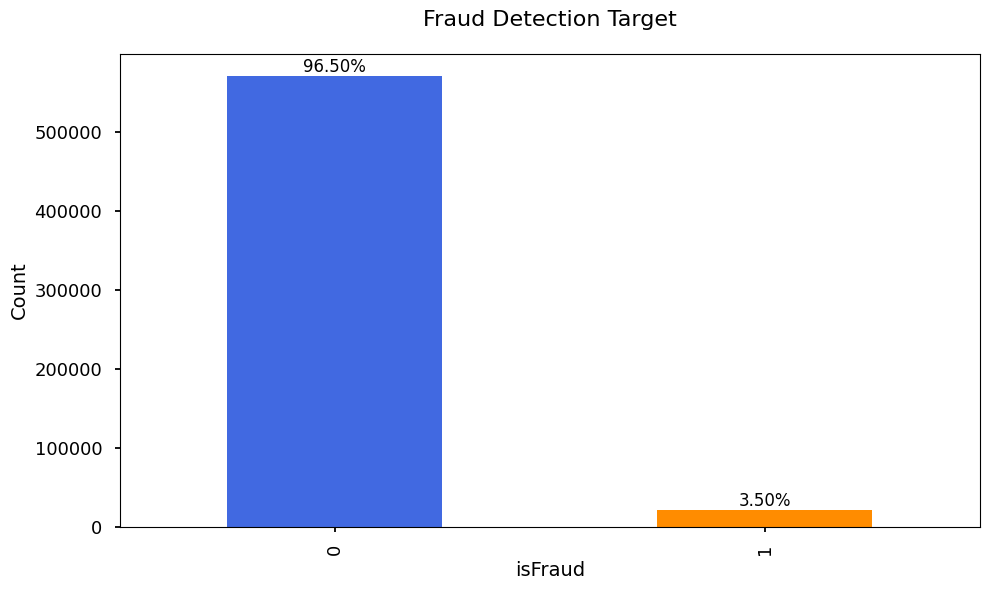

In [18]:
fig, axes = plt.subplots(figsize=(10, 6))  
fraud_counts.plot(
    kind="bar", ax=axes, color=["royalblue", "darkorange"]
)  

axes.set_title(
    "Fraud Detection Target", fontsize=16, pad=20
)  
axes.set_xlabel("isFraud", fontsize=14)
axes.set_ylabel("Count", fontsize=14)

plt.tight_layout()

total = float(df_train["isFraud"].shape[0])
for p in axes.patches:
    height = p.get_height()
    axes.text(
        p.get_x() + p.get_width() / 2.0,
        height + 5000,  
        "{:1.2f}%".format(height * 100 / total),  
        ha="center", 
        fontsize=12, 
        color="black",  
    )

plt.show()

Graph above shows that the data is highly imbalanced. About 96.5% of the transactions are not fraud. Only about 3.5% is fraud transactions.

##### TransactionDT (timedelta)

This represents a timedelta from a given reference datetime, not an actual timestamp. For instance, 86400 could indicate 86400 seconds from a specific time, such as 20/12/2020 10:09:10 PM

The goal is to verify that the data in both the training and testing sets is continuous over time. Specifically, the training data should come from an earlier time period, while the test data should come from a later time period, ensuring a proper train-test split.



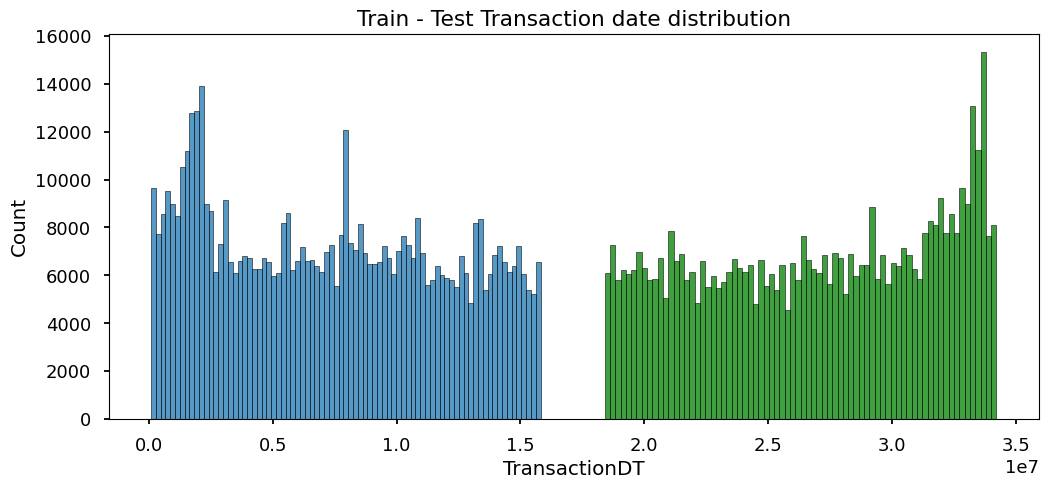

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
sns.histplot(df_train["TransactionDT"])
sns.histplot(df_test["TransactionDT"], color="g")
axes.title.set_text("Train - Test Transaction date distribution")
plt.show()

- The gap between training and test data suggests that there’s a slight discontinuity in the time range, which could affect the model’s generalization. It's important to consider this when selecting a proper validation technique.
- The high-transaction days highlight the presence of potential outliers or specific events, which could skew the model's understanding if not addressed. Adjusting for such anomalies is crucial to prevent the model from overfitting to these spikes.

#### Number of fraud transactions over day of week

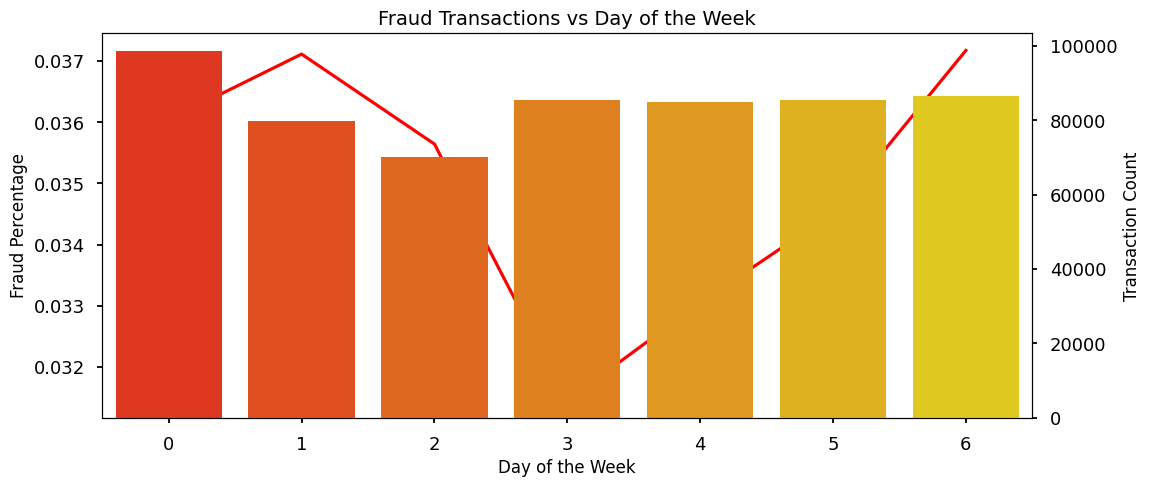

In [20]:
df_train["day_of_week"] = (df_train["TransactionDT"] // (60 * 60 * 24) - 1) % 7
fraud_percentage_by_day = (
    df_train[["isFraud", "day_of_week"]]
    .groupby(by=["day_of_week"])
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "fraud_percentage"})
)

transactions_by_day = (
    df_train[["TransactionID", "day_of_week"]]
    .groupby(by=["day_of_week"])
    .count()
    .reset_index()
    .rename(columns={"TransactionID": "transaction_count"})
)

daily_fraud_data = fraud_percentage_by_day.merge(
    transactions_by_day, on=["day_of_week"]
)


fig, axes = plt.subplots(figsize=(12, 5))

sns.lineplot(
    x=daily_fraud_data["day_of_week"],
    y=daily_fraud_data["fraud_percentage"],
    color="r",
    ax=axes,
)

axes2 = axes.twinx()
sns.barplot(
    x=daily_fraud_data["day_of_week"],
    y=daily_fraud_data["transaction_count"],
    palette="autumn",
    ax=axes2,
)

axes.set_title("Fraud Transactions vs Day of the Week", fontsize=14)
axes.set_xlabel("Day of the Week", fontsize=12)
axes.set_ylabel("Fraud Percentage", fontsize=12)
axes2.set_ylabel("Transaction Count", fontsize=12)

plt.show()

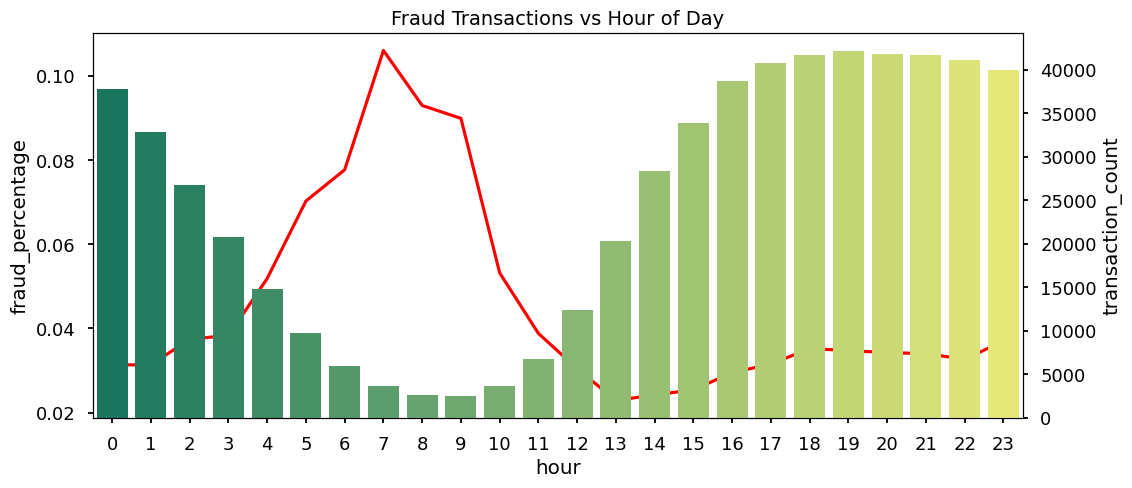

In [21]:
df_train["hour"] = (df_train["TransactionDT"] // (60 * 60)) % 24

fraud_percentage_by_hour = (
    df_train[["isFraud", "hour"]]
    .groupby(by=["hour"])
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "fraud_percentage"})
)

transactions_by_hour = (
    df_train[["TransactionID", "hour"]]
    .groupby(by=["hour"])
    .count()
    .reset_index()
    .rename(columns={"TransactionID": "transaction_count"})
)

hourly_fraud_data = fraud_percentage_by_hour.merge(transactions_by_hour, on=["hour"])

fig, axes = plt.subplots(figsize=(12, 5))

sns.lineplot(
    x=hourly_fraud_data["hour"],
    y=hourly_fraud_data["fraud_percentage"],
    color="r",
    ax=axes,
)

axes2 = axes.twinx()
sns.barplot(
    x=hourly_fraud_data["hour"],
    y=hourly_fraud_data["transaction_count"],
    palette="summer",
    ax=axes2,
)

axes.set_title("Fraud Transactions vs Hour of Day", fontsize=14)
plt.show()

To better understand temporal patterns in fraudulent transactions, we plotted two key graphs: Hour of Day vs. Fraud Percentage and Day of Week vs. Fraud Percentage. These visualizations help identify when fraud is most likely to occur, enabling time-based categorization for improved fraud detection. From the graphs, we observed distinct patterns, such as peak fraud activity during specific hours and certain days with higher transaction volumes. This insight guided us to create four time-based categories: high, medium, low, and very low risk periods.

* high (6, 7, 8, 9) : From 6am to 9am
* medium (3, 4, 5, 10, 11)
* low (11, 12, 16-0 , 1-2)
* very low (13, 14, 15)

These categories can be used as features in a machine learning model, enabling the system to adjust its fraud detection strategies dynamically based on the time of the transaction.

##### Transaction Amount (TransactionAmt)

Check if there is any missing values in the "TransactionAmt" column.

In [22]:
df_train["TransactionAmt"].isnull().sum()

np.int64(0)

Given that there's no missing values in any of the transactions. We can plot a graph showing the the average amount involved in transactions per hour and its fraudulent rate.

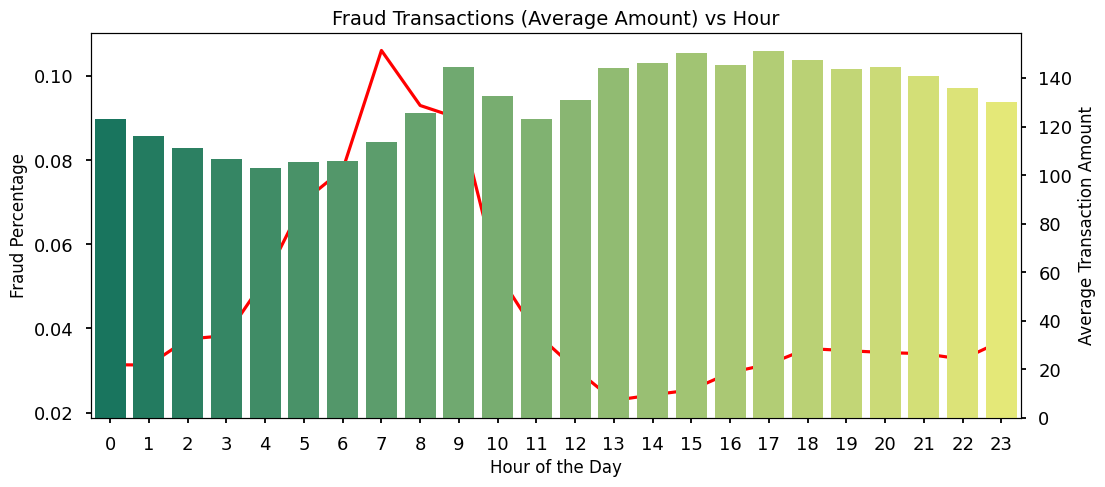

In [23]:
df_train["hour"] = (df_train["TransactionDT"] // (60 * 60)) % 24

fraud_percentage_by_hour = (
    df_train[["isFraud", "hour"]]
    .groupby("hour")
    .mean()
    .reset_index()
    .rename(columns={"isFraud": "fraud_percentage"})
)

avg_transaction_amount_by_hour = (
    df_train[["TransactionAmt", "hour"]]
    .groupby("hour")
    .mean()
    .reset_index()
    .rename(columns={"TransactionAmt": "avg_transaction_amount"})
)

hourly_fraud_data = fraud_percentage_by_hour.merge(
    avg_transaction_amount_by_hour, on="hour"
)

fig, axes = plt.subplots(figsize=(12, 5))

sns.lineplot(
    x=hourly_fraud_data["hour"],
    y=hourly_fraud_data["fraud_percentage"],
    color="r",
    ax=axes,
)

axes2 = axes.twinx()

sns.barplot(
    x=hourly_fraud_data["hour"],
    y=hourly_fraud_data["avg_transaction_amount"],
    palette="summer",
    ax=axes2,
)

axes.set_title("Fraud Transactions (Average Amount) vs Hour", fontsize=14)
axes.set_xlabel("Hour of the Day", fontsize=12)
axes.set_ylabel("Fraud Percentage", fontsize=12)
axes2.set_ylabel("Average Transaction Amount", fontsize=12)

plt.show()

Vizualising Outliers

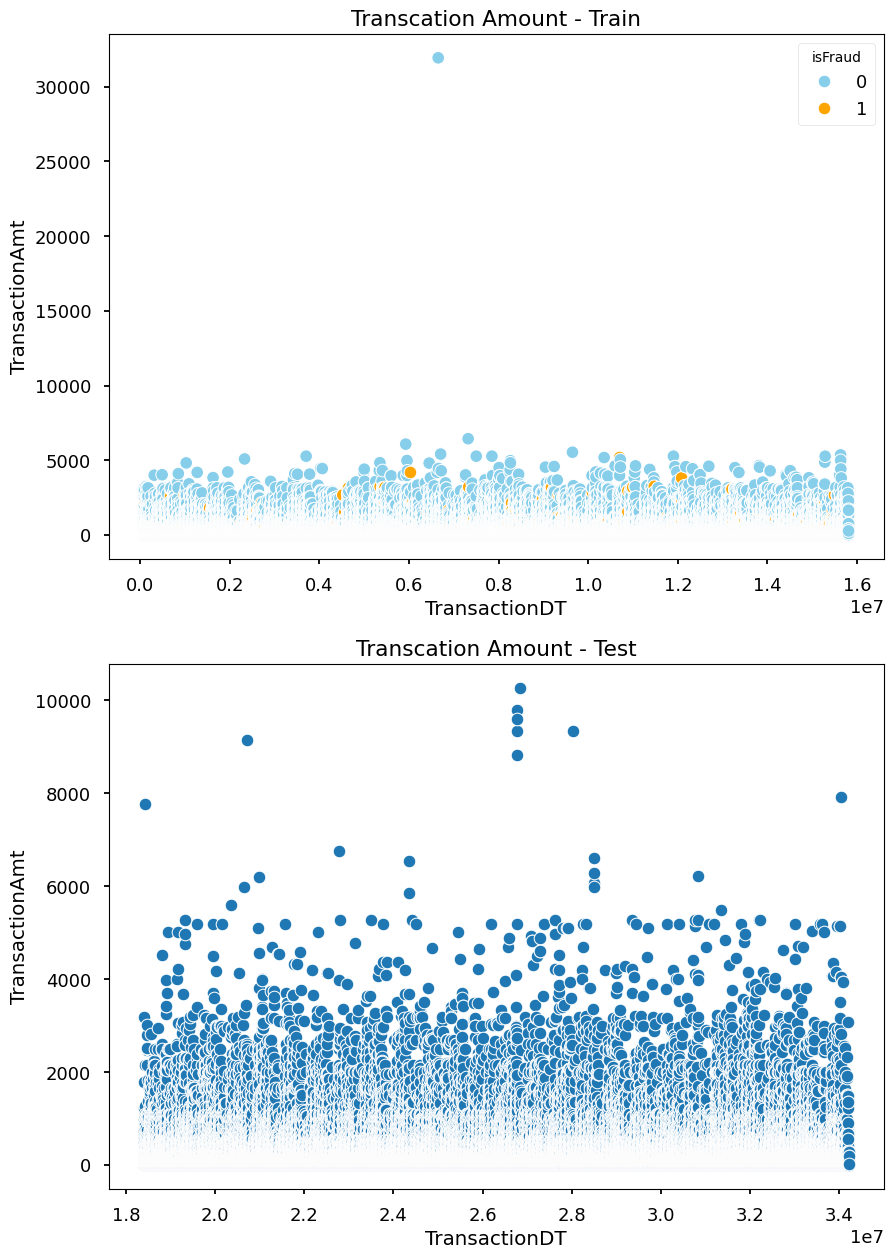

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))
fraud_palette = {0: "skyblue", 1: "orange"}

sns.scatterplot(
    y=df_train["TransactionAmt"],
    x=df_train["TransactionDT"],
    hue=df_train["isFraud"],
    palette=fraud_palette,
    ax=axes[0],
)
axes[0].title.set_text("Transcation Amount - Train")

sns.scatterplot(
    y=df_test["TransactionAmt"],
    x=df_test["TransactionDT"],
    ax=axes[1],
    palette=fraud_palette,
)
axes[1].title.set_text("Transcation Amount - Test")

plt.show()

There is one transaction in the training data with an amount exceeding 30,000. It is advisable to remove this outlier, as it can negatively impact model performance, especially for distance-based algorithms like logistic regression or KNN.

Additionally, outliers like this can lead to overfitting, particularly in tree-based models, which may isolate such values into separate leaf nodes, treating them as meaningful patterns when they are likely just noise. Therefore, I decided to remove transactions with amounts larger than 30,000 from the training set.

In [25]:
df_train = df_train[df_train['TransactionAmt'] < 30000]
df_train.shape

(590538, 436)

Distribution

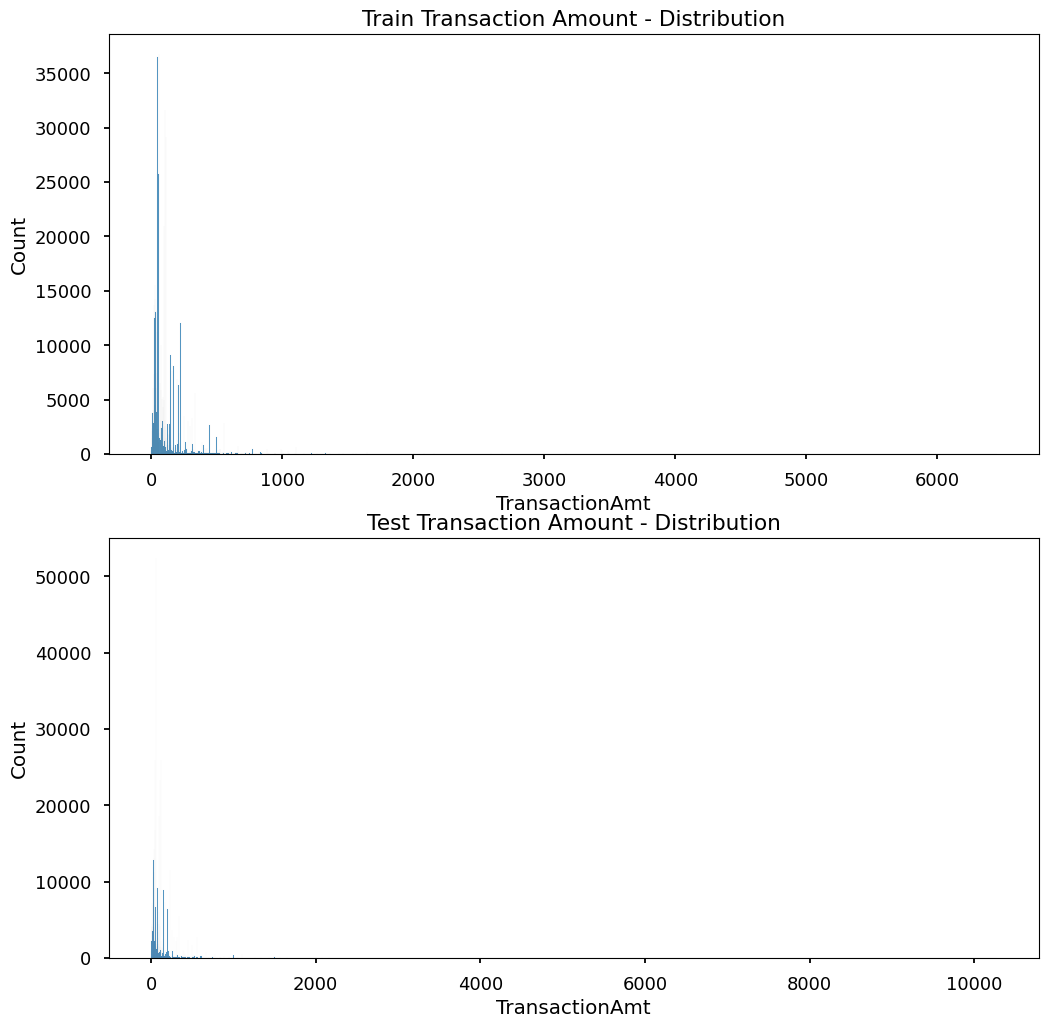

Minimum transaction amount in train data: 0.251, Maximum amount: 6450.97
Minimum transaction amount in test data: 0.018, Maximum amount: 10270.0


In [26]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.histplot(df_train["TransactionAmt"], ax=axes[0])
sns.histplot(df_test["TransactionAmt"], ax=axes[1])

axes[0].set_title("Train Transaction Amount - Distribution")
axes[1].set_title("Test Transaction Amount - Distribution")

plt.show()

train_min, train_max = df_train["TransactionAmt"].min(), df_train["TransactionAmt"].max(),

test_min, test_max = df_test["TransactionAmt"].min(), df_test["TransactionAmt"].max()

print(
    f"Minimum transaction amount in train data: {train_min}, Maximum amount: {train_max}"
)
print(
    f"Minimum transaction amount in test data: {test_min}, Maximum amount: {test_max}"
)

TransactionAmt vs Fraud

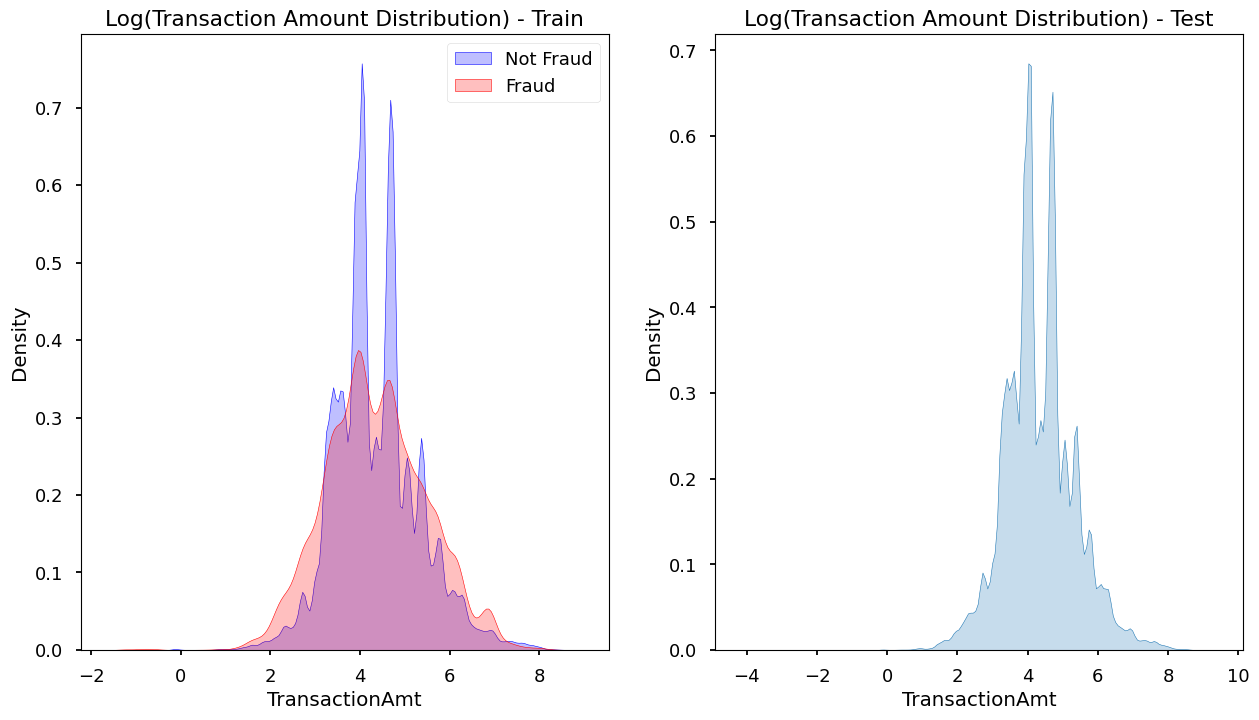

In [27]:
test_amt_log = np.log(df_test["TransactionAmt"])

fraud_transactions = df_train[df_train["isFraud"] == 1].copy()
non_fraud_transactions = df_train[df_train["isFraud"] == 0].copy()

fraud_transactions["TransactionAmt"] = np.log(fraud_transactions["TransactionAmt"])
non_fraud_transactions["TransactionAmt"] = np.log(
    non_fraud_transactions["TransactionAmt"]
)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.kdeplot(
    non_fraud_transactions["TransactionAmt"],
    ax=axes[0],
    label="Not Fraud",
    color="blue",
    shade=True,
)
sns.kdeplot(
    fraud_transactions["TransactionAmt"],
    ax=axes[0],
    label="Fraud",
    color="red",
    shade=True,
)
axes[0].set_title("Log(Transaction Amount Distribution) - Train")
axes[0].legend()

sns.kdeplot(test_amt_log, ax=axes[1], shade=True)
axes[1].set_title("Log(Transaction Amount Distribution) - Test")

plt.show()

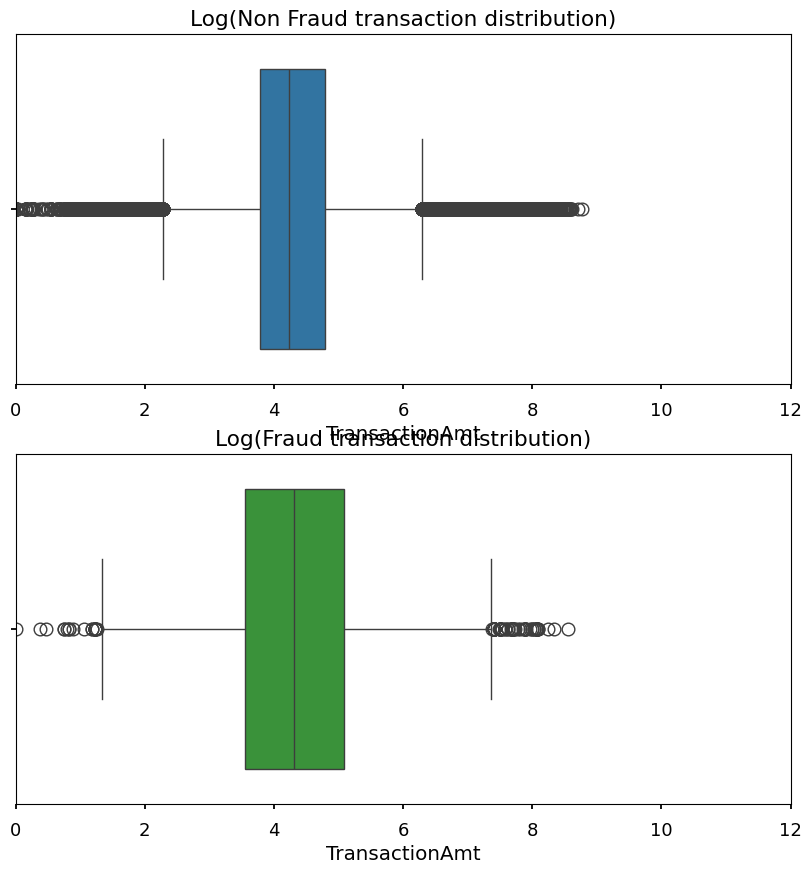

Mean transaction amt for fraud is 4.3506 ie, 77.5264 dollars
Mean transaction amt for non-fraud is 4.3643 ie, 78.5962 dollars
Median transaction amt for fraud is 4.3175  ie, 75.0000 dollars
Median transaction amt for non-fraud is 4.2268  ie, 68.5000 dollars


In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
sns.boxplot(x=non_fraud_transactions["TransactionAmt"], ax=axes[0])
axes[0].title.set_text("Log(Non Fraud transaction distribution)")
axes[0].set(xlim=(0, 12))
sns.boxplot(x=fraud_transactions["TransactionAmt"], ax=axes[1], color=colors[2])
axes[1].title.set_text("Log(Fraud transaction distribution)")
axes[1].set(xlim=(0, 12))
plt.show()

print(
    "Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars".format(
        fraud_transactions["TransactionAmt"].mean(),
        np.exp(fraud_transactions["TransactionAmt"].mean()),
    )
)
print(
    "Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars".format(
        non_fraud_transactions["TransactionAmt"].mean(),
        np.exp(non_fraud_transactions["TransactionAmt"].mean()),
    )
)

print(
    "Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars".format(
        fraud_transactions["TransactionAmt"].median(),
        np.exp(fraud_transactions["TransactionAmt"].median()),
    )
)
print(
    "Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars".format(
        non_fraud_transactions["TransactionAmt"].median(),
        np.exp(non_fraud_transactions["TransactionAmt"].median()),
    )
)

- Fraudulent transactions have a slightly higher median compared to non-fraudulent ones.
- Fraudulent transactions also exhibit a more prominent normal distribution, with a wider bell curve. This suggests that a larger number of fraudulent transactions fall within a specific range.
- It appears that transactions with a 'LogTransactionAmt' greater than 5.5 (approximately $244) or less than 3.3 (around $27) have a higher frequency and probability of being fraudulent. In contrast, transactions with 'LogTransactionAmt' between 3.3 and 5.5 are more likely to be legitimate.

##### Product Code (ProductCD)

In [29]:
df_train["ProductCD"].isnull().sum()

np.int64(0)

In [30]:
df_train["ProductCD"].value_counts()

ProductCD
W    439668
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64

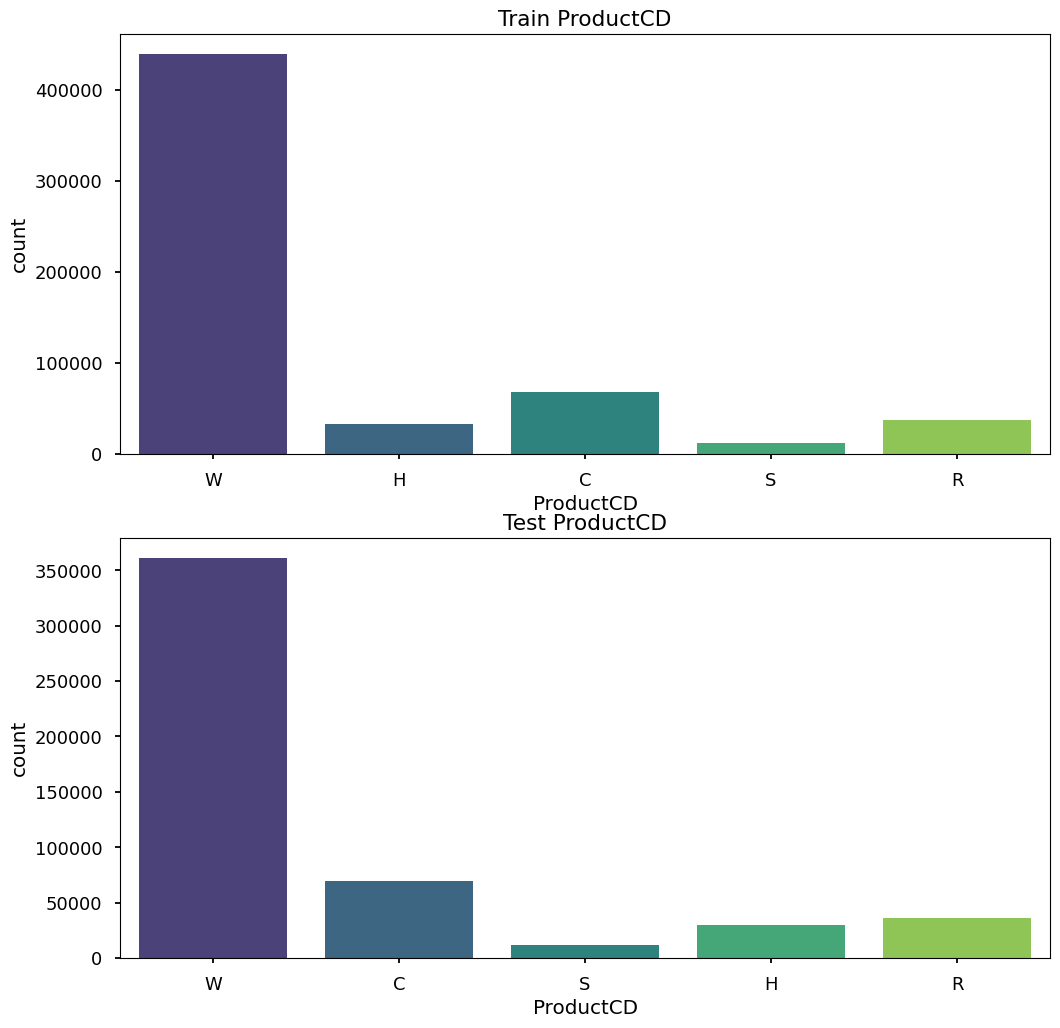

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.countplot(x=df_train["ProductCD"], ax=axes[0], palette="viridis")
sns.countplot(x=df_test["ProductCD"], ax=axes[1], palette="viridis")
axes[0].title.set_text("Train ProductCD")
axes[1].title.set_text("Test ProductCD")
plt.show()

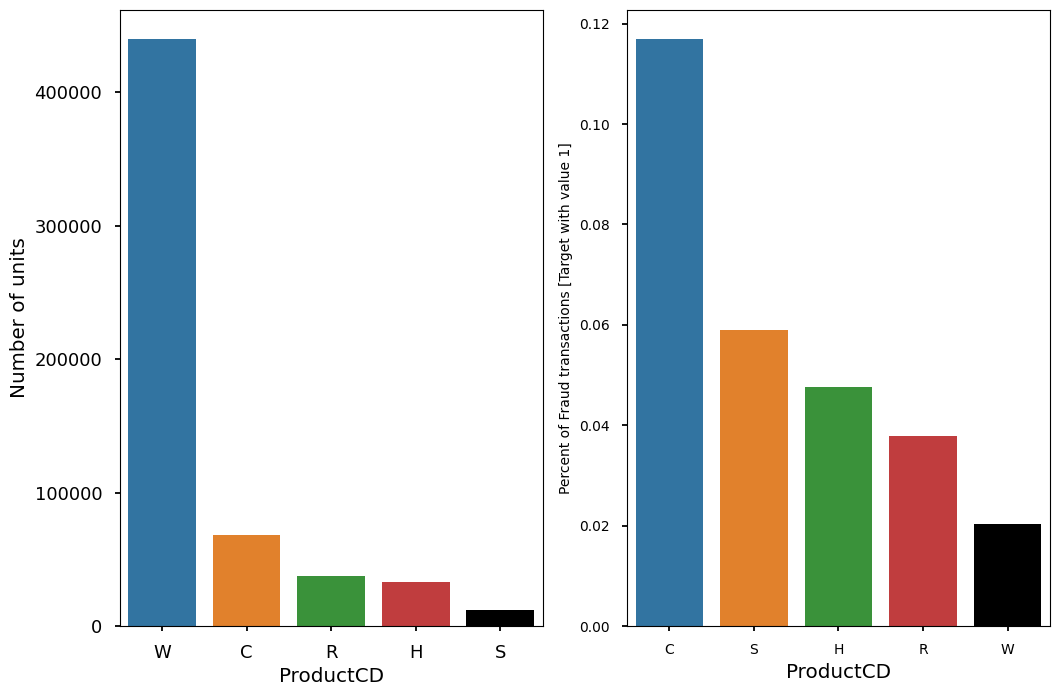

In [32]:
def hor_plot(feat, df=df_train, label_rotation=False, shape=(12, 8)):

    val_cnts = df[feat].value_counts()
    df1 = pd.DataFrame({feat: val_cnts.index, "Number of units": val_cnts.values})

    percent = df[[feat, "isFraud"]].groupby([feat], as_index=False).mean()
    percent.sort_values(by="isFraud", ascending=False, inplace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=shape)
    custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#000000"]
    s = sns.barplot(ax=ax1, x=feat, y="Number of units", data=df1, palette=custom_palette)
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    s = sns.barplot(
        ax=ax2,
        x=feat,
        y="isFraud",
        order=percent[feat],
        data=percent,
        palette=custom_palette,
    )
    if label_rotation:
        s.set_xticklabels(s.get_xticklabels(), rotation=90)

    plt.ylabel("Percent of Fraud transactions [Target with value 1]", fontsize=10)
    plt.tick_params(axis="both", which="major", labelsize=10)
    plt.show()

hor_plot(df=df_train, feat="ProductCD")

Observation:
1. Product W is the majority of all transactions, and the fraud transactions in product W is more too. But only approximately 2% of all product W is fraud.
2. About 11% of all product C are fraudulant transactions.
3. About 6% of all product S are fraudulant transactions.

##### Card 1 - 6

Columns below provides payment card information, such as card type, card category, issue bank, country, etc.

In [33]:
cards = [col for col in df_train.columns if "card" in col]
df_train[cards].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

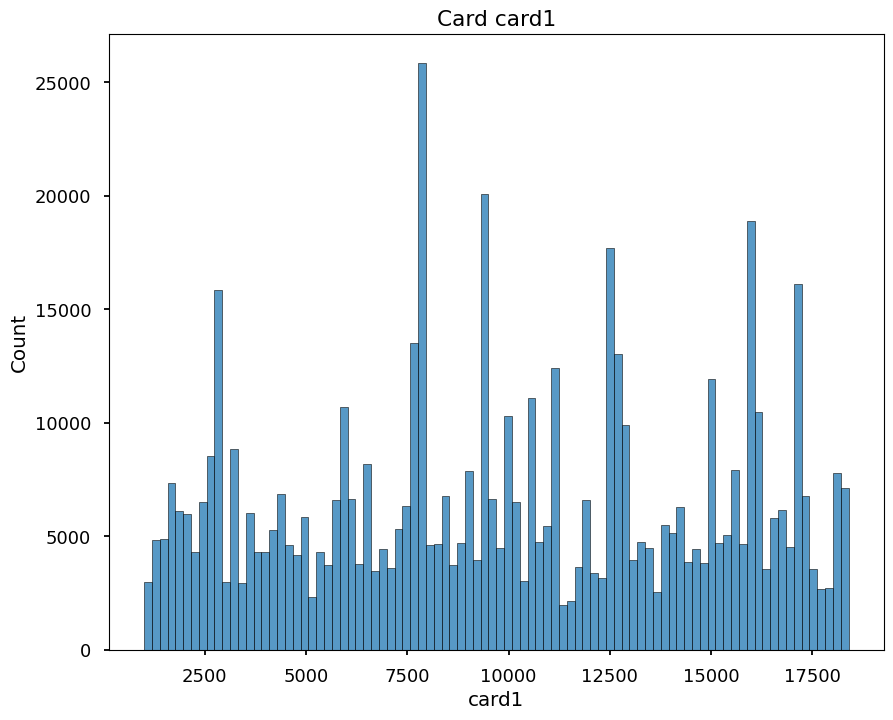

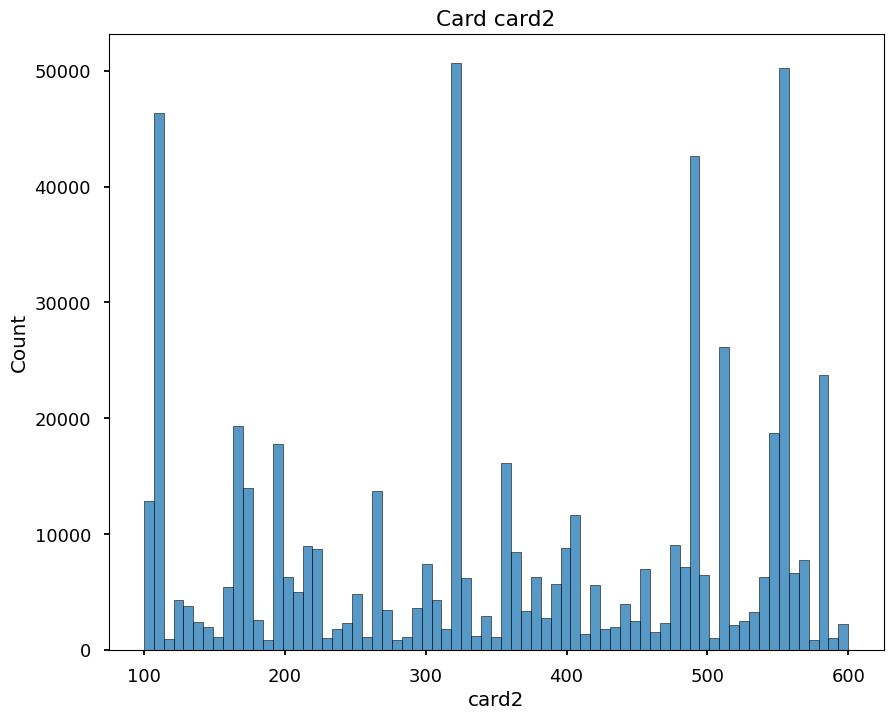

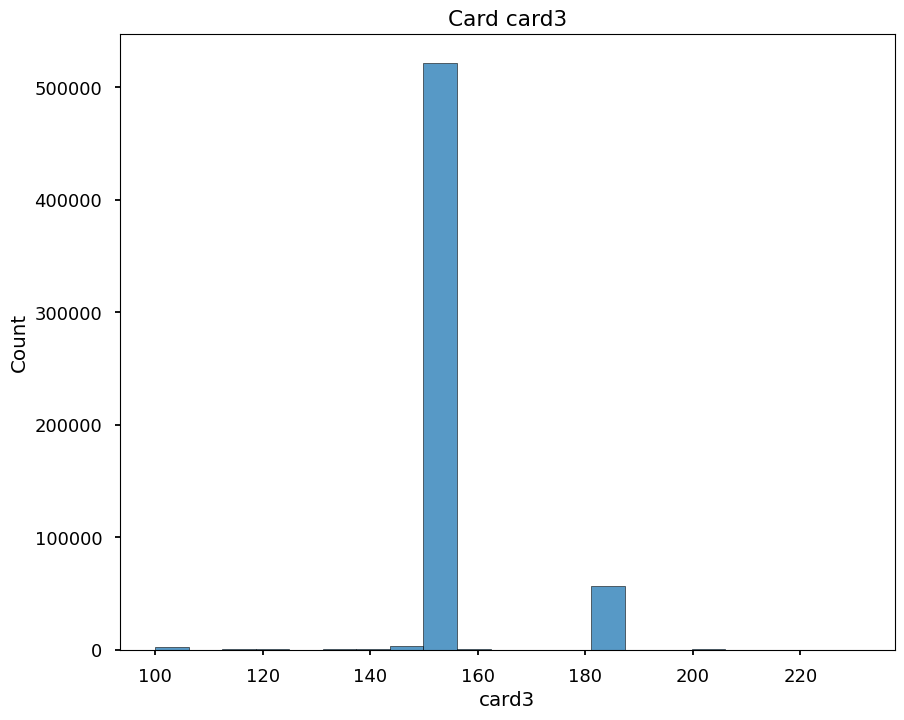

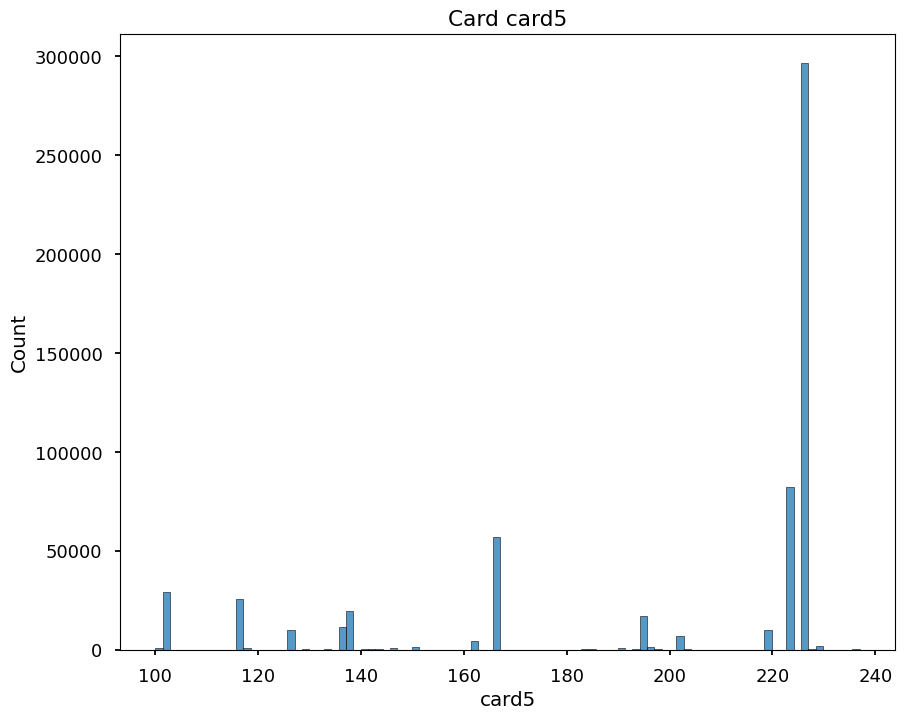

In [34]:
for c in cards:
    if df_train[c].dtypes in ["int64", "float64"]:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
        sns.histplot(df_train[c])
        axes.title.set_text(f"Card {c}")
        plt.show()

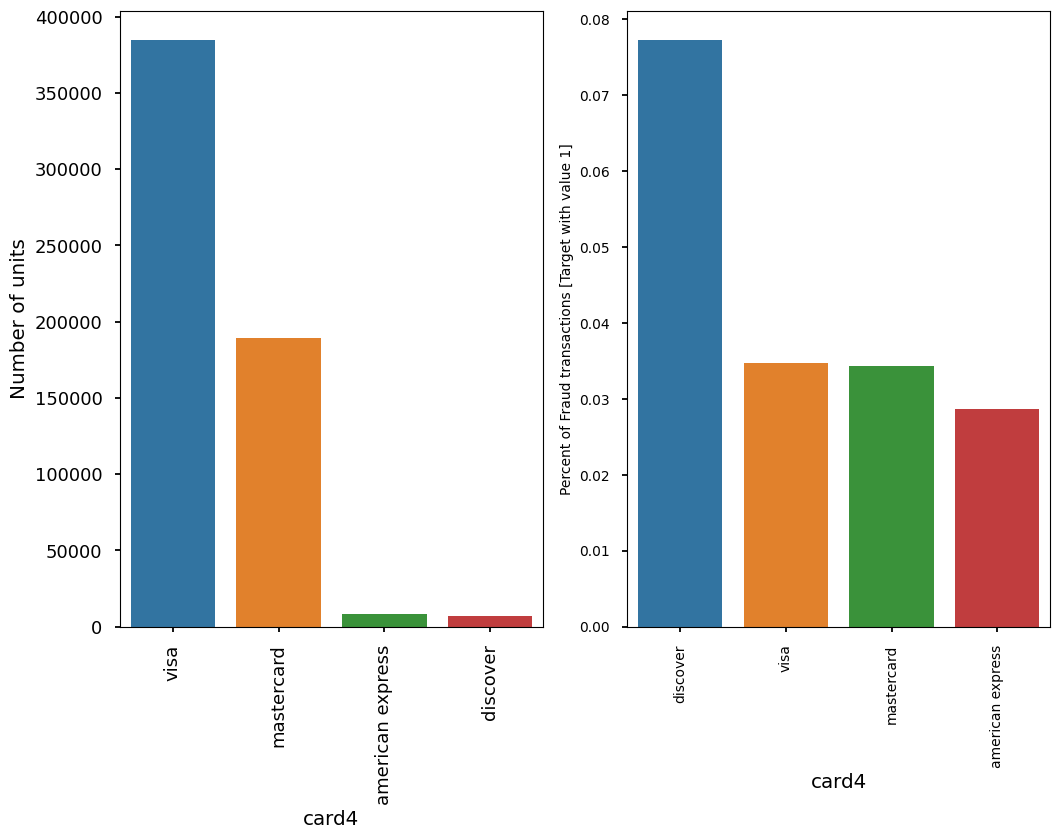

In [35]:
hor_plot("card4", label_rotation=True)

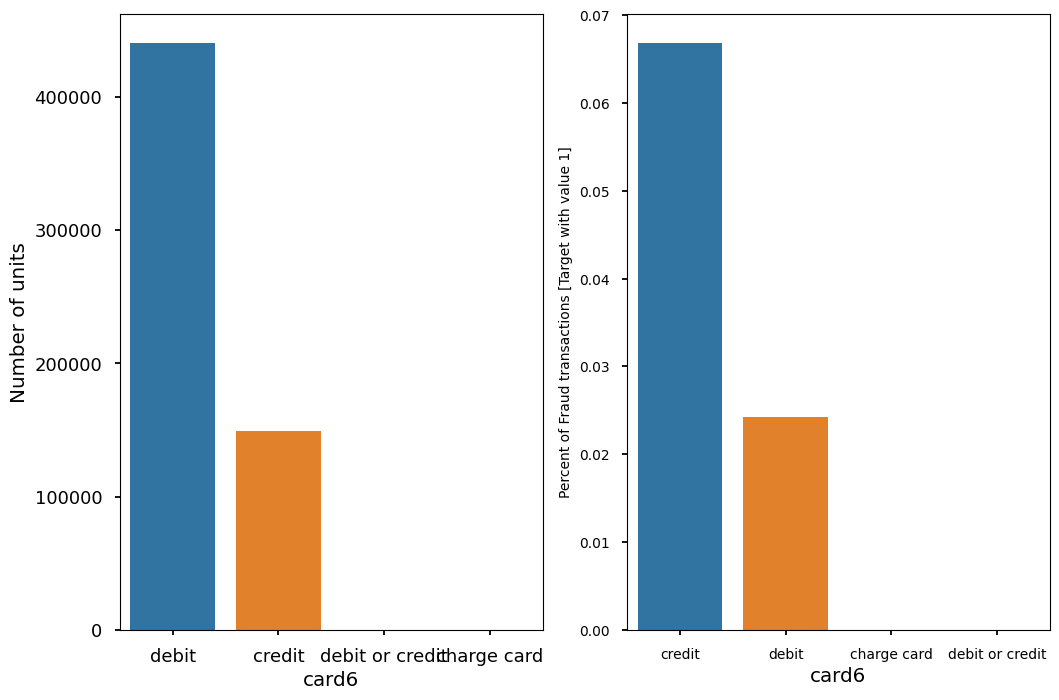

In [36]:
hor_plot("card6")

In [37]:
# Only select numerical values for correlation
cards = ["card1", "card2", "card3", "card5", "isFraud"]
df_train[cards].corr()

card1     card2     card3     card5   isFraud
card1    1.000000  0.004956  0.002966 -0.093624 -0.013639
card2    0.004956  1.000000  0.023817  0.030494  0.003389
card3    0.002966  0.023817  1.000000 -0.158387  0.154151
card5   -0.093624  0.030494 -0.158387  1.000000 -0.033581
isFraud -0.013639  0.003389  0.154151 -0.033581  1.000000

- The categorical values for card1 and card2 exhibit behavior similar to numeric features.
- Among credit cards, there is a higher likelihood of fraudulent transactions, accounting for approximately 6.5% of all transactions.
- Within card4, Discover cards have the highest rate of fraudulent cases, at around 7.6%.
- Card3 shows low correlation with other card features.

##### P_email domain and R_email domain

Email domain of purchaser and recipient

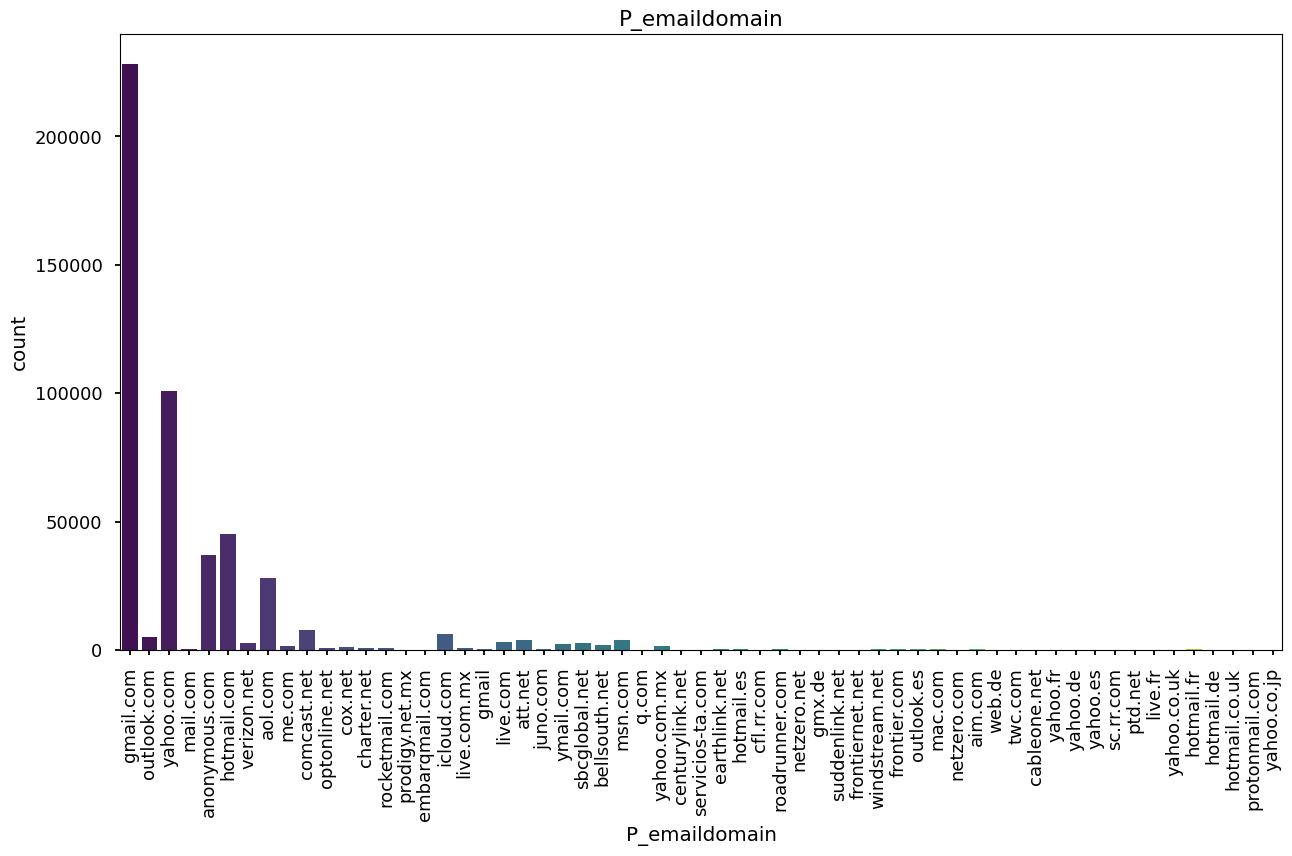

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.countplot(x=df_train_transaction["P_emaildomain"], palette="viridis")
axes.title.set_text("P_emaildomain")
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

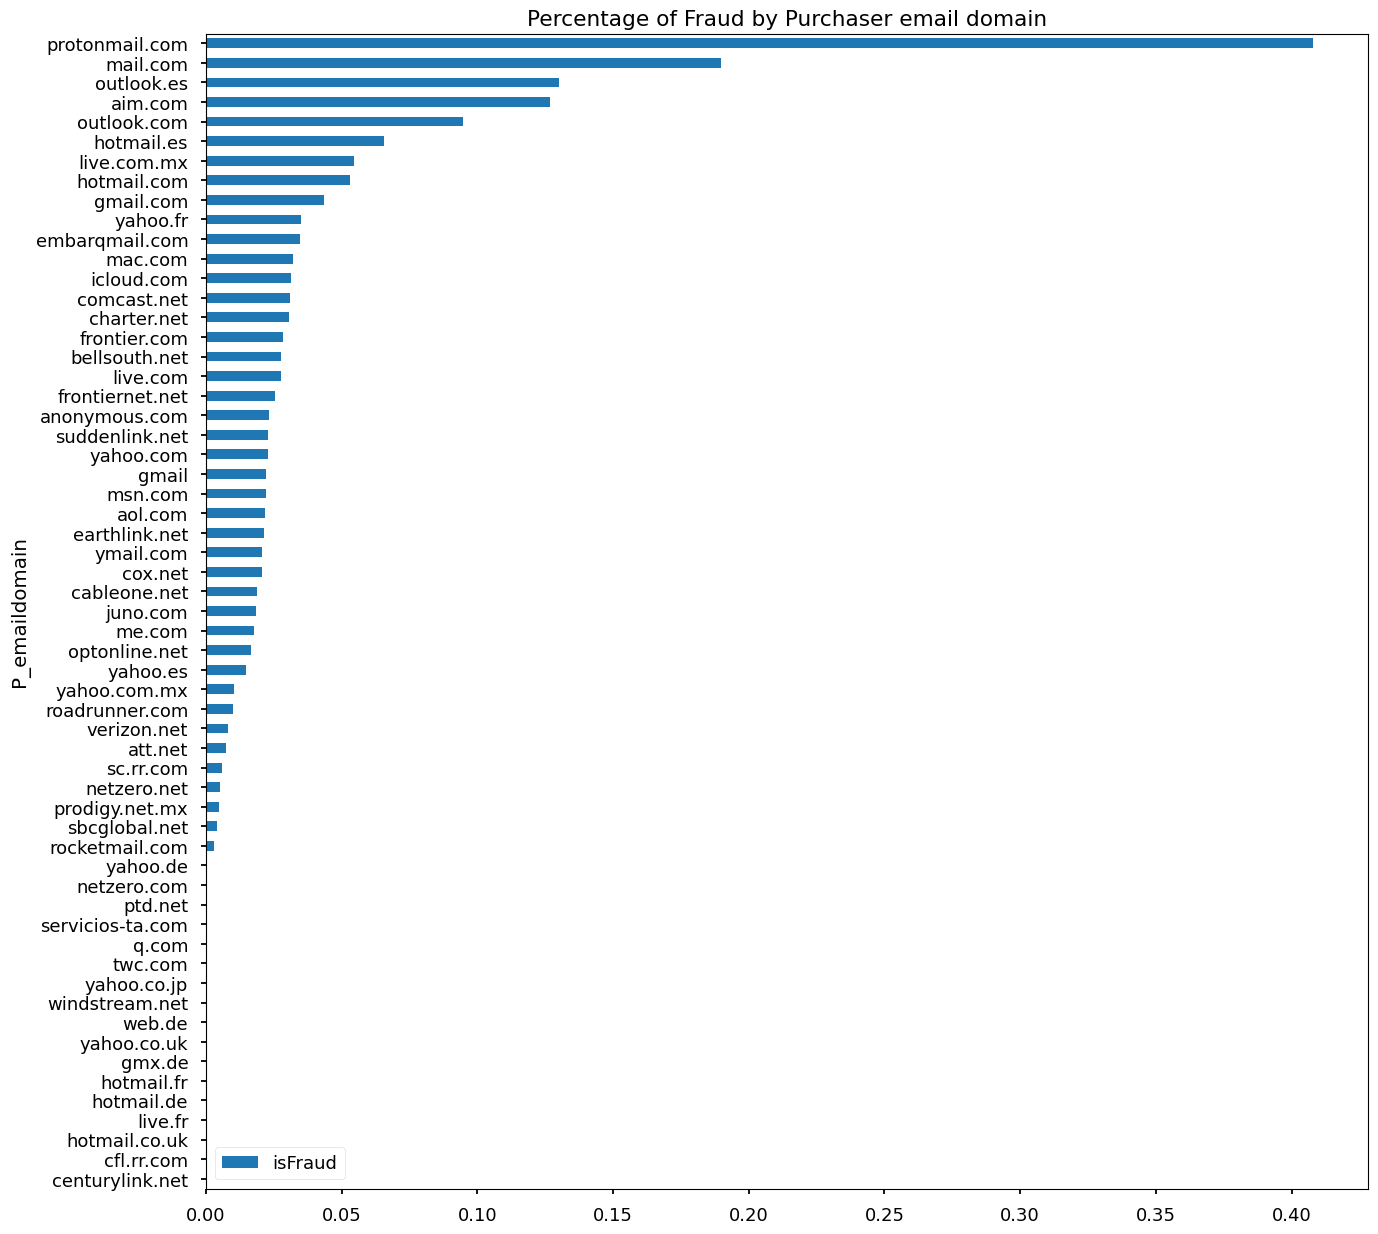

In [39]:
df_train_transaction[["P_emaildomain", "isFraud"]].groupby(
    by=["P_emaildomain"]
).mean().sort_values(by=["isFraud"]).plot(
    kind="barh", figsize=(15, 15), title="Percentage of Fraud by Purchaser email domain"
)
plt.show()

Purchaser Email:
* most mails are from gmail.com
* more than 40% fraud transactions come from domain protonmail.com

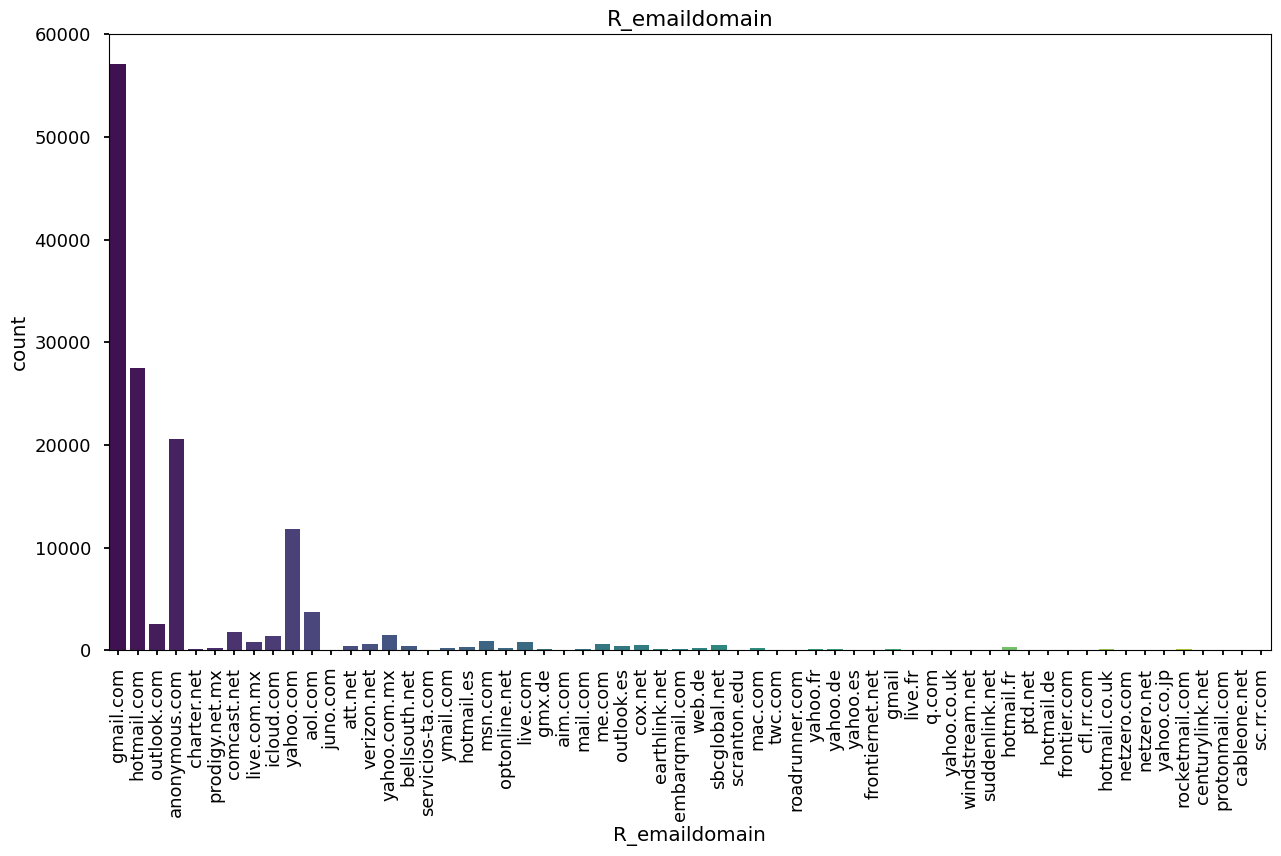

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.countplot(x=df_train_transaction["R_emaildomain"], palette="viridis")
axes.title.set_text("R_emaildomain")
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

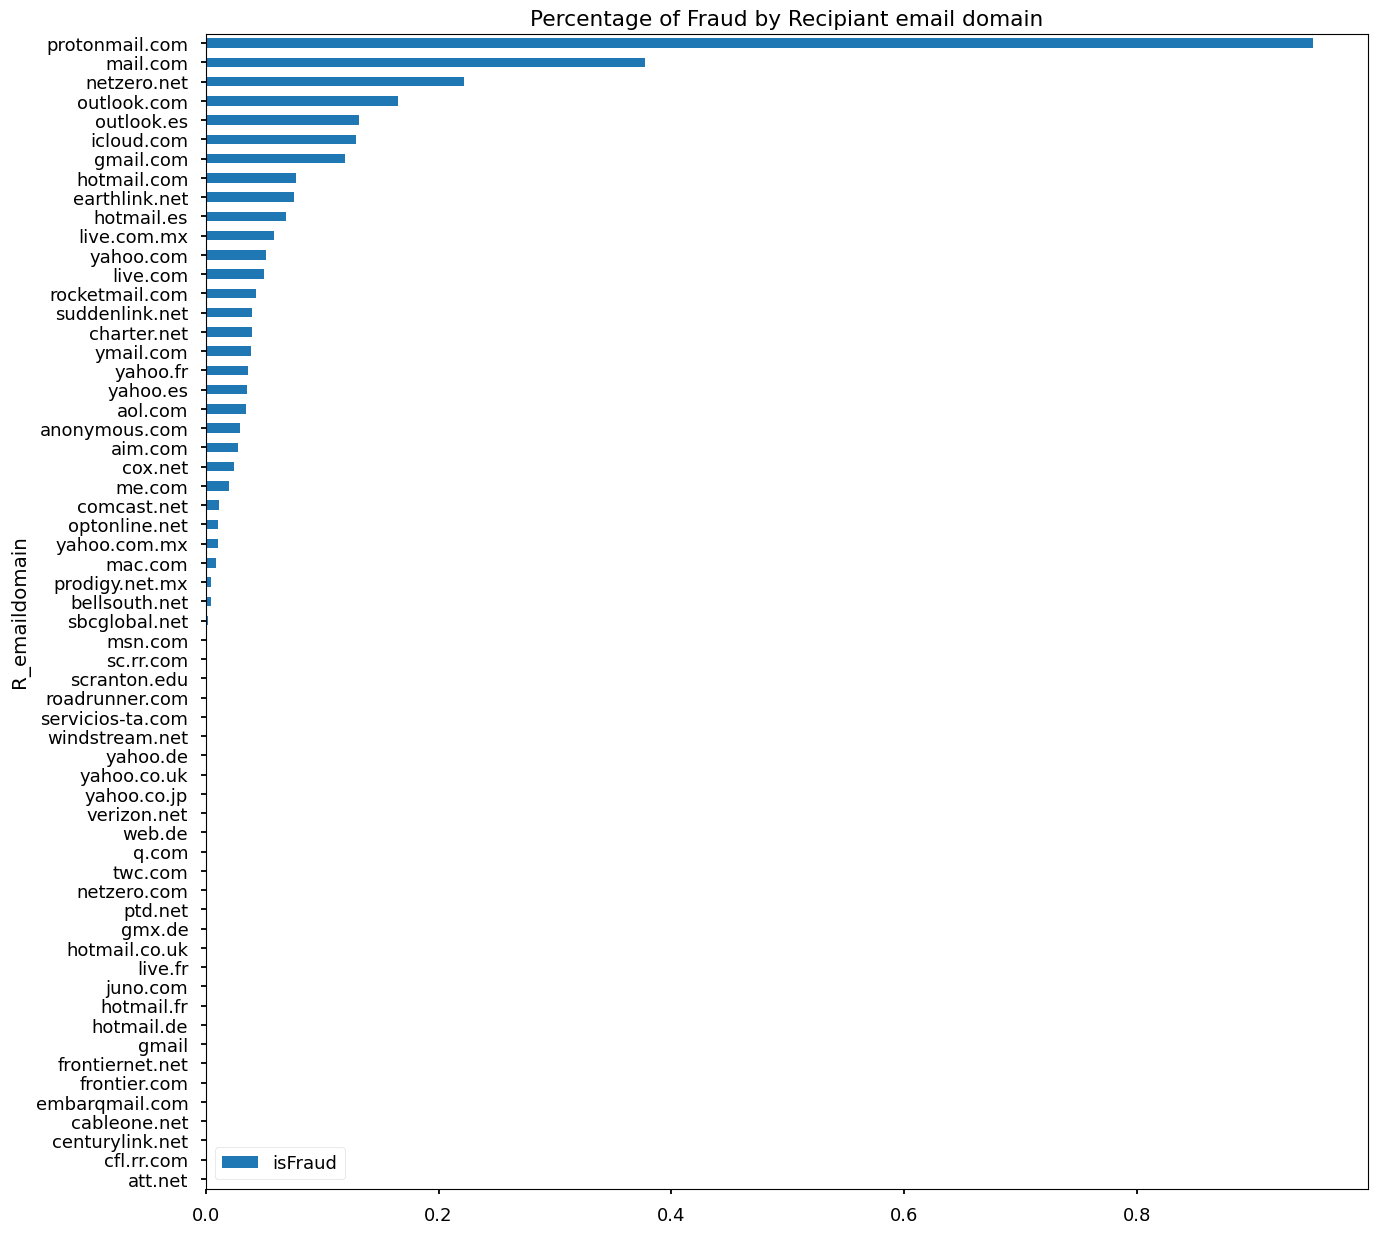

In [41]:
df_train_transaction[["R_emaildomain", "isFraud"]].groupby(
    by=["R_emaildomain"]
).mean().sort_values(by=["isFraud"]).plot(
    kind="barh", figsize=(15, 15), title="Percentage of Fraud by Recipiant email domain"
)
plt.show()

Recipient Email:
- most mails are from domain gmail.com
- more than 90% fraud transaction comes from domain protonmail.com, which is critical

##### Addr1 and Addr2
Address information

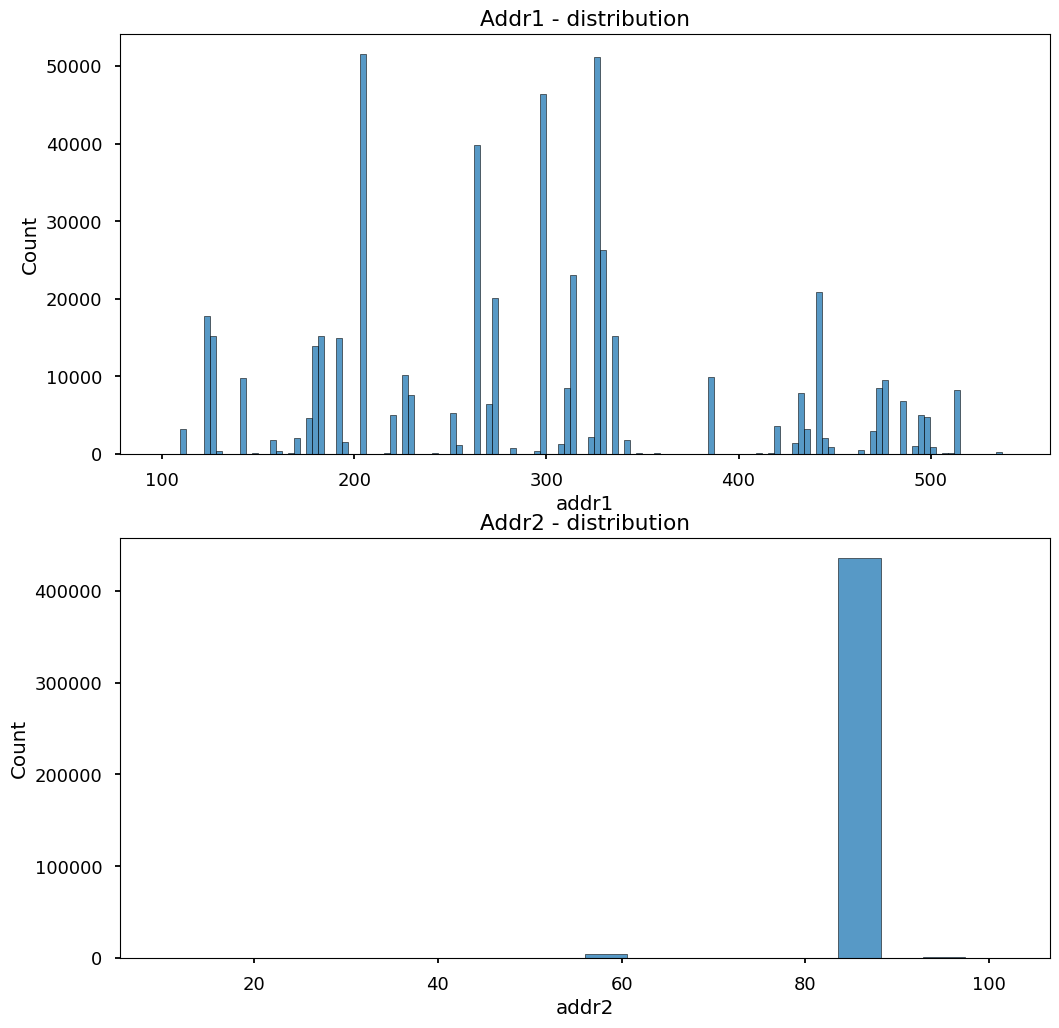

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.histplot(df_train_transaction["addr1"], ax=axes[0])
sns.histplot(df_test_transaction["addr2"], ax=axes[1])
axes[0].title.set_text("Addr1 - distribution")
axes[1].title.set_text("Addr2 - distribution")
plt.show()

##### Dist1 and Dist2
Indication of distance between one point and one point (might be transaction location and card owner address)

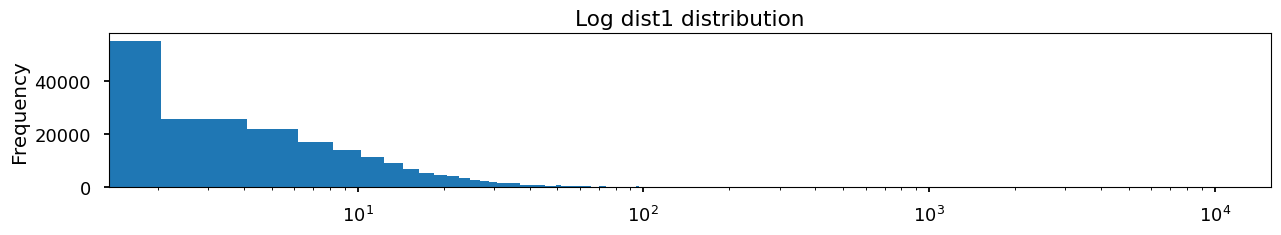

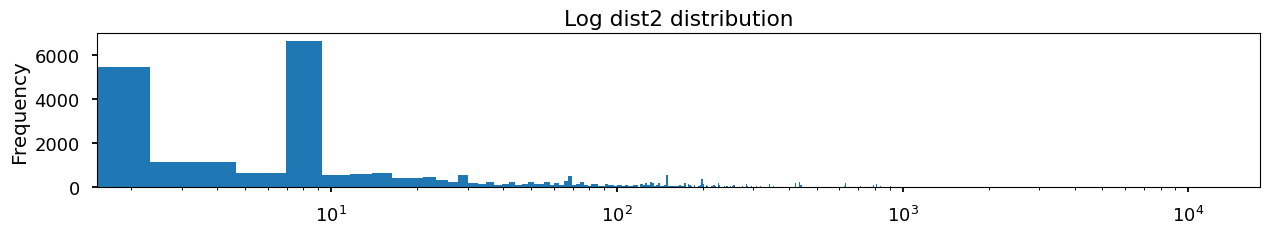

In [43]:
df_train["dist1"].plot(
    kind="hist",
    bins=5000,
    figsize=(15, 2),
    title="Log dist1 distribution",
    color=colors[0],
    logx=True,
)
plt.show()
df_train["dist2"].plot(
    kind="hist",
    bins=5000,
    figsize=(15, 2),
    title="Log dist2 distribution",
    color=colors[0],
    logx=True,
)
plt.show()

Note: 93% of data is missing in dist2

##### C1 - C14

In [44]:
c_cols = [c for c in df_train if c[0] == "C"]
df_train[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

In [45]:
sample_df = pd.concat(
    [
        df_train.loc[df_train["isFraud"] == 0].sample(500),
        df_train.loc[df_train["isFraud"] == 1].sample(500),
    ]
)

<Figure size 2000x2000 with 0 Axes>

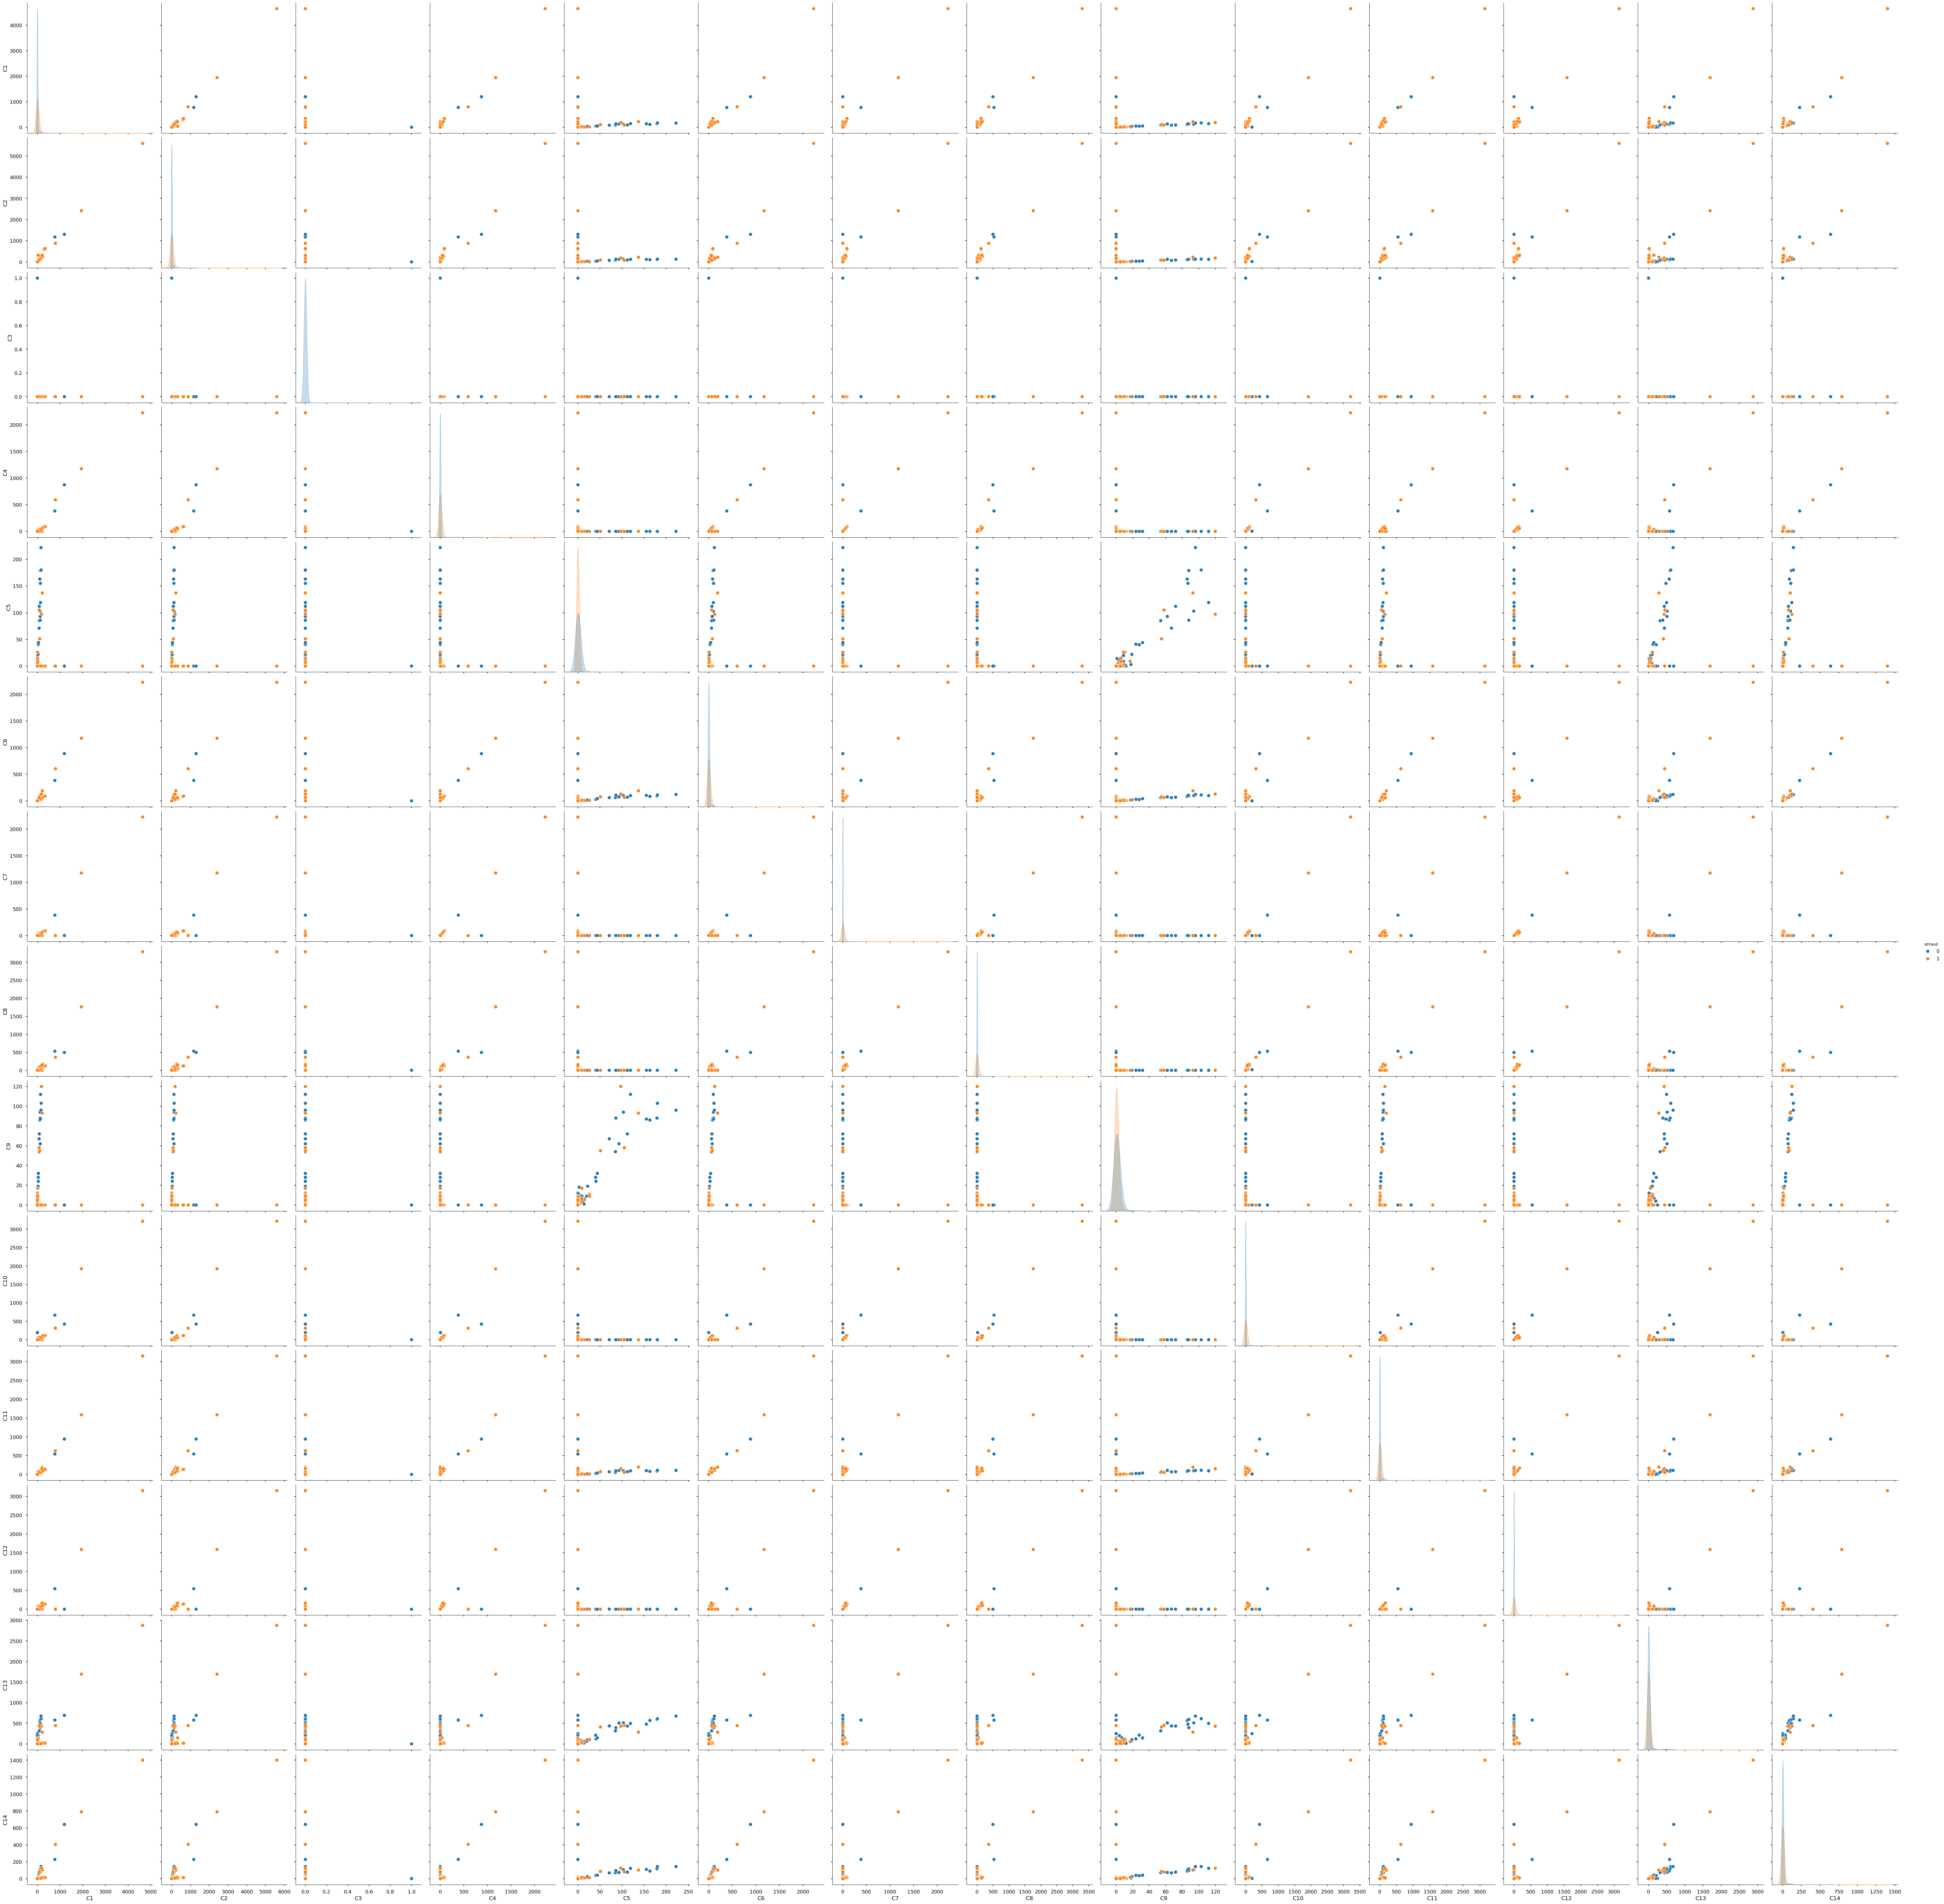

In [46]:
plt.figure(figsize=(20, 20))
sns.pairplot(sample_df, hue="isFraud", vars=c_cols, height=5)
plt.show()

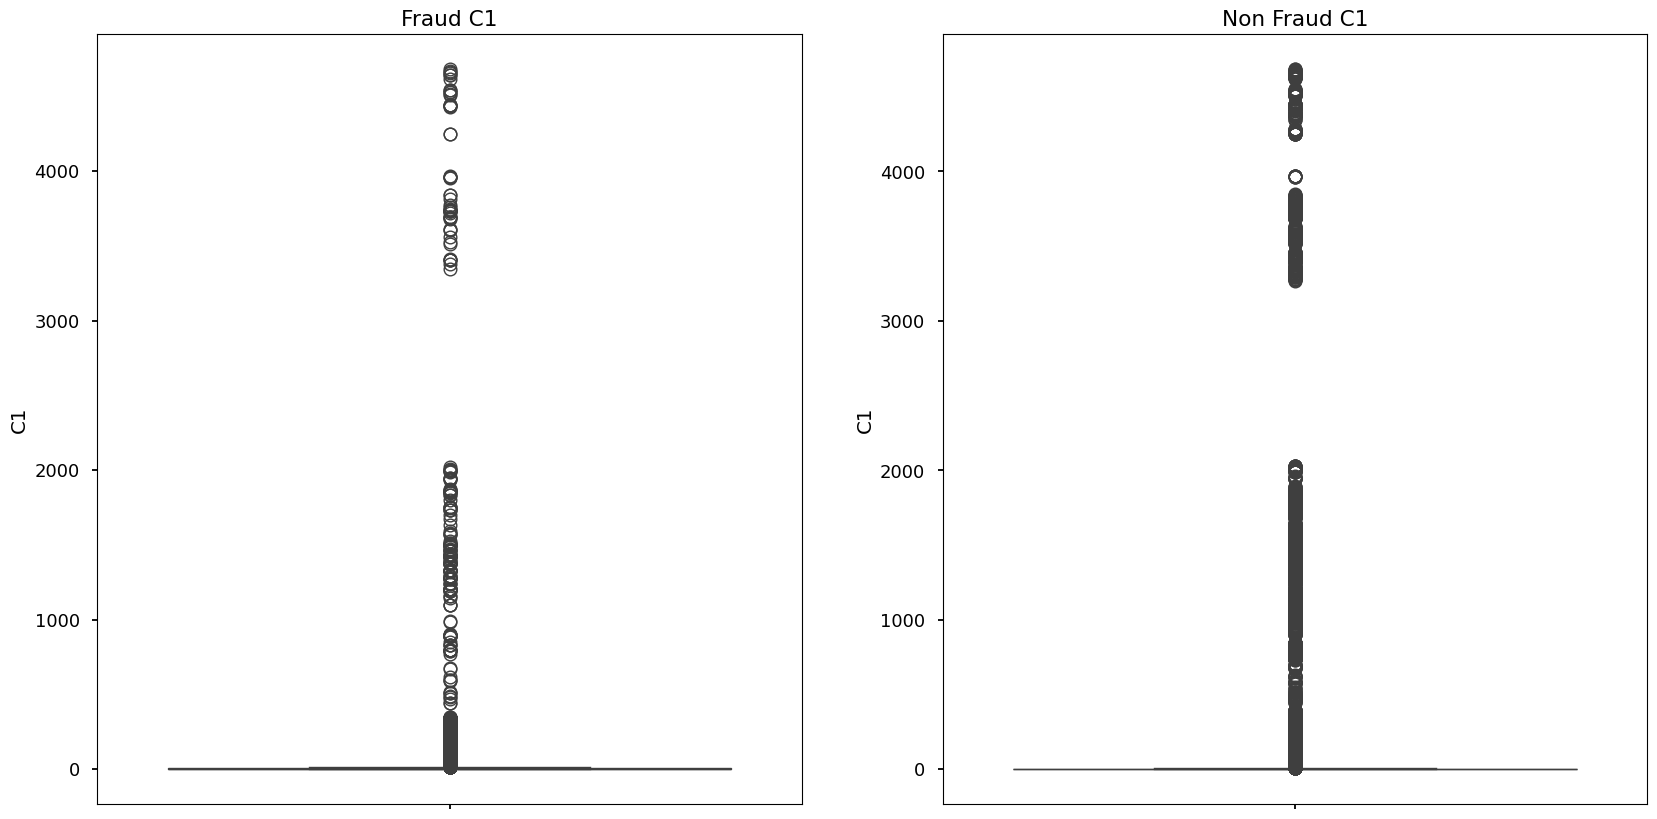

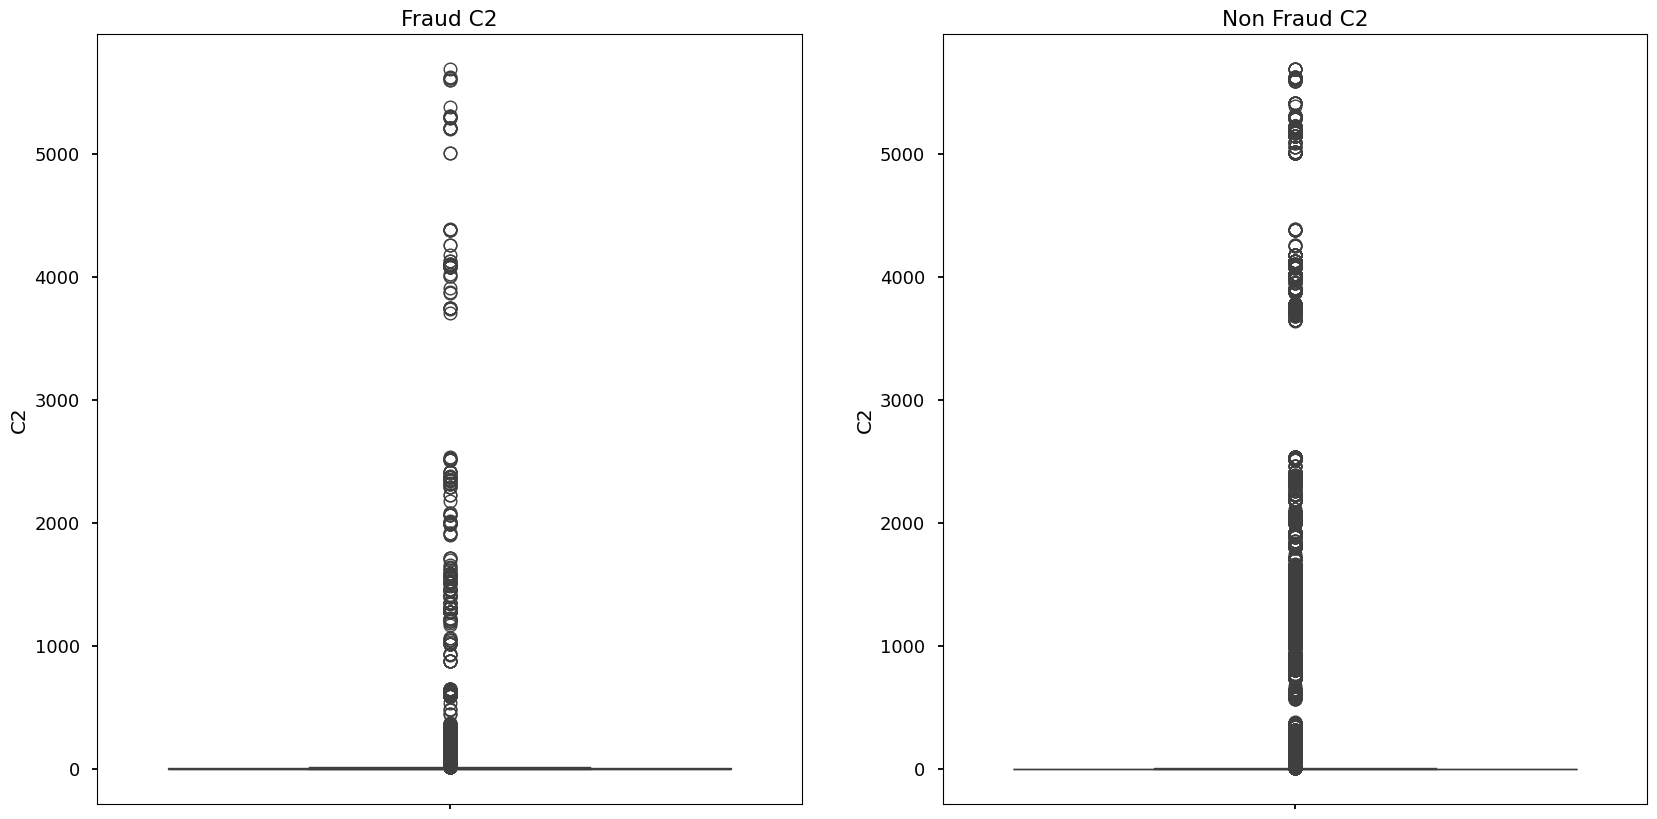

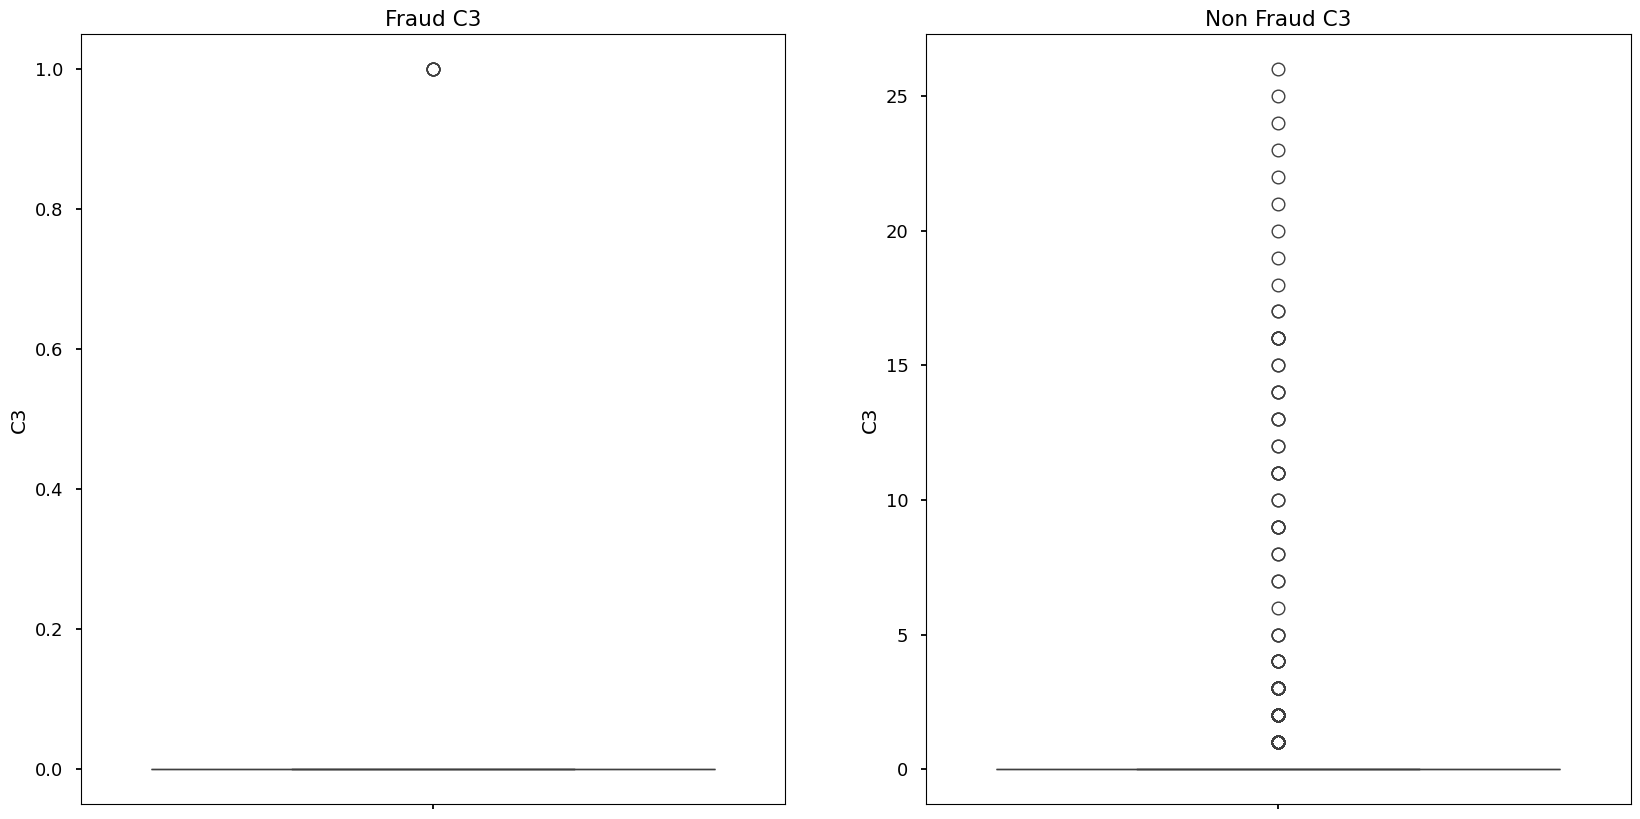

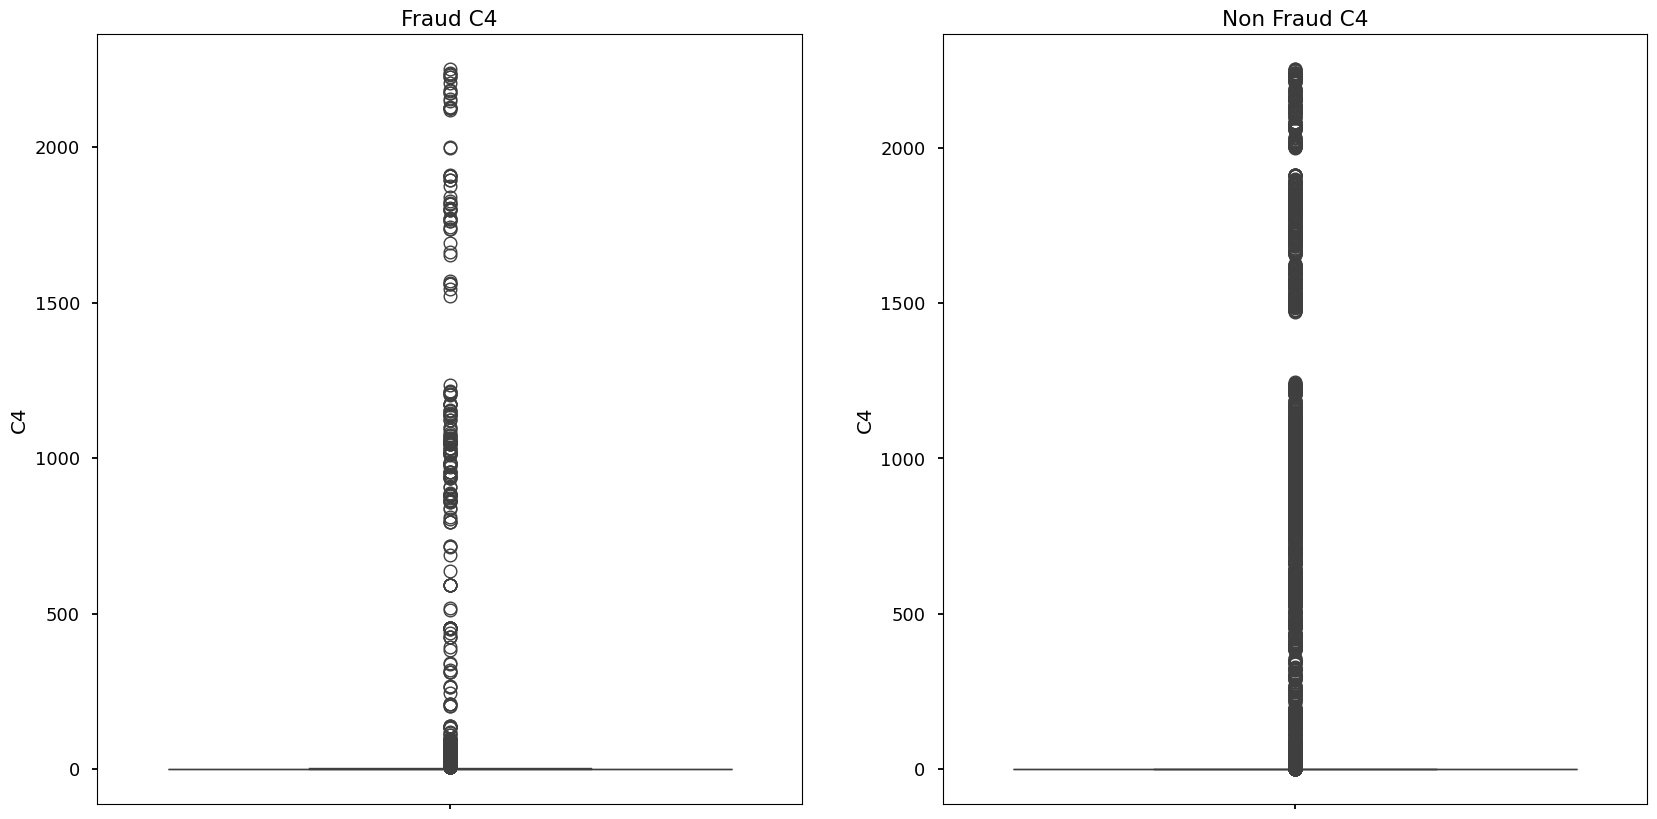

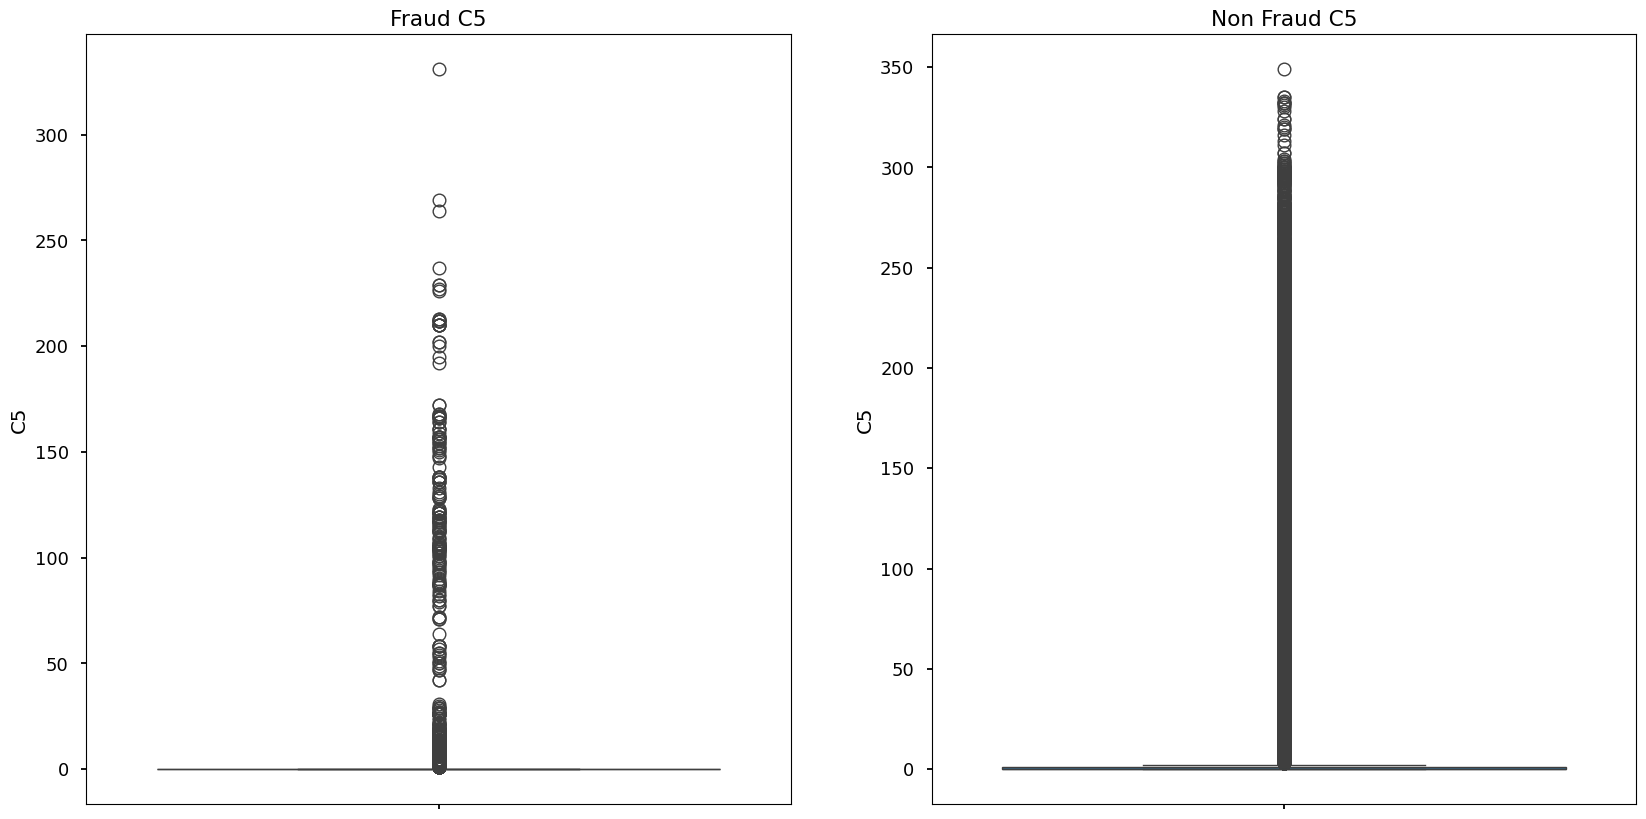

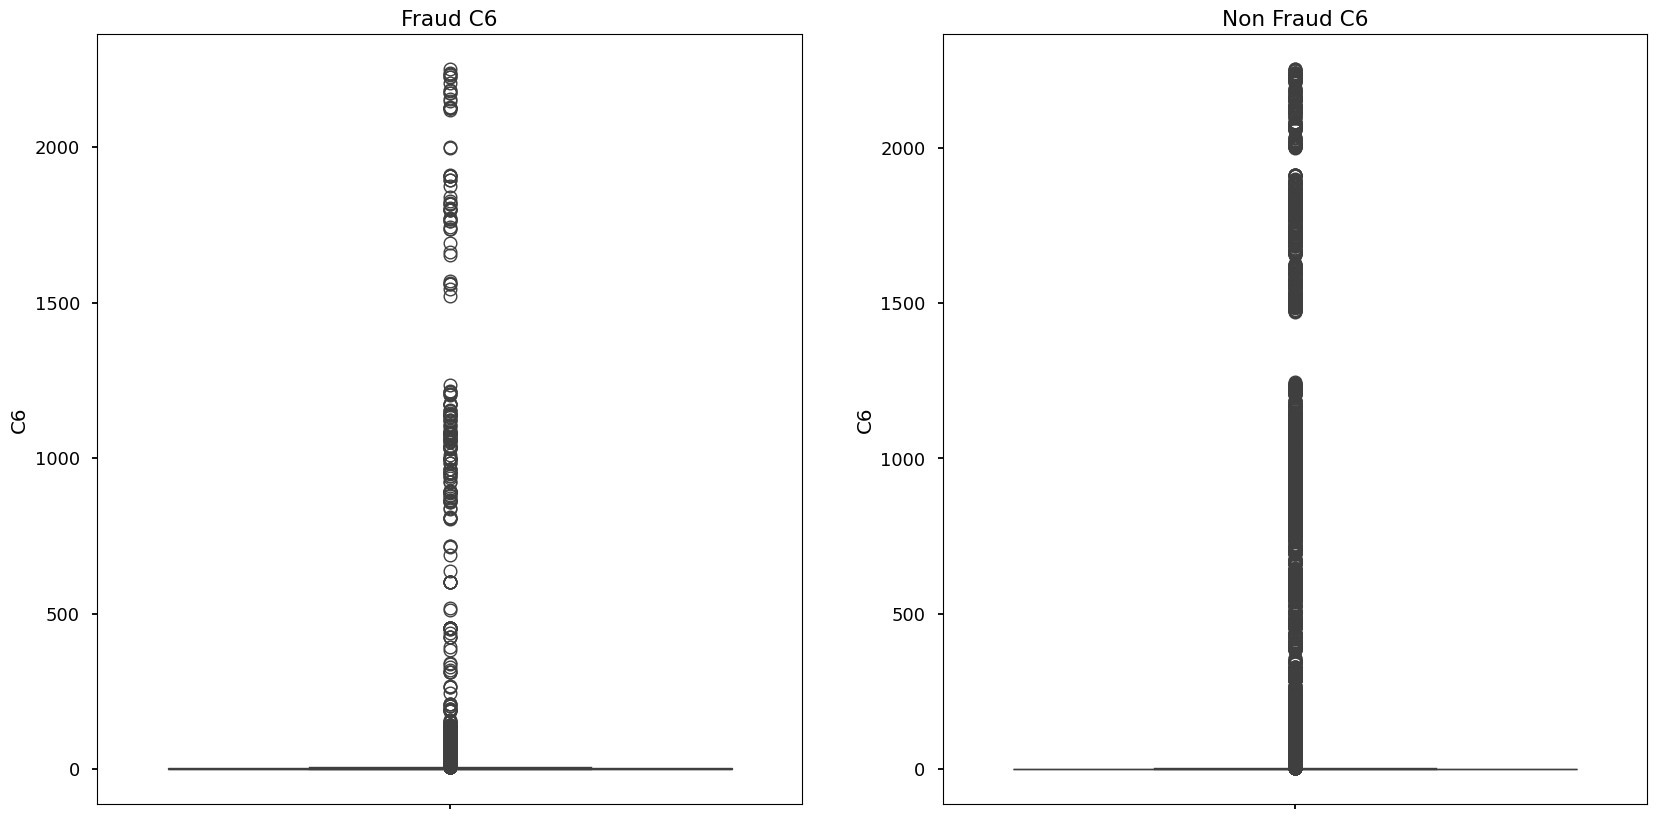

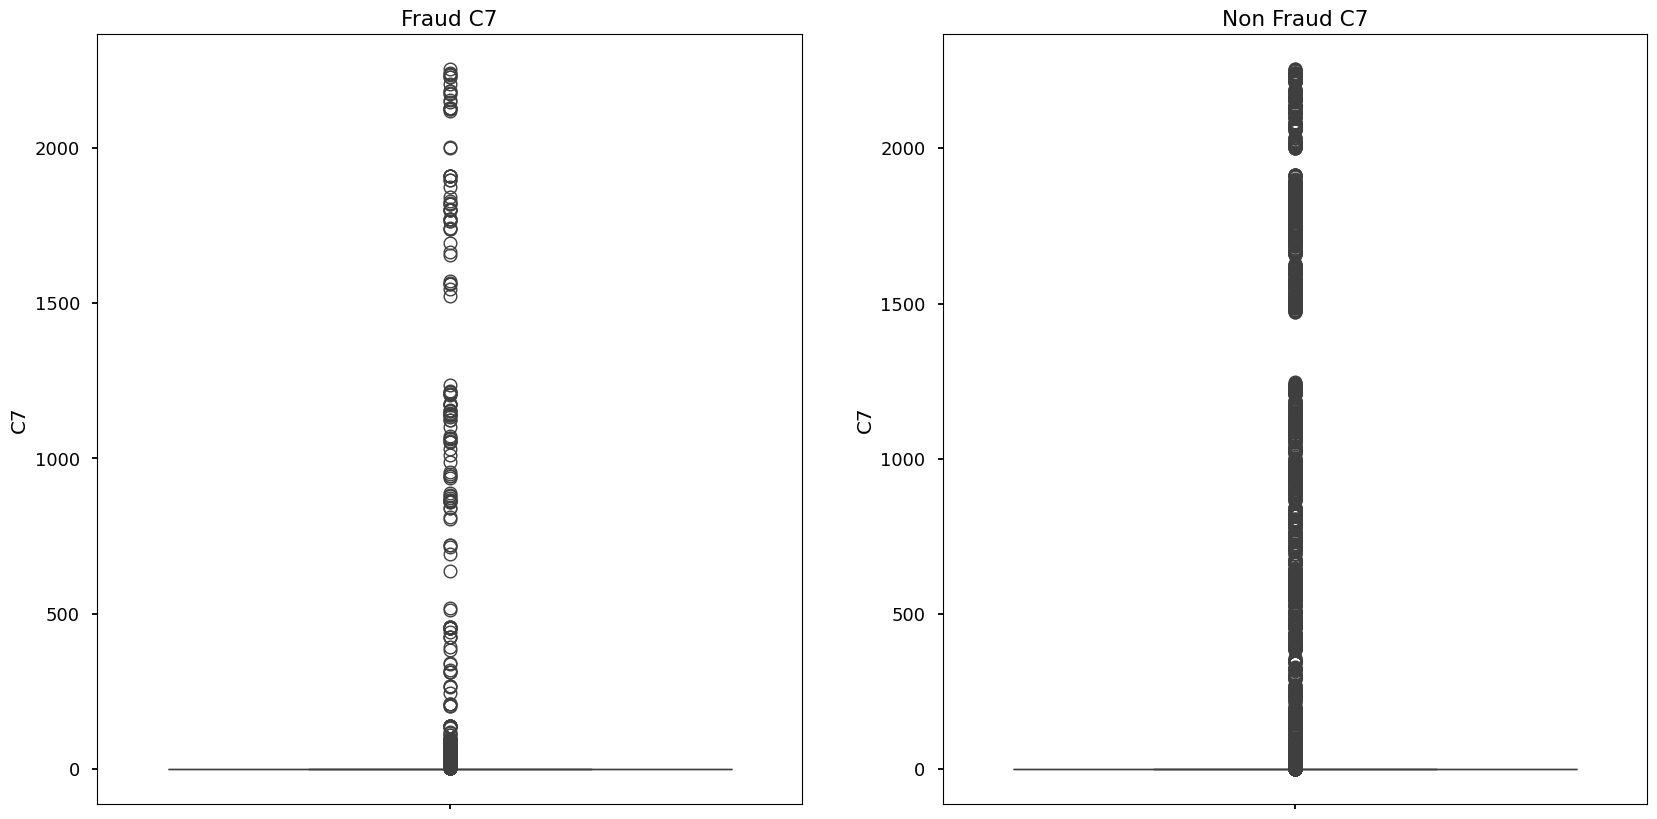

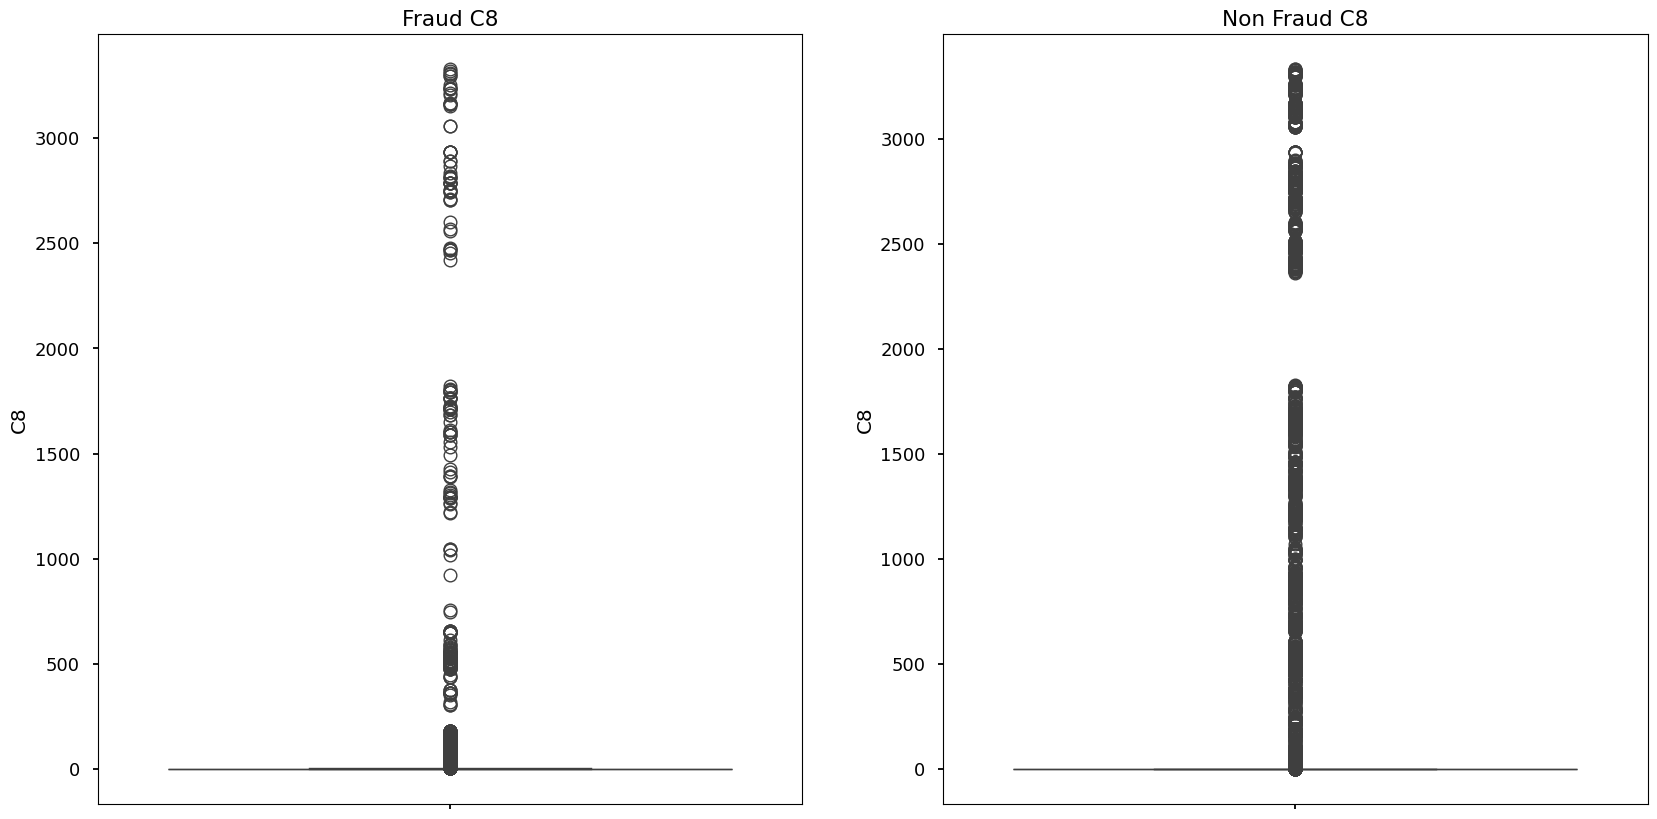

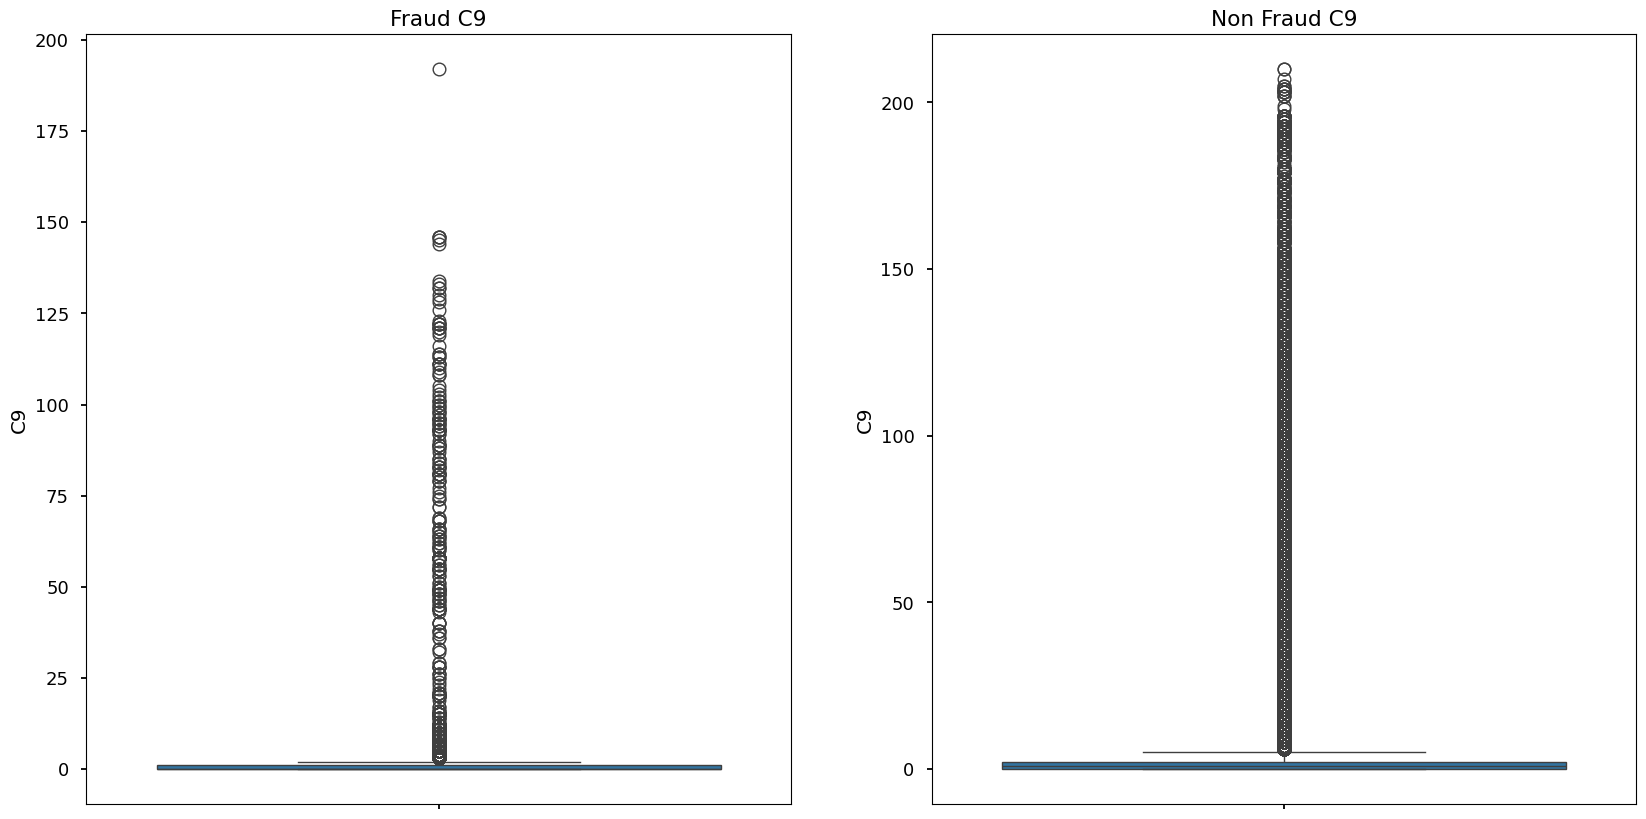

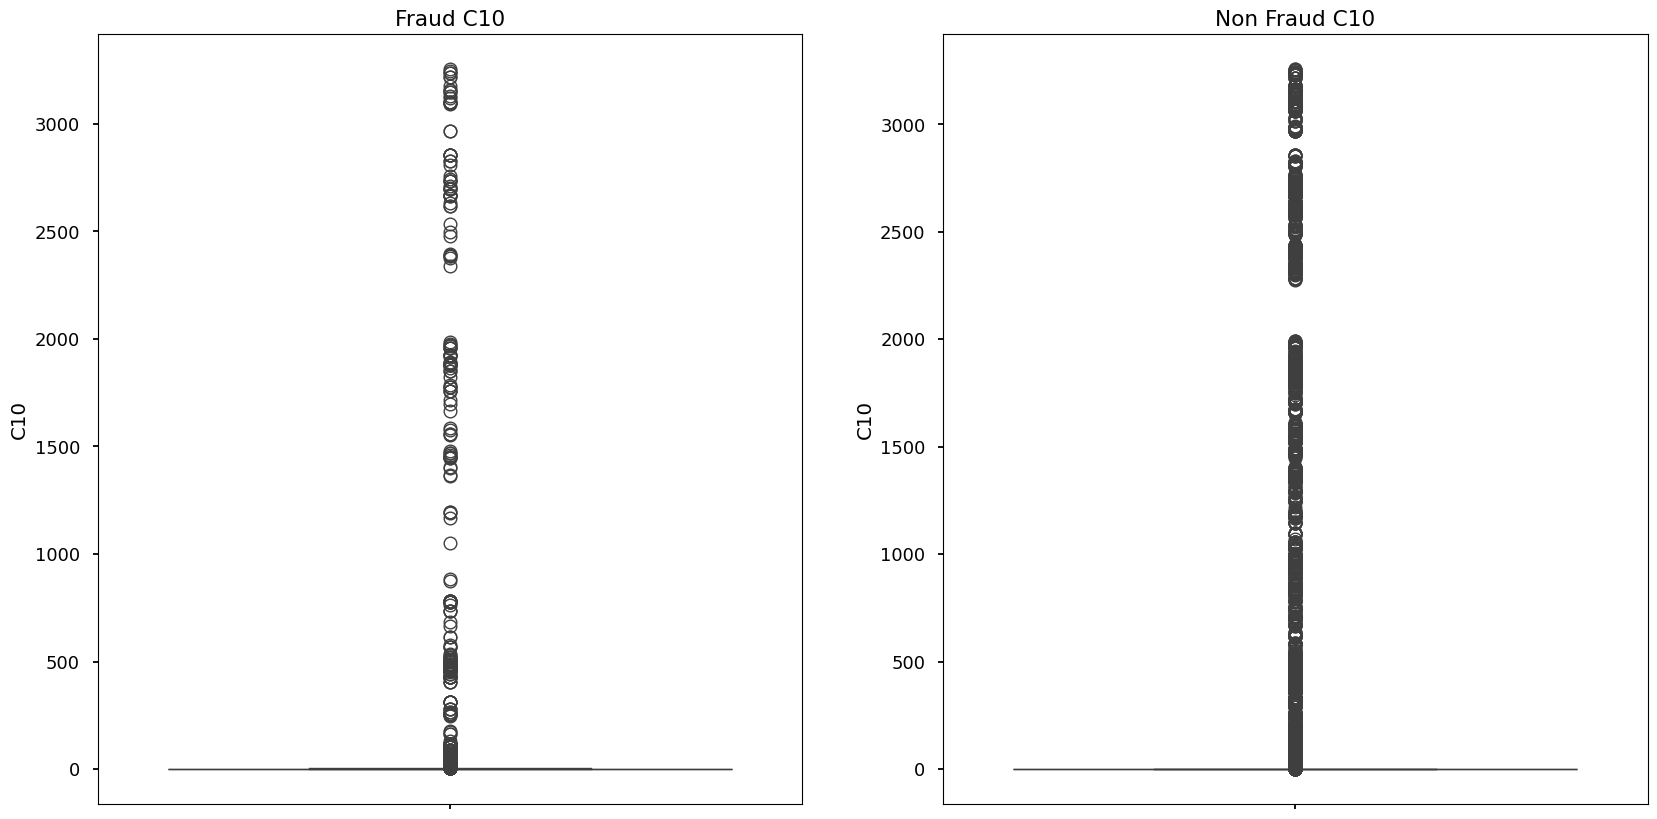

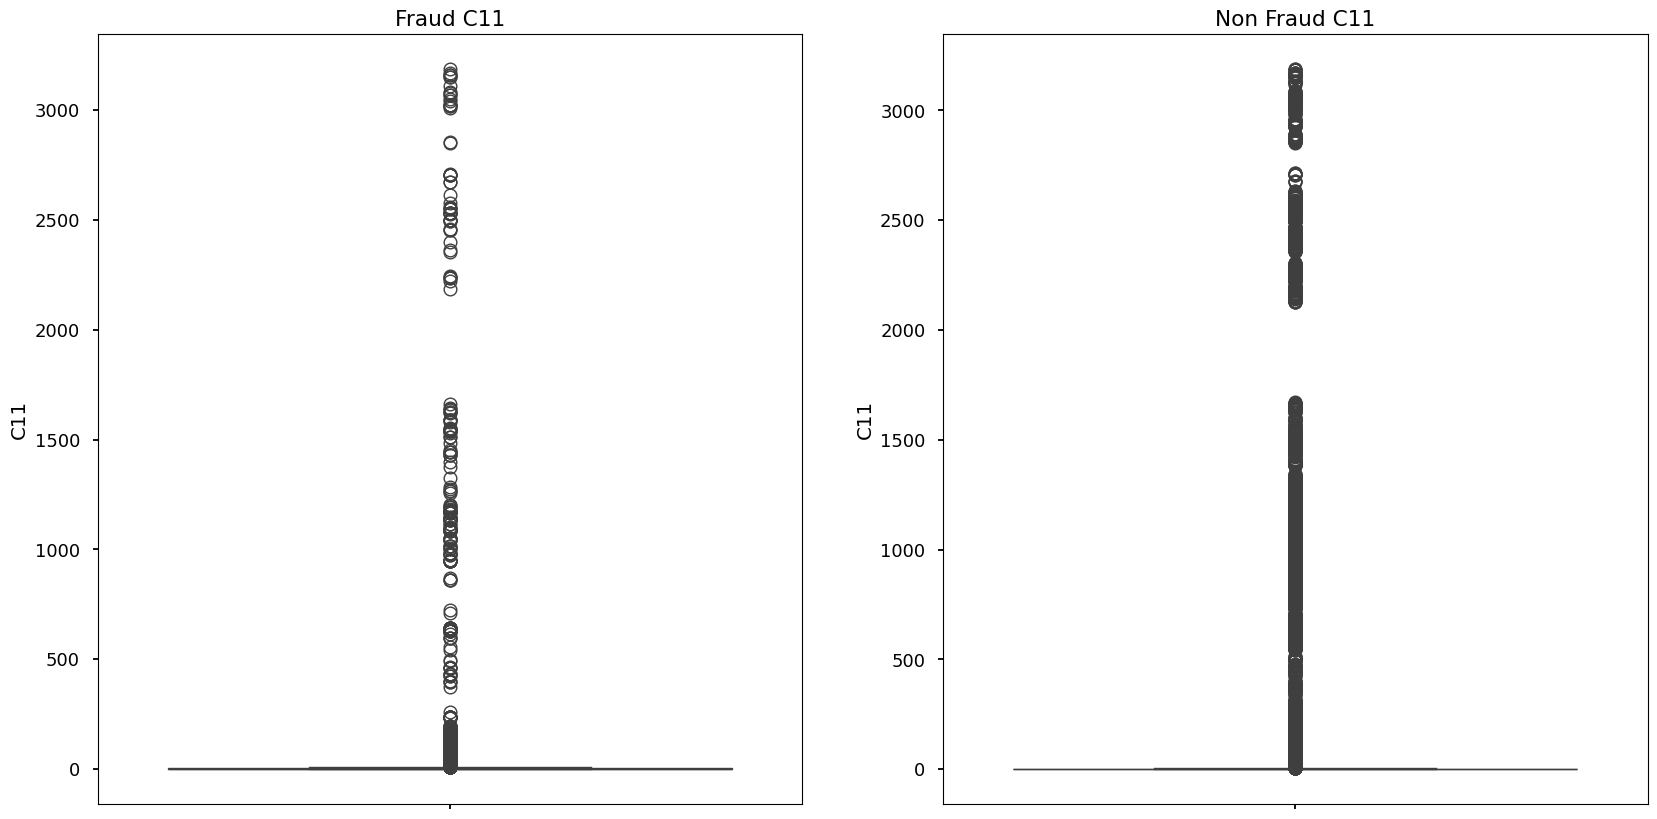

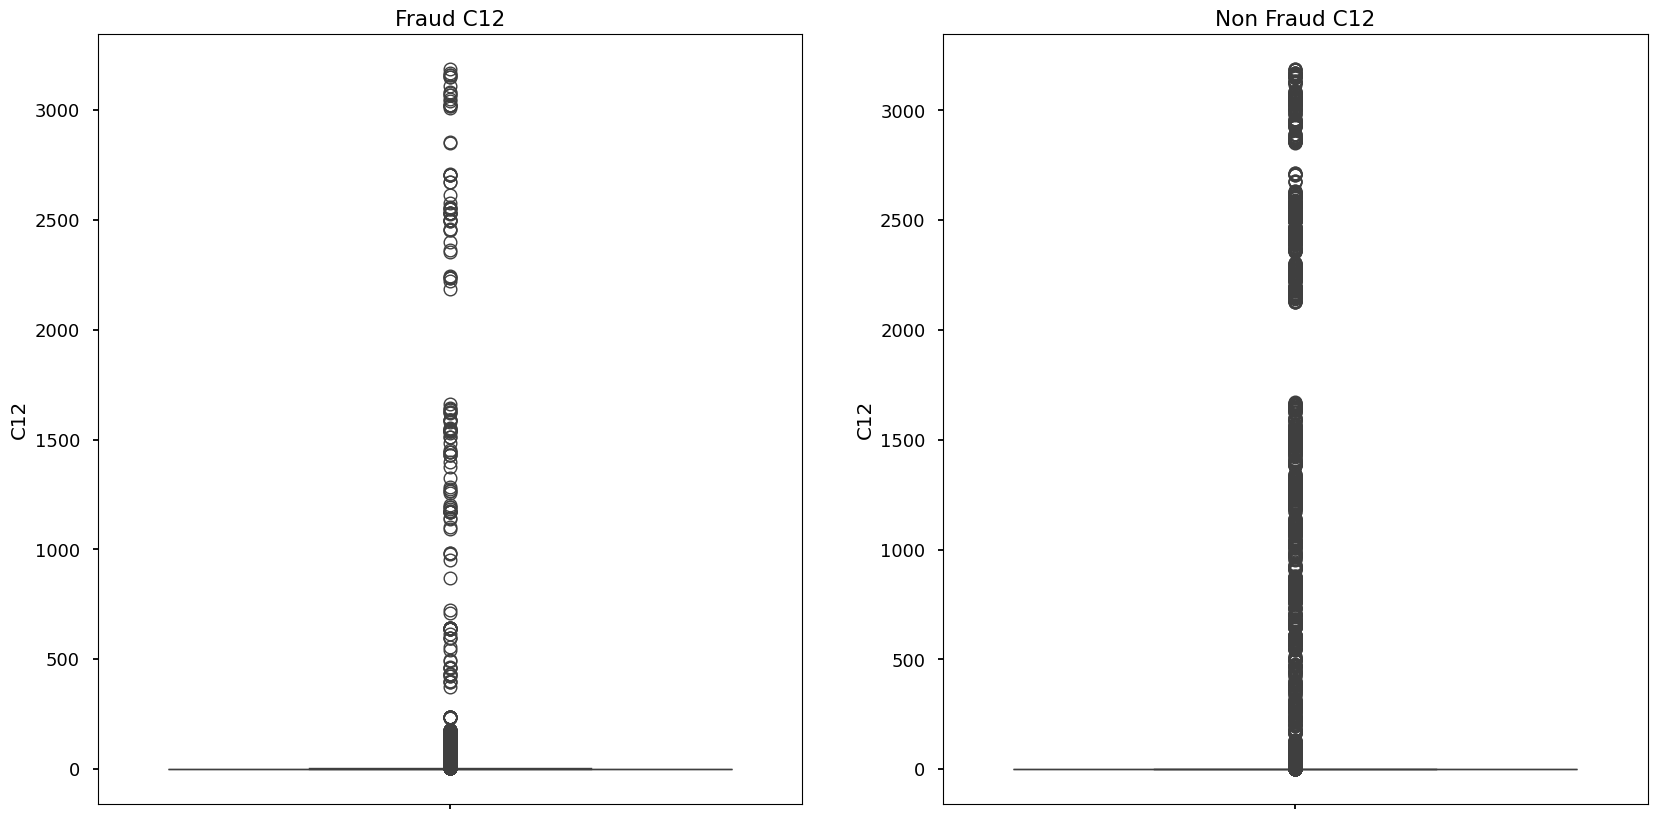

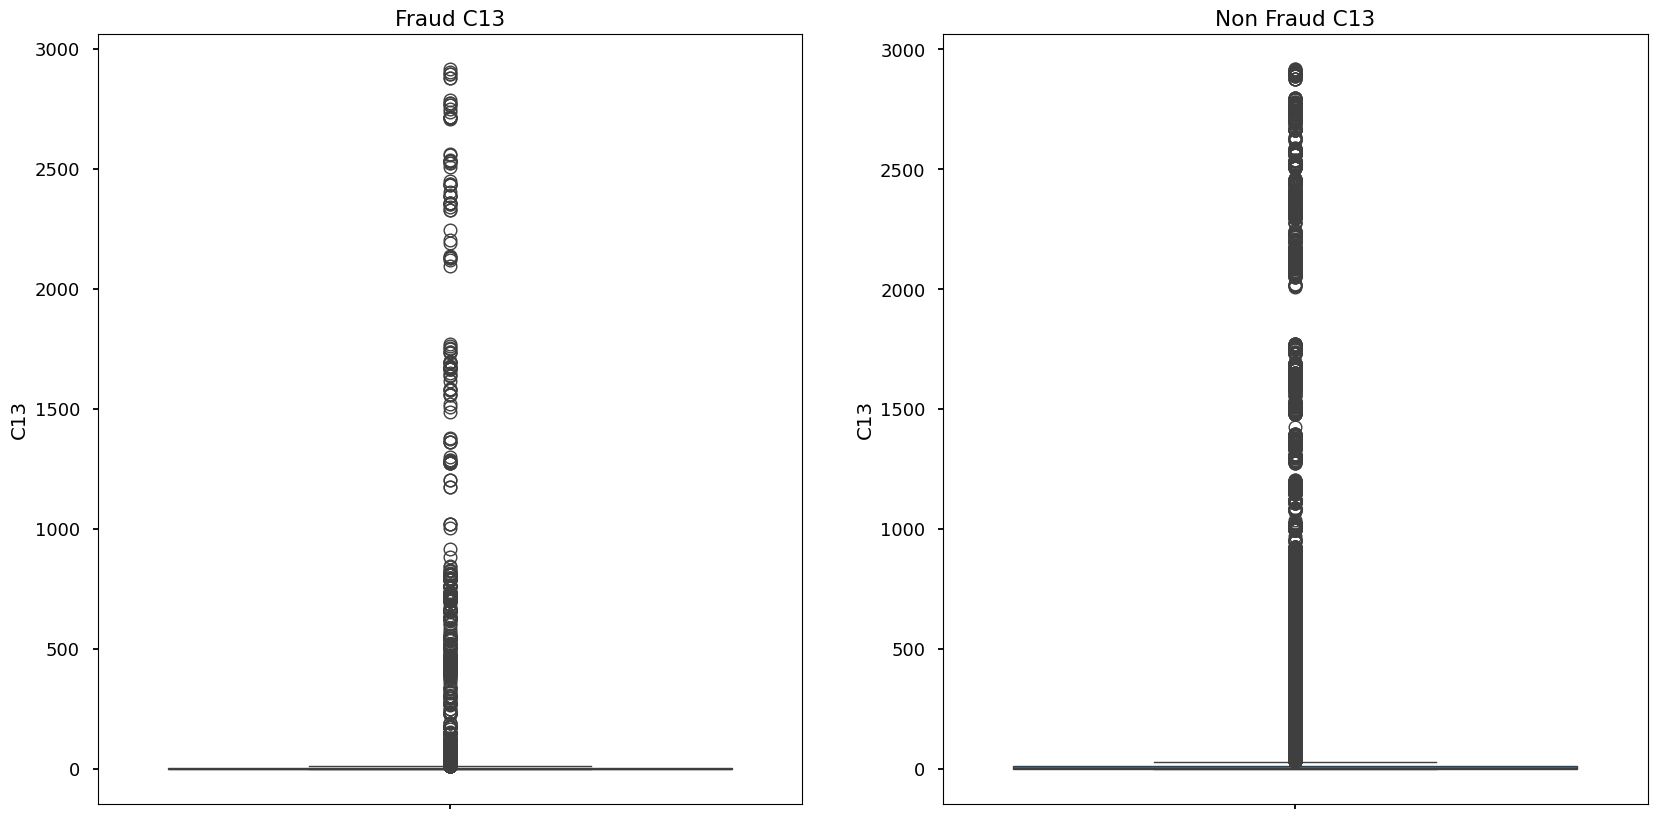

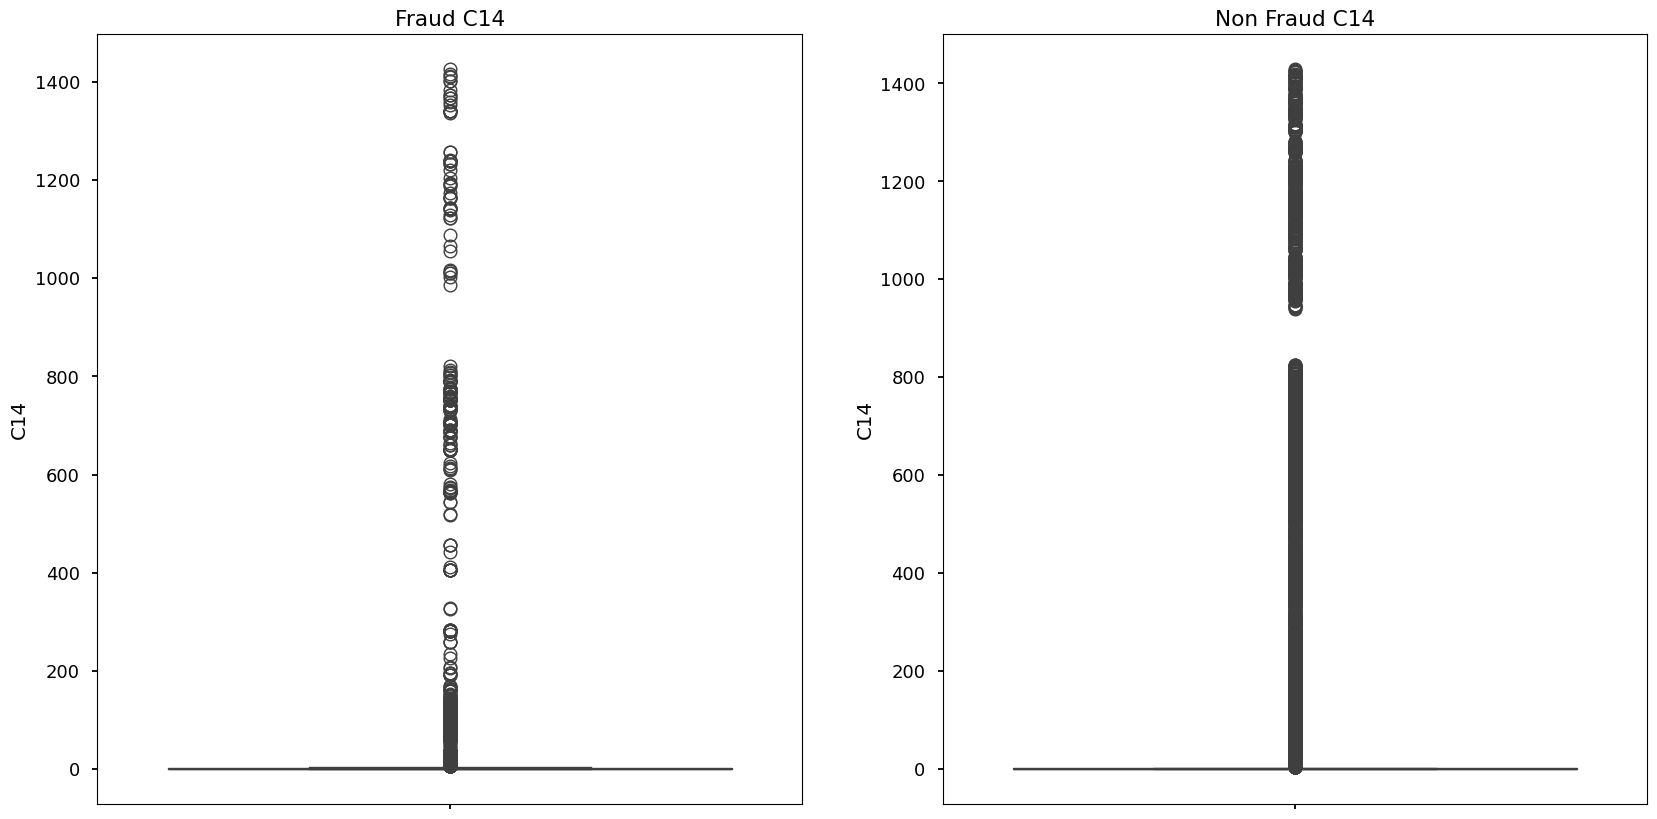

In [47]:
for col in c_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fraud_df = df_train[df_train["isFraud"] == 1]
    nonfraud_df = df_train[df_train["isFraud"] == 0]
    sns.boxplot(fraud_df[col], ax=axes[0])
    sns.boxplot(nonfraud_df[col], ax=axes[1])
    axes[0].title.set_text(f"Fraud {col}")
    axes[1].title.set_text(f"Non Fraud {col}")
    plt.show()

##### D1 - D15
Consists of information like timedelta, such as days between previous transaction, etc.

In [48]:
d_cols = [col for col in df_train.columns if col[0] == "D" and len(col) <= 3]
df_train[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN

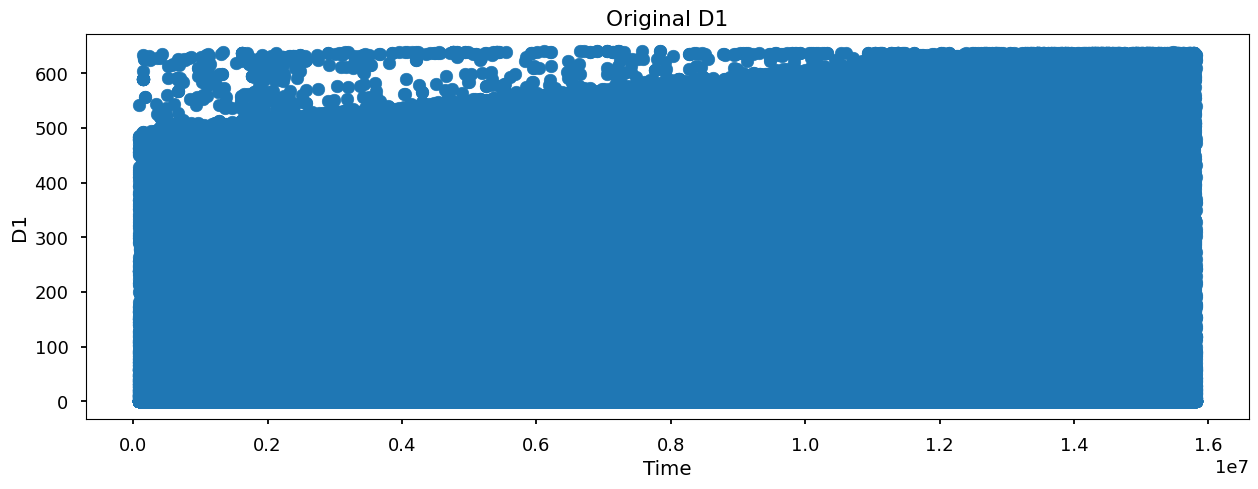

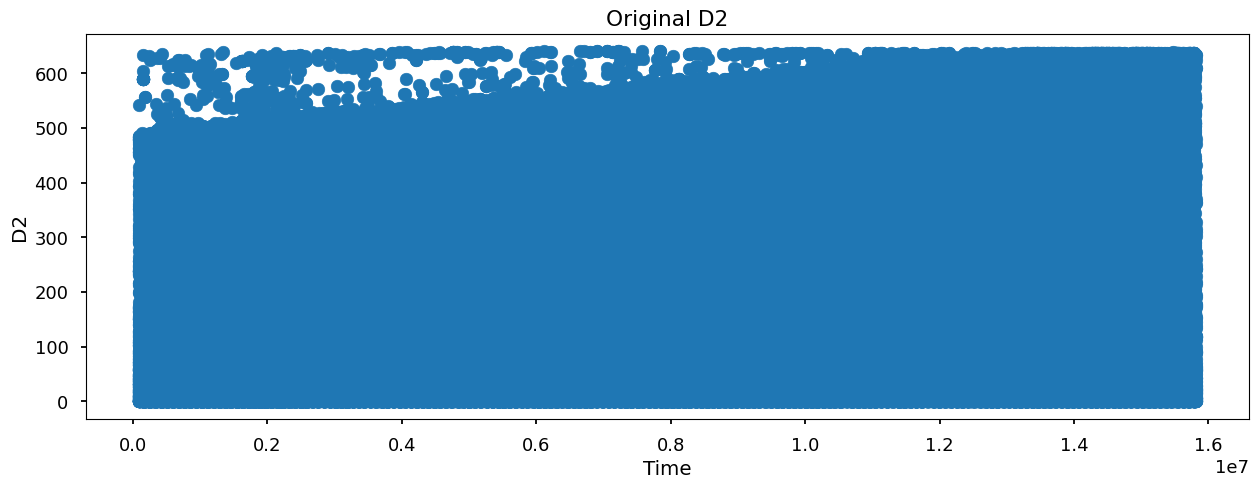

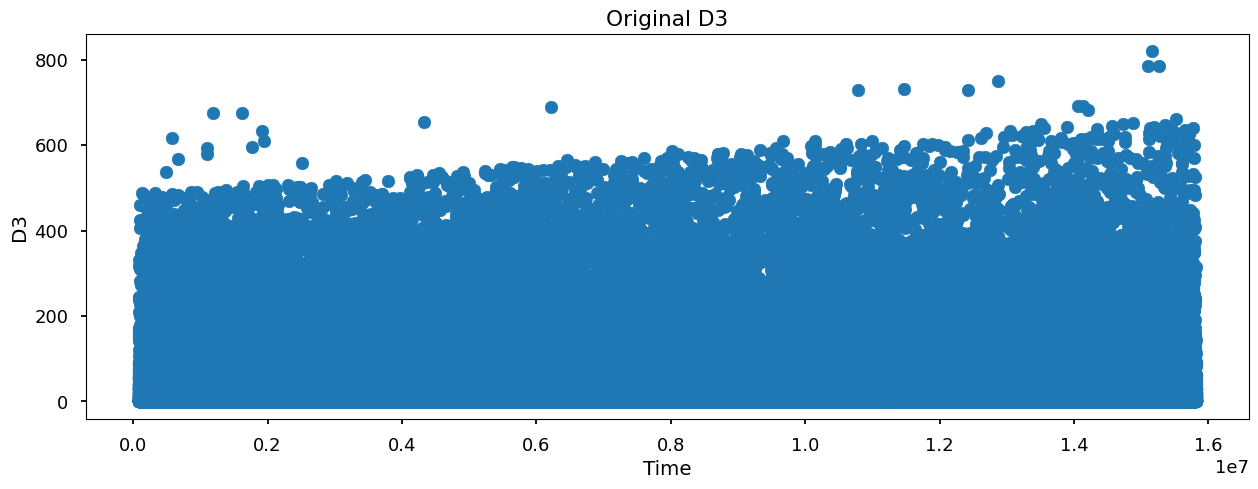

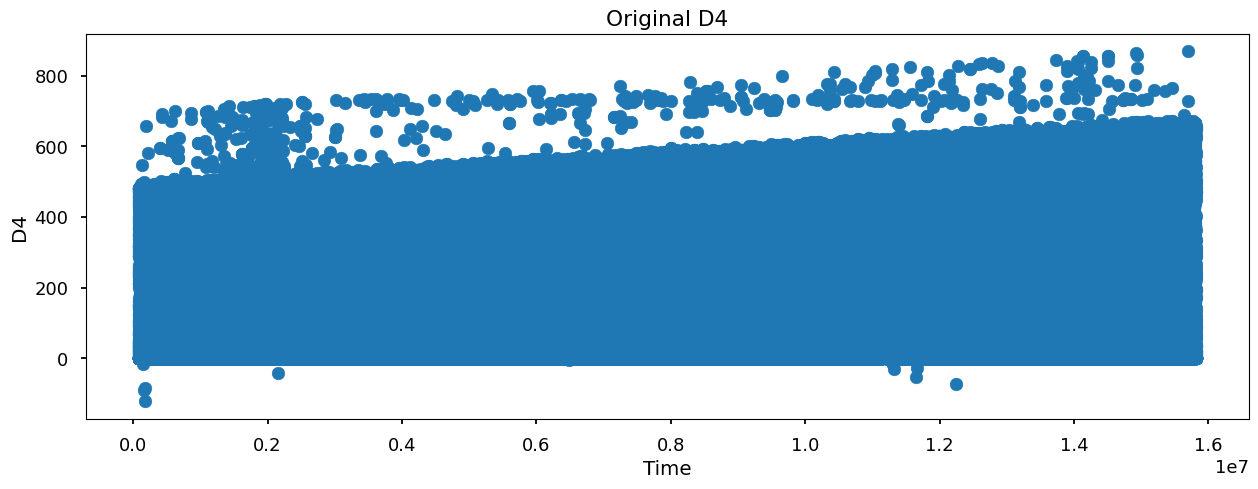

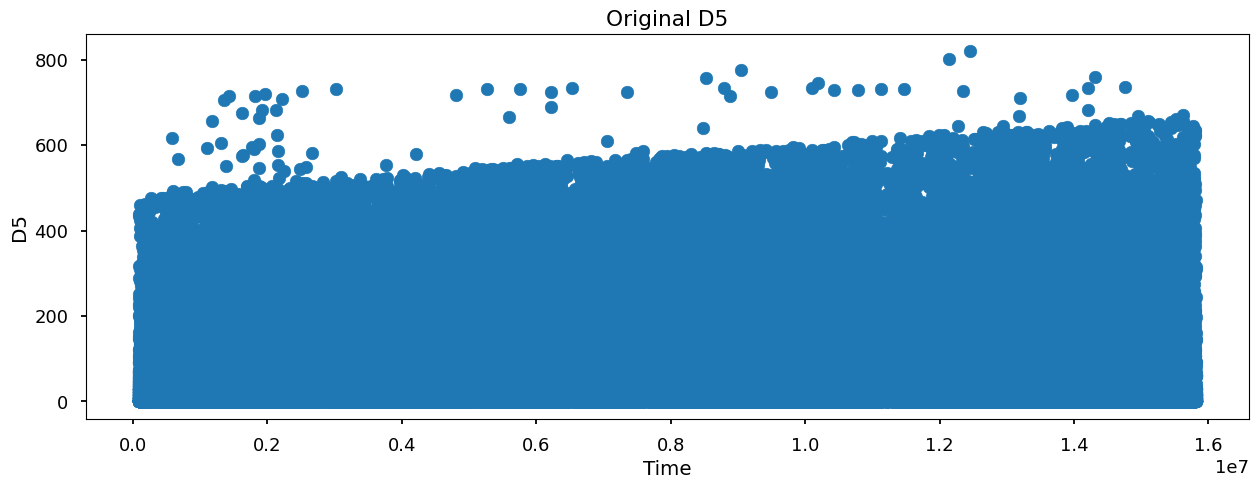

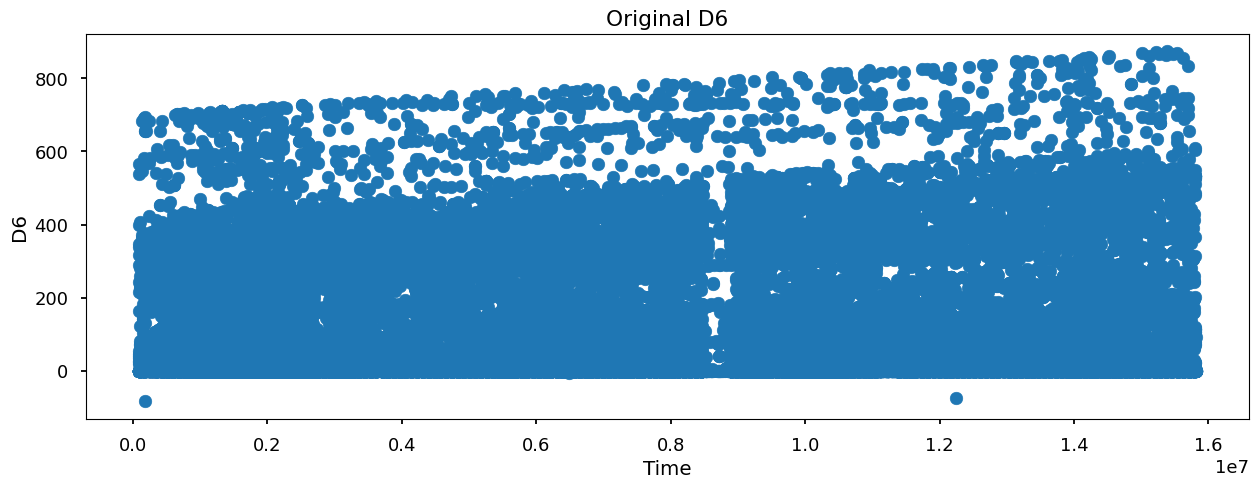

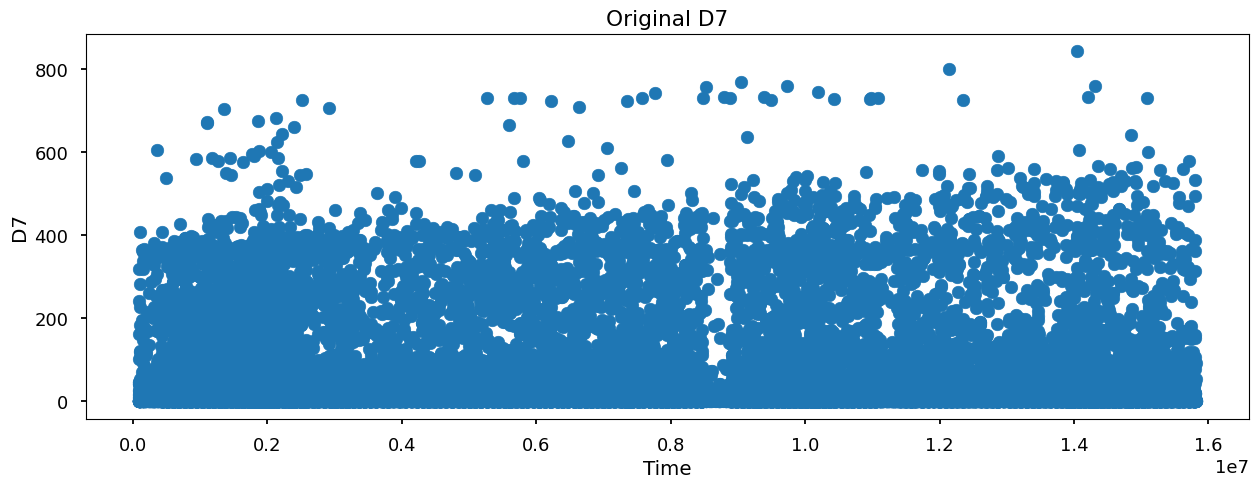

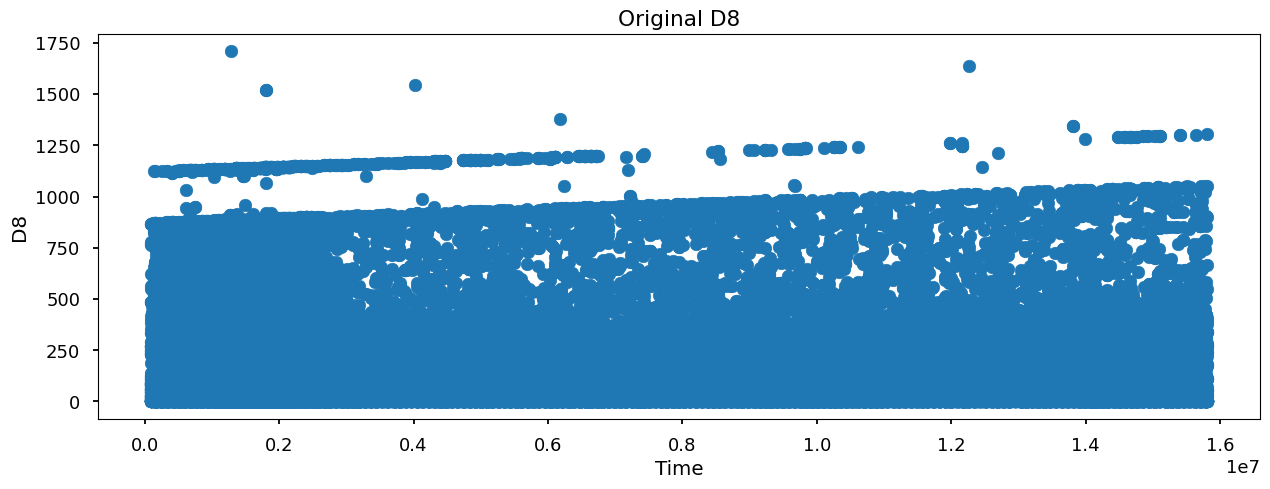

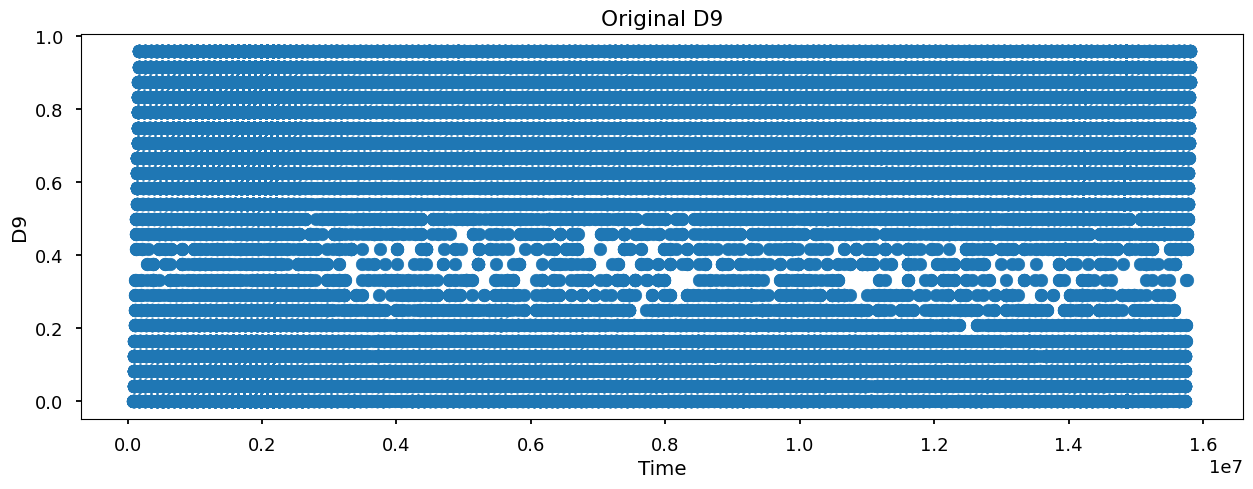

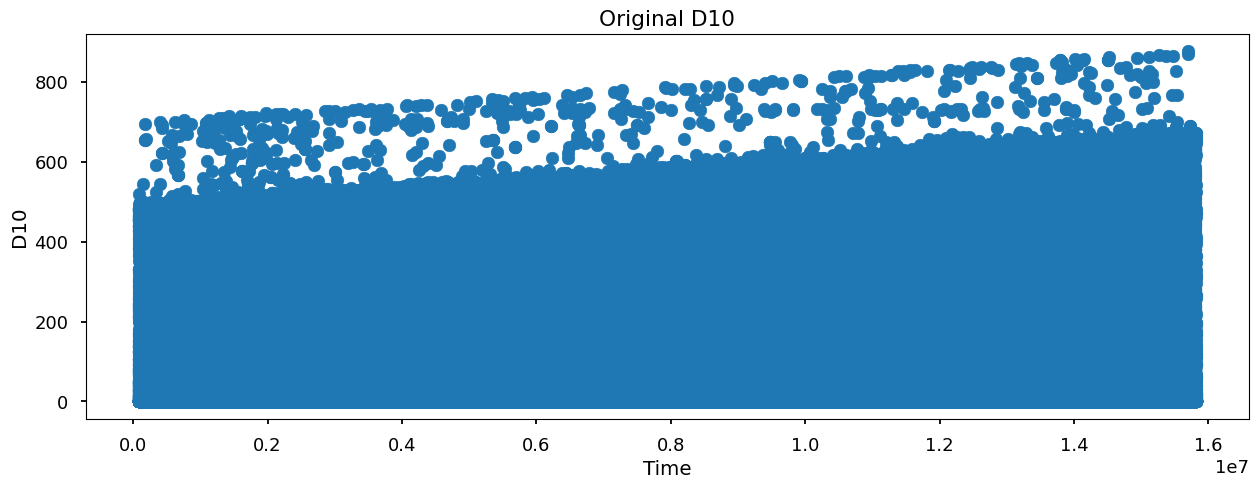

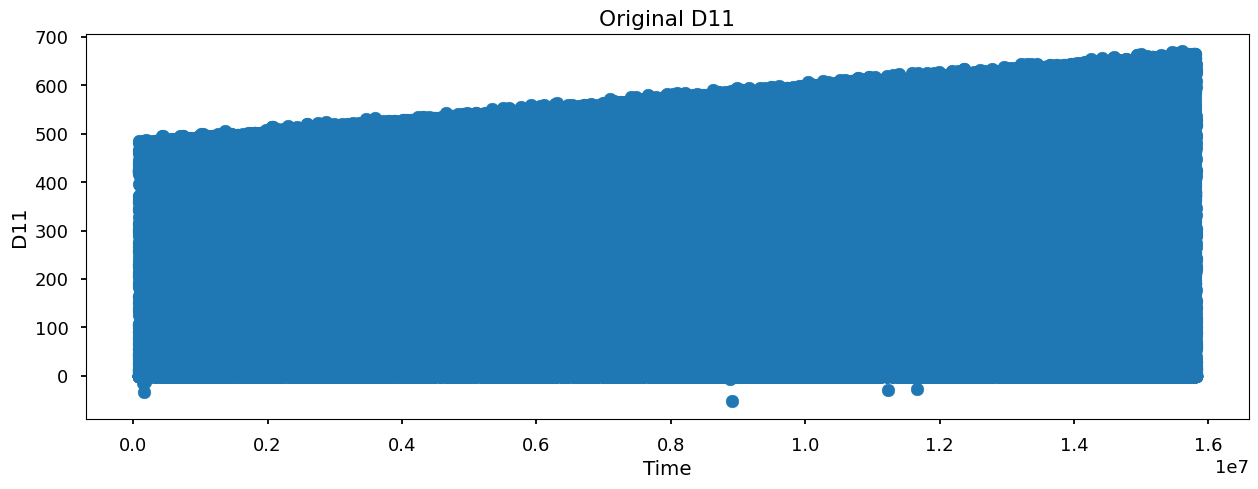

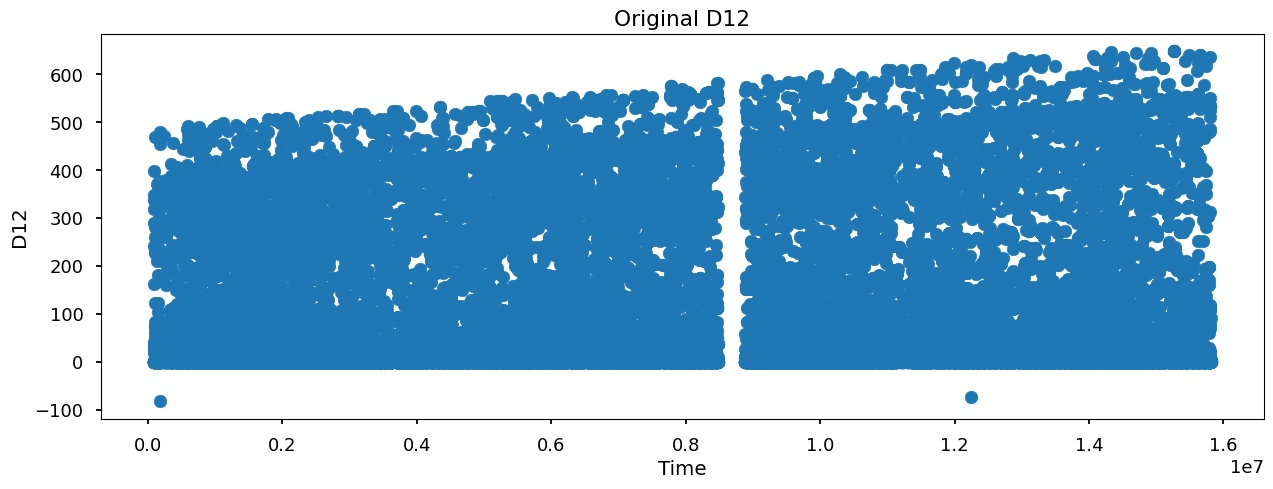

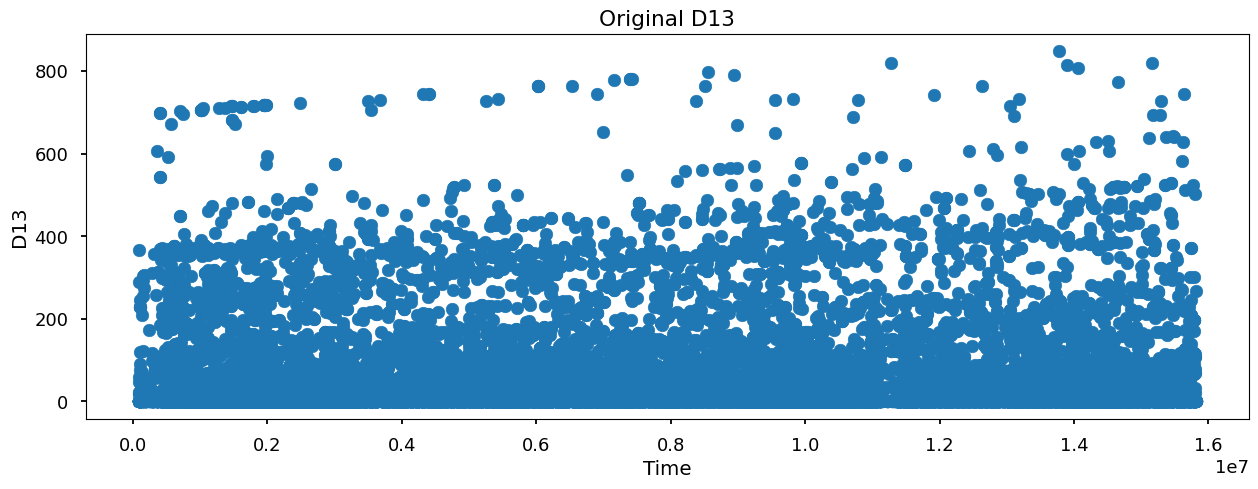

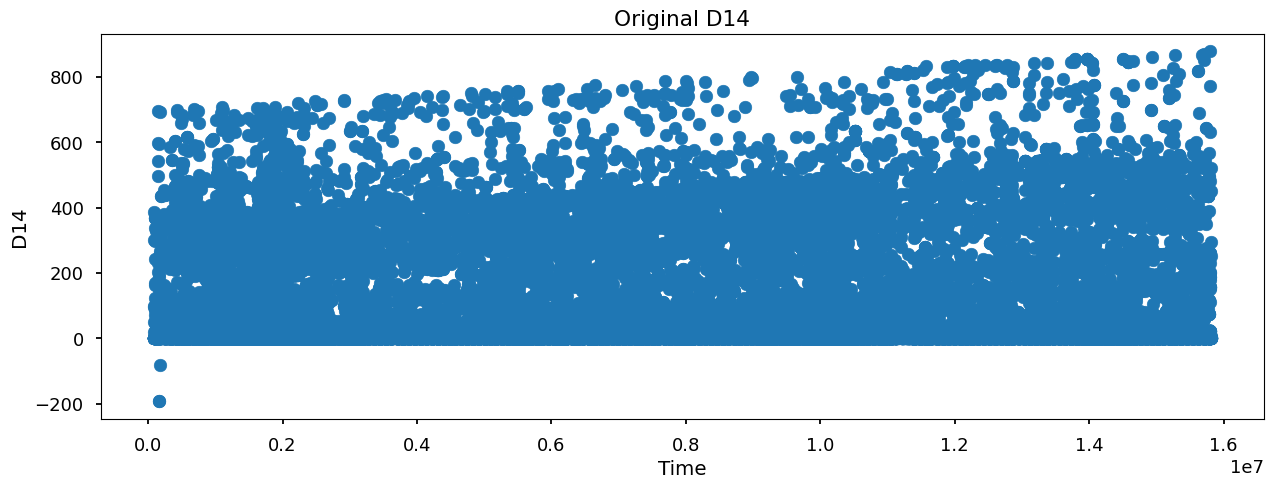

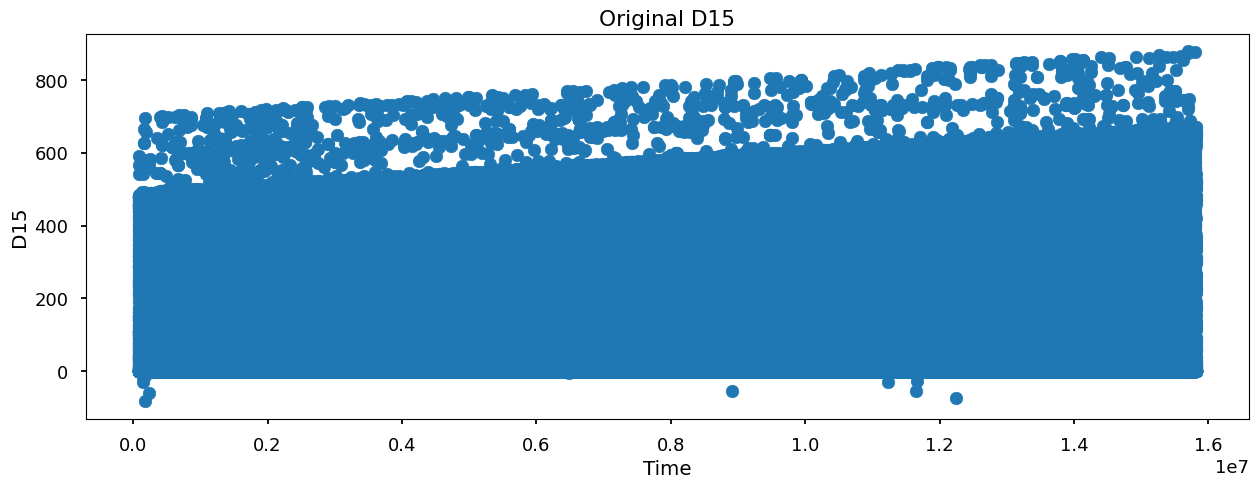

In [49]:
for col in d_cols:
    plt.figure(figsize=(15, 5))
    plt.scatter(df_train["TransactionDT"], df_train[col])
    plt.title(f"Original {col}")
    plt.xlabel("Time")
    plt.ylabel(f"{col}")
    plt.show()

Normalizing D

In [50]:
df_train["D1n"] = df_train["D1"] - df_train.TransactionDT / np.float32(24 * 60 * 60)

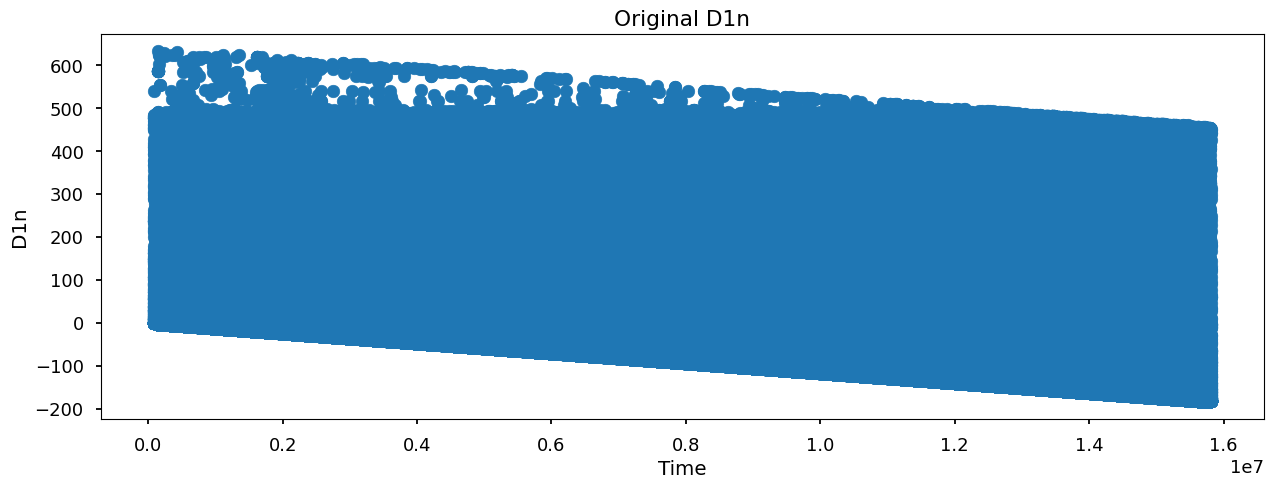

In [51]:
d_cols = ["D1n"]
for col in d_cols:
    plt.figure(figsize=(15, 5))
    plt.scatter(df_train["TransactionDT"], df_train[col])
    plt.title(f"Original {col}")
    plt.xlabel("Time")
    plt.ylabel(f"{col}")
    plt.show()

##### M1 - M9
Match, such as names on card and address, etc.

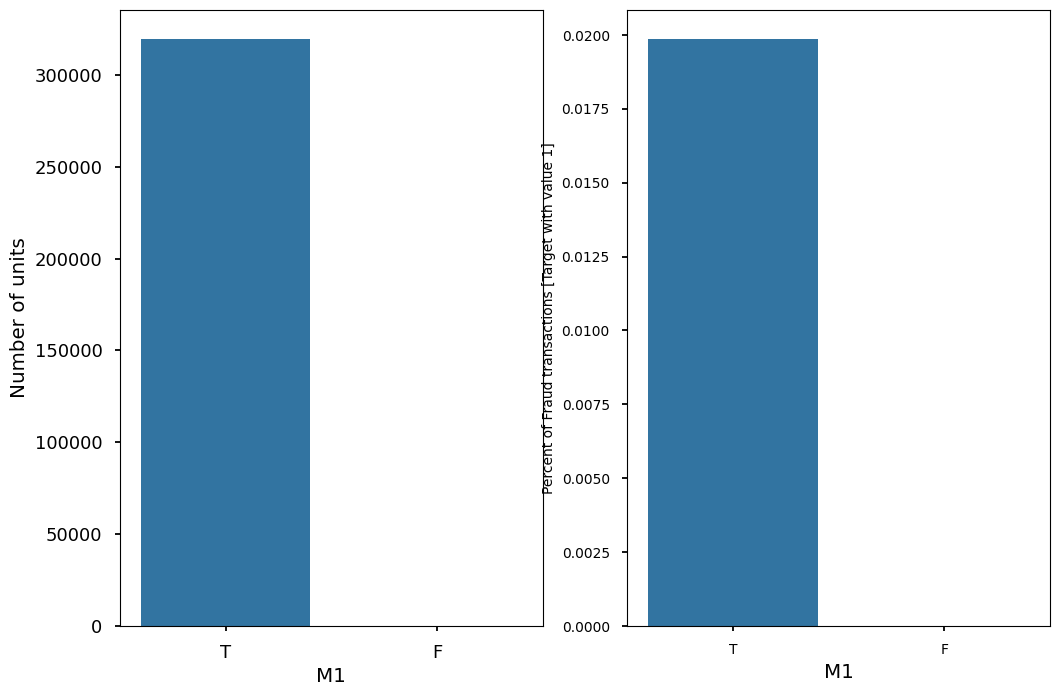

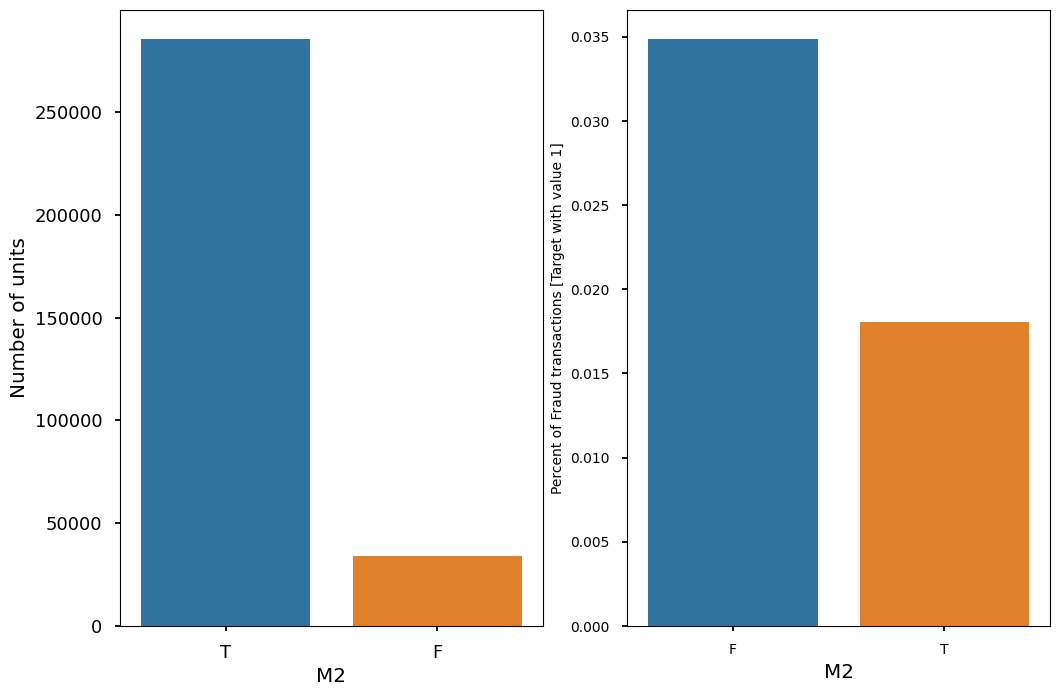

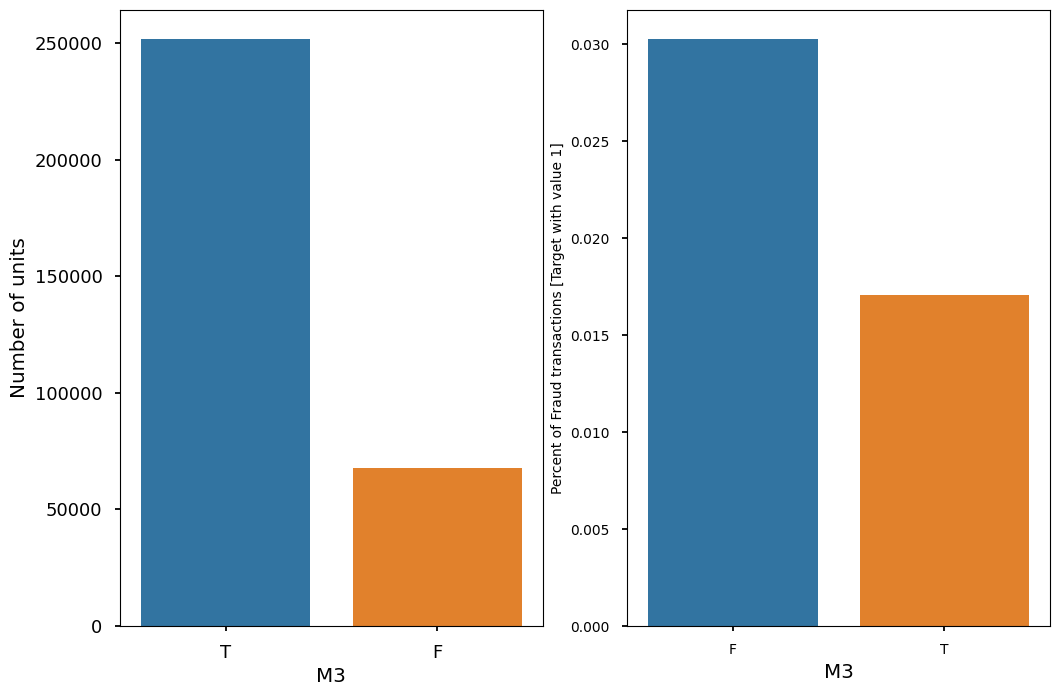

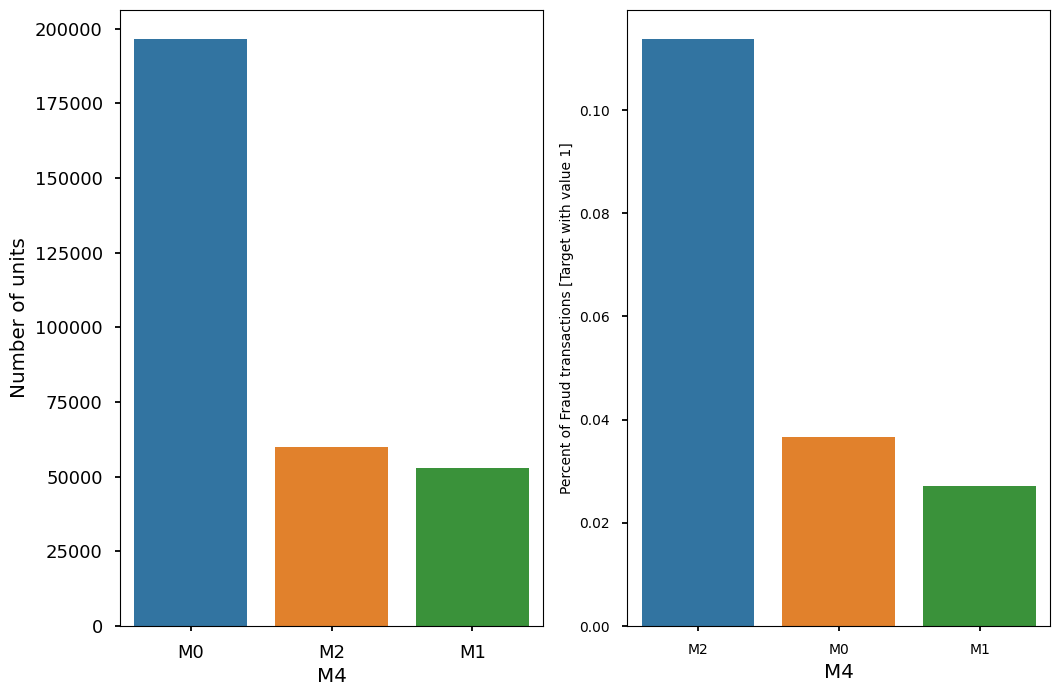

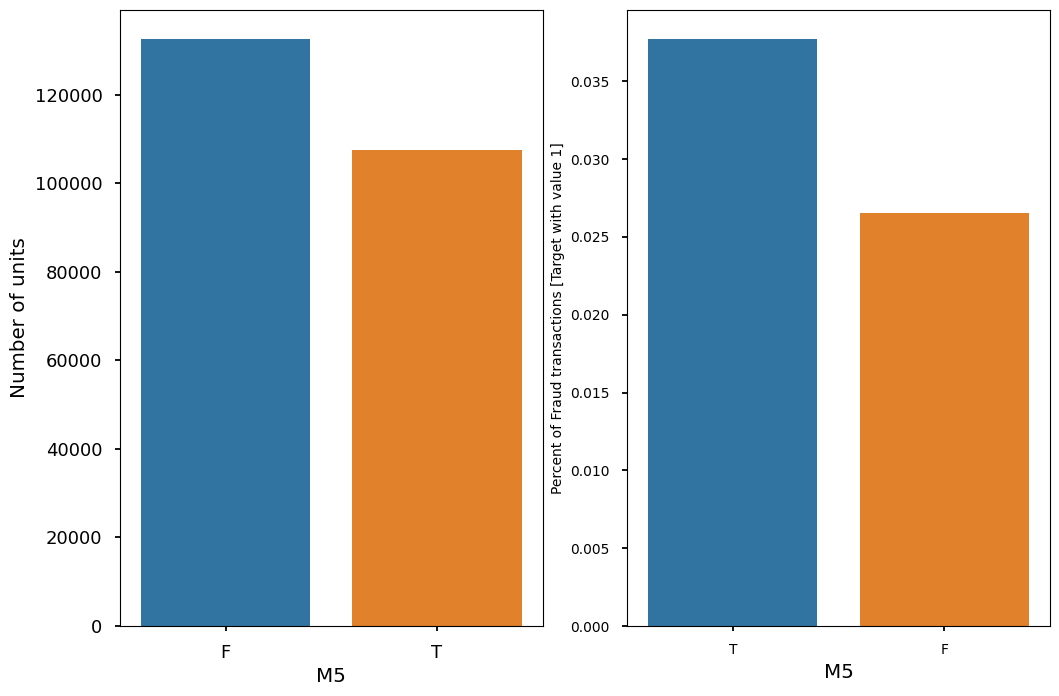

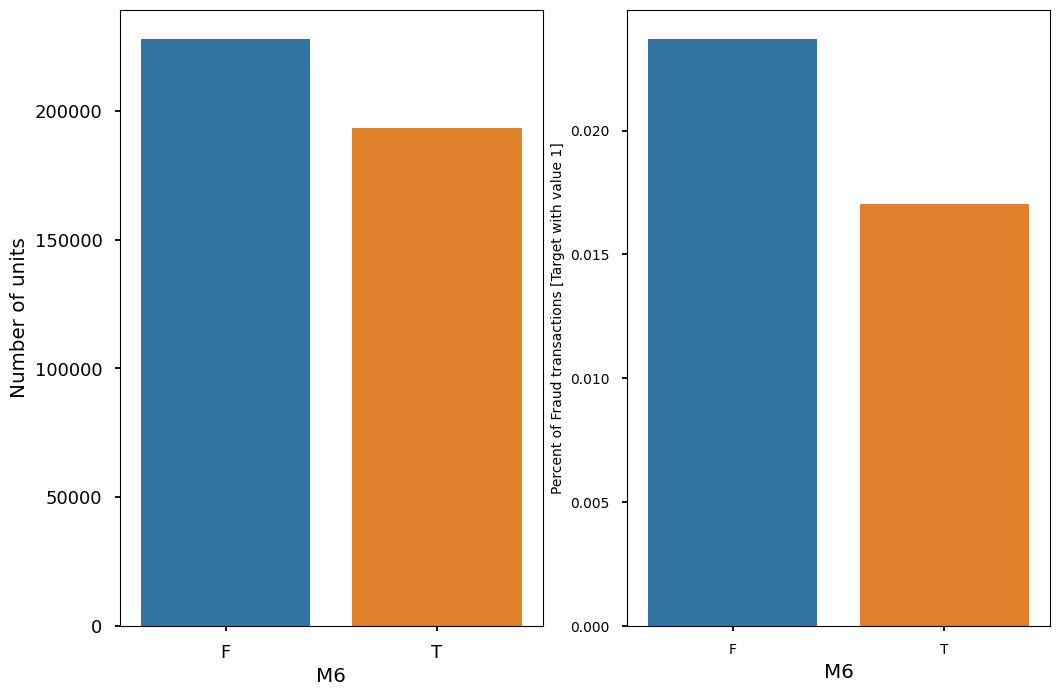

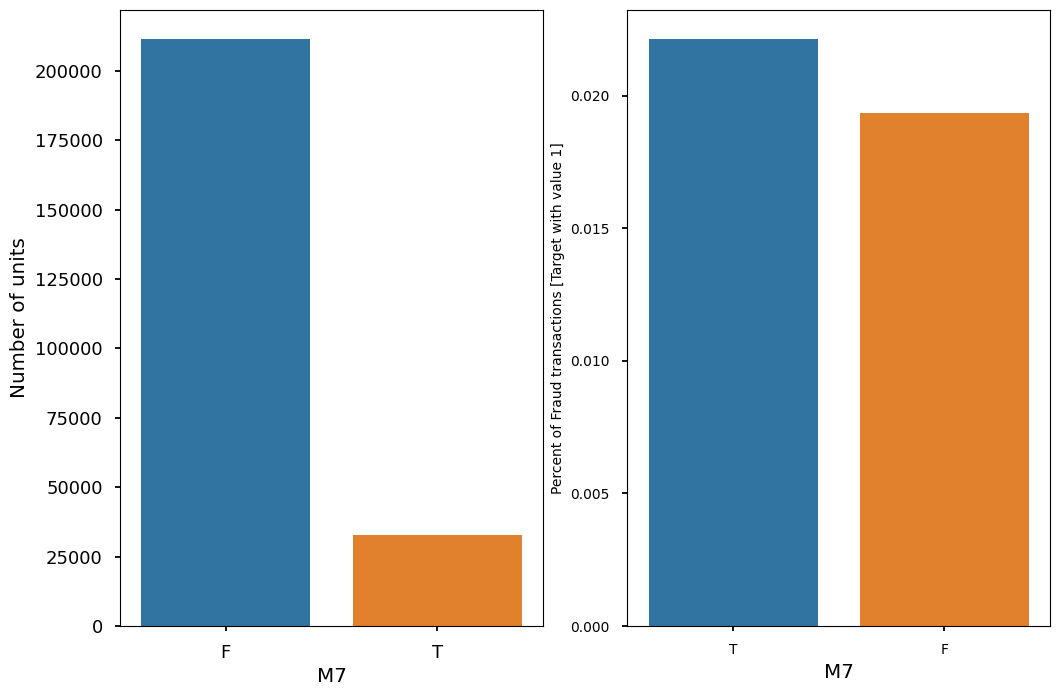

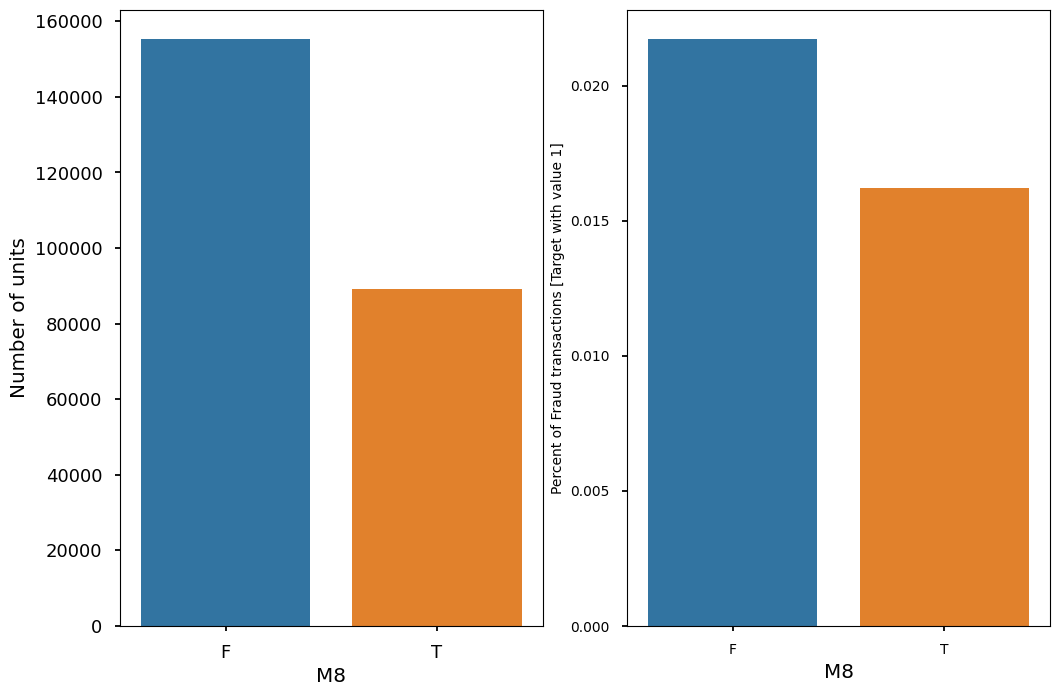

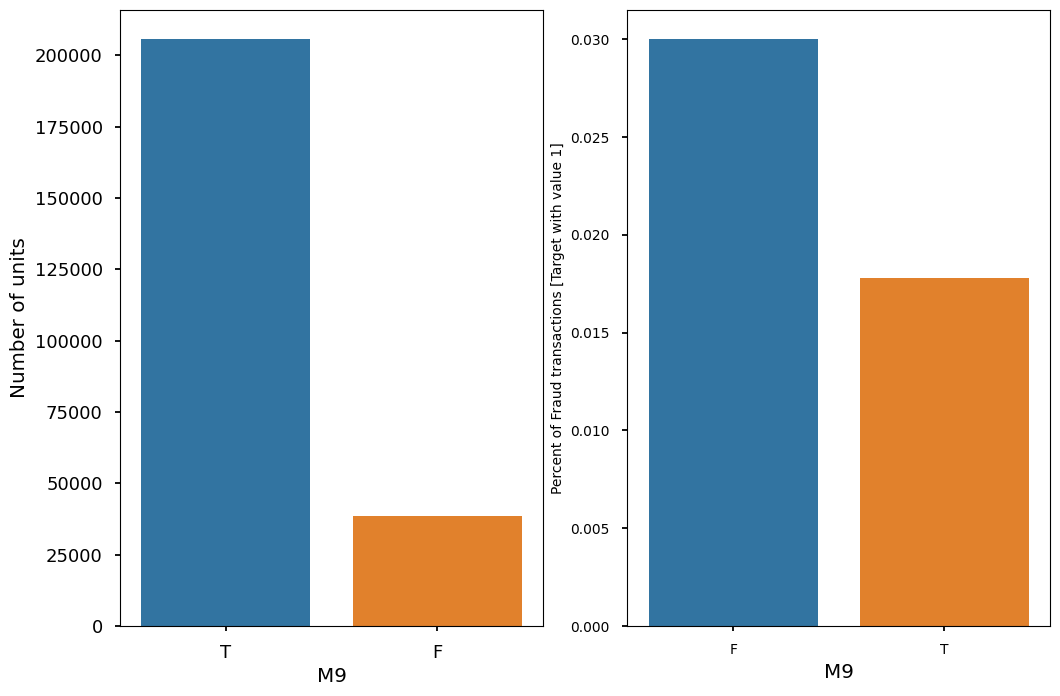

In [52]:
m_cols = [m for m in df_train.columns if m[0] == "M"]

for col in m_cols:
    hor_plot(col)
    plt.show()

Observation:
1. In M1 of all cases of T, 2% are fraudulant
2. In M2 of all cases of F, 3.5% are fraudulant
3. Similiar readings can be obtained from graphs above

##### V1 - V339

In [53]:
v_cols = [c for c in df_train if c[0] == "V"]
df_train[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

In [54]:
df_train[v_cols].describe()

V1             V2             V3             V4  \
count  311251.000000  311251.000000  311251.000000  311251.000000   
mean        0.999945       1.045192       1.078062       0.846449   
std         0.007390       0.240083       0.320854       0.440045   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311251.000000  311251.000000  311251.000000  311251.000000   
mean        0.876984       1.045680       1.072864       1.027698   
std         0.475896       0.239373       0.304771       0.186054   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311251.000000  311251.000000  ...  82351.000000   82351.000000   
mean        1.041523       0.463912  ...      0.775874     721.741883   
std         0.226326       0.521522  ...      4.727971    6217.223583   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

##### Device Type

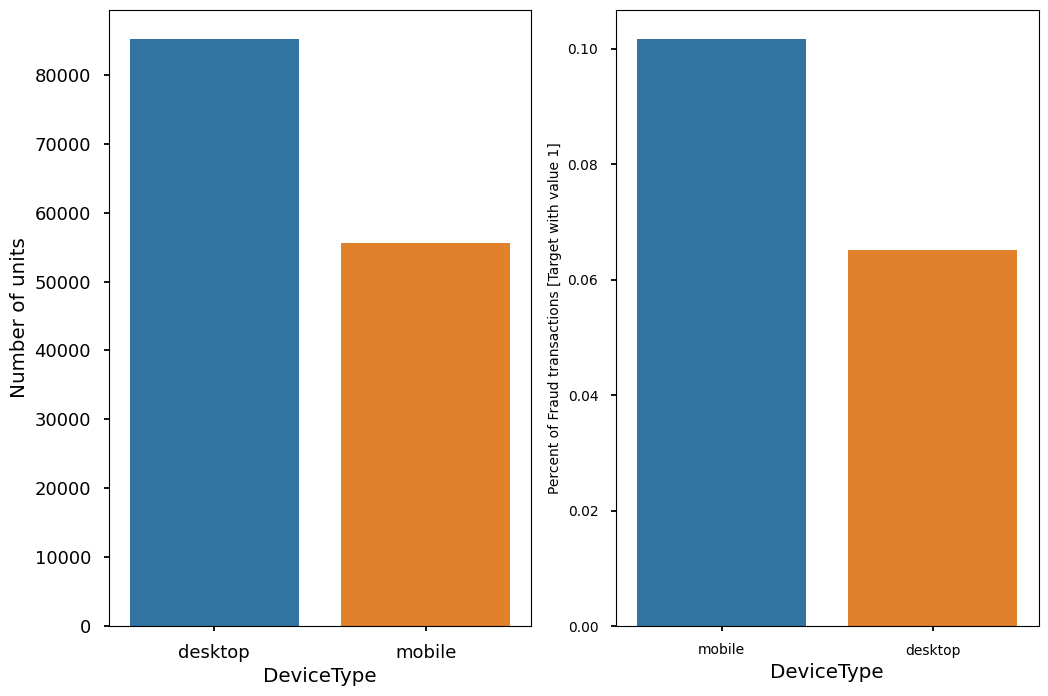

In [55]:
hor_plot("DeviceType", df_train)

Observation:
1. Fraud transactions are mostly made on mobile, which is approximately 10% and 6.2% in desktop transactions.

##### Device Info

In [56]:
Device_Info = (
    df_train[["DeviceInfo", "isFraud"]]
    .groupby(by=["DeviceInfo"])
    .mean()
    .sort_values(by="isFraud", ascending=False)
)
print(Device_Info[Device_Info["isFraud"] > 0.9].shape)
Device_Info[Device_Info["isFraud"] > 0.9]

(49, 1)


isFraud
DeviceInfo                            
rv:14.0                       1.000000
rv:29.0                       1.000000
ZEIA8                         1.000000
iPhone                        1.000000
ZTE-Z956                      1.000000
Z965 Build/NMF26V             1.000000
ZTE-Z835                      1.000000
Z813 Build/LMY47O             1.000000
XT1021                        1.000000
VS5012 Build/NRD90M           1.000000
TAB7                          1.000000
XT1033                        1.000000
XT890 Build/9.8.2I-50_SML-25  1.000000
XT1609                        1.000000
Z835 Build/NMF26V             1.000000
SM-T530                       1.000000
SM-G955F                      1.000000
A466BG                        1.000000
A574BL Build/NMF26F           1.000000
SM-A300M Build/KTU84P         1.000000
SAMSUNG-SM-N900A              1.000000
A5002                         1.000000
SM-G850M                      1.000000
SM-G615F                      1.000000
SM-N920A Build/MMB29K         1.000000
SM-G925T Build/LMY47X         1.000000
SM-G928F                      1.000000
SM-J700T Build/MMB29K         1.000000
SM-T217S Build/KOT49H         1.000000
SM-T285M                      1.000000
RNE-L23 Build/HUAWEIRNE-L23   1.000000
RCT6203W46 Build/KOT49H       1.000000
LGLK430                       1.000000
LG-D693n Build/KOT49I.V10a    1.000000
Hisense E51 Build/LMY47V      1.000000
G3123 Build/40.0.A.6.175      1.000000
Beat                          1.000000
Blade L3 Build/KOT49H         1.000000
Dream                         1.000000
Alumini3 Build/MRA58K         1.000000
Mi                            1.000000
NOKIA                         1.000000
Nexus 6 Build/MOB30M          1.000000
MotoG3-TE Build/MPD24.65-33   1.000000
N9560 Build/NMF26F            1.000000
NX785QC8G                     1.000000
hi6210sft Build/MRA58K        0.947368
Lenovo YT3-850M Build/MMB29M  0.909091
TR10CS1 Build/JDQ39           0.909091

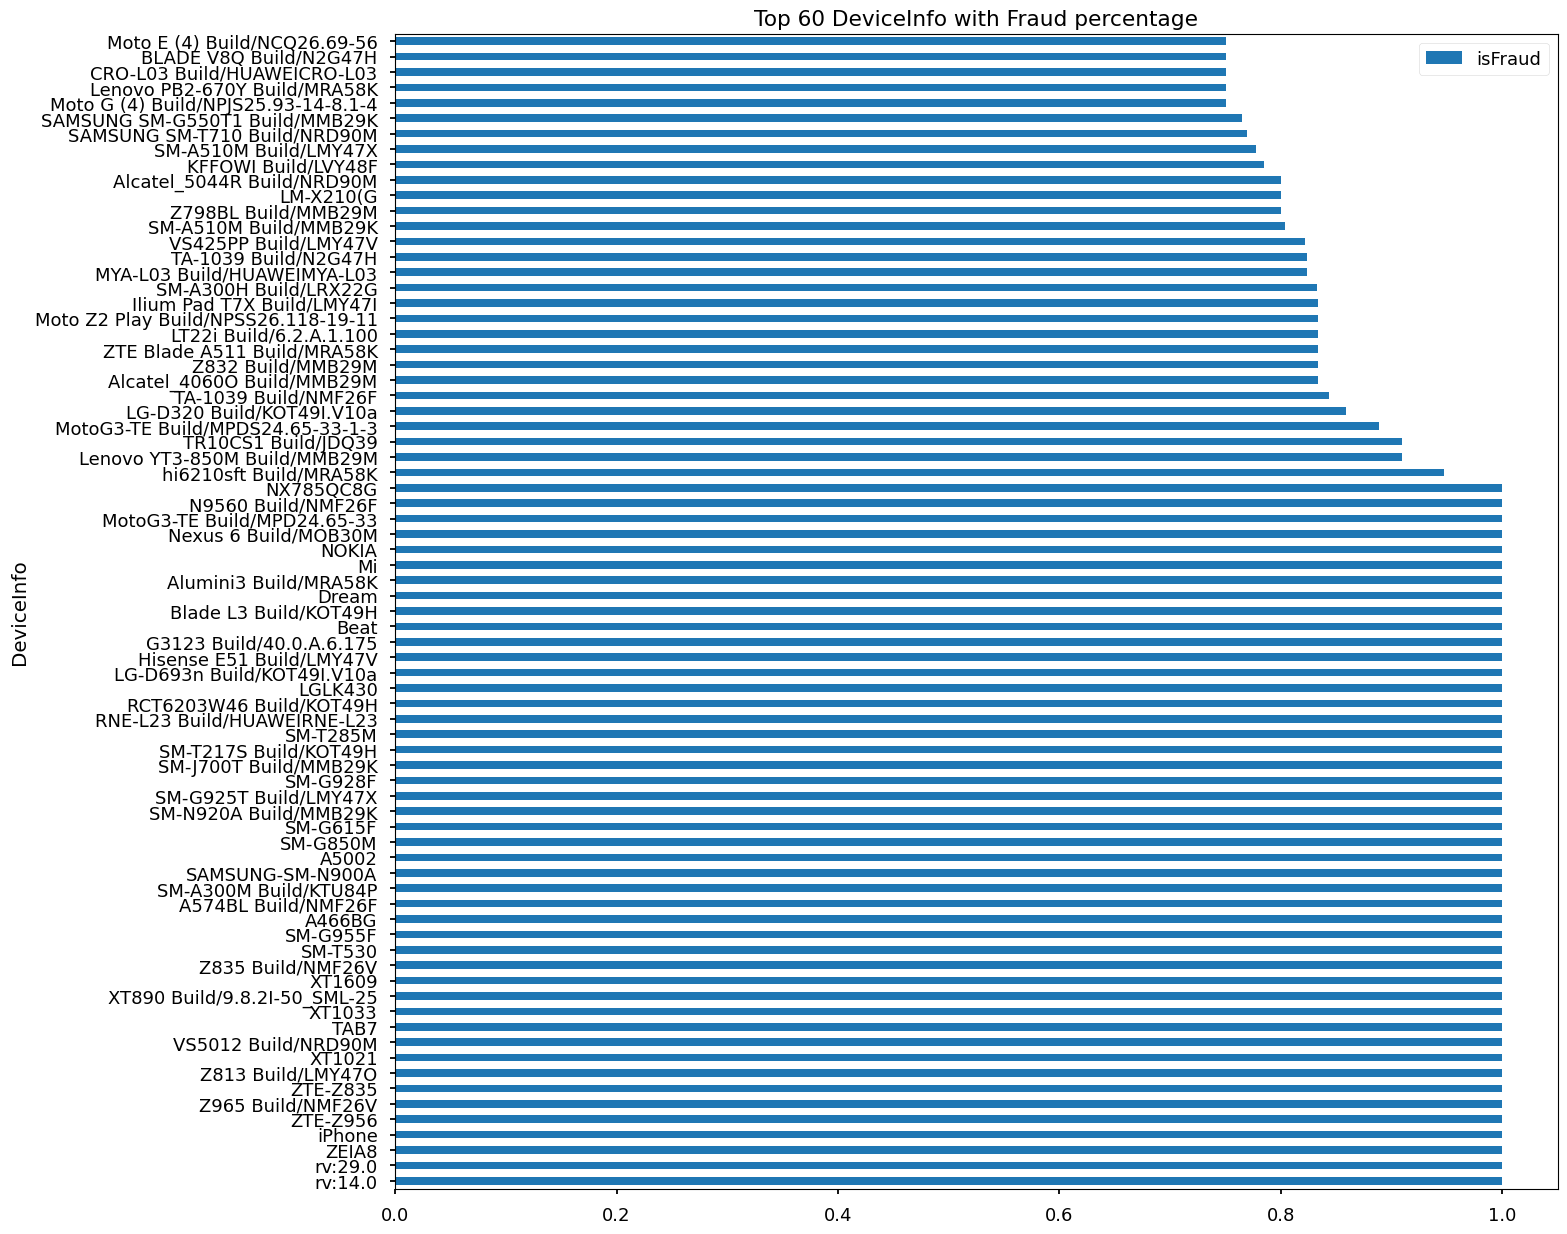

In [57]:
Device_Info.head(75).plot(kind='barh', figsize=(15, 15), title='Top 60 DeviceInfo with Fraud percentage')
plt.show()

Observation:
1. 49 device information over all devices have 90% chances of having fraud transactions.

##### ID 12 - 38
These are categorical data. It contains network connection information,browser information etc


In [58]:
cat_id_cols = ["id_" + str(i) for i in range(12, 39)]
df_train[cat_id_cols].head()

id_12  id_13  id_14 id_15     id_16  id_17  id_18  id_19  id_20  id_21  \
0       NaN    NaN    NaN   NaN       NaN    NaN    NaN    NaN    NaN    NaN   
1       NaN    NaN    NaN   NaN       NaN    NaN    NaN    NaN    NaN    NaN   
2       NaN    NaN    NaN   NaN       NaN    NaN    NaN    NaN    NaN    NaN   
3       NaN    NaN    NaN   NaN       NaN    NaN    NaN    NaN    NaN    NaN   
4  NotFound    NaN -480.0   New  NotFound  166.0    NaN  542.0  144.0    NaN   

   ...     id_29        id_30                id_31  id_32      id_33  \
0  ...       NaN          NaN                  NaN    NaN        NaN   
1  ...       NaN          NaN                  NaN    NaN        NaN   
2  ...       NaN          NaN                  NaN    NaN        NaN   
3  ...       NaN          NaN                  NaN    NaN        NaN   
4  ...  NotFound  Android 7.0  samsung browser 6.2   32.0  2220x1080   

            id_34 id_35 id_36 id_37 id_38  
0             NaN   NaN   NaN   NaN   NaN  
1             NaN   NaN   NaN   NaN   NaN  
2             NaN   NaN   NaN   NaN   NaN  
3             NaN   NaN   NaN   NaN   NaN  
4  match_status:2     T     F     T     T  

[5 rows x 27 columns]

## Baseline Model

In [59]:
df_train = df_train_transaction.merge(
    df_train_identity, on=["TransactionID"], how="left"
)
df_train.to_csv("Data/train_combined.csv", index=False)
df_train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [60]:
df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')
df_test.to_csv('Data/test_combined.csv',index=False)
df_test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  id_31  id_32  id_33  id_34 id_35  \
0  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
1  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
2  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
3  150.0        visa  166.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
4  150.0  mastercard  117.0  debit  ...    NaN    NaN    NaN    NaN   NaN   

  id_36  id_37  id_38  DeviceType  DeviceInfo  
0   NaN    NaN    NaN         NaN         NaN  
1   NaN    NaN    NaN         NaN         NaN  
2   NaN    NaN    NaN         NaN         NaN  
3   NaN    NaN    NaN         NaN         NaN  
4   NaN    NaN    NaN         NaN         NaN  

[5 rows x 433 columns]

In [61]:
# missing_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] > 0.8]
# req_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] < 0.7]
# df_train = df_train[req_cols]
# req_cols.remove('isFraud')
# df_test = df_test[req_cols]
# print(df_train.shape)
# print(df_test.shape)

### Logistic Regression

In [62]:
X_train = df_train.sort_values("TransactionDT").drop(
    ["isFraud", "TransactionDT", "TransactionID"], axis=1
)
y_train = df_train.sort_values("TransactionDT")["isFraud"]
X_test = df_test.sort_values("TransactionDT").drop(
    ["TransactionDT", "TransactionID"], axis=1
)

print(X_train.shape)
print(X_test.shape)

(590540, 431)
(506691, 431)


In [63]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

X_train = clean_inf_nan(X_train)
X_test = clean_inf_nan(X_test)

print(X_train.shape)
print(X_test.shape)

(590540, 431)
(506691, 431)


In [64]:
del df_train, df_test

In [65]:
from sklearn.model_selection import train_test_split

X_train_, X_cv_, y_train_, y_cv_ = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.3, random_state=40
)

print(X_train_.shape)
print(X_cv_.shape)
print(y_train_.shape)
print(y_cv_.shape)

(413378, 431)
(177162, 431)
(413378,)
(177162,)


In [66]:
# Numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)
print(num_cols.__len__())

# Categorical columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print(cat_cols)
print(cat_cols.__len__())

['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. Median imputation for numarical features
# 2. Standardizing

# Featurization of numeric data
imputer = SimpleImputer(strategy="median")
x_train_n = imputer.fit_transform(X_train_[num_cols])
x_cv_n = imputer.transform(X_cv_[num_cols])
x_test_n = imputer.transform(X_test[num_cols])

scaler = StandardScaler()
x_train_nums = scaler.fit_transform(x_train_n)
x_cv_nums = scaler.transform(x_cv_n)
x_test_nums = scaler.transform(x_test_n)

x_train_num_final = pd.DataFrame(x_train_nums, columns=num_cols)
x_cv_num_final = pd.DataFrame(x_cv_nums, columns=num_cols)
x_test_num_final = pd.DataFrame(x_test_nums, columns=num_cols)

print(x_train_num_final.head(5))
print(x_cv_num_final.head(5))
print(x_test_num_final.head(5))
print(x_train_num_final.shape)
print(x_cv_num_final.shape)
print(x_test_num_final.shape)

   TransactionAmt     card1     card2     card3     card5     addr1     addr2  \
0       -0.114490 -0.857204 -1.538194 -0.280834 -1.785294 -1.756986  0.069636   
1       -0.462900 -0.002910  0.755599 -0.280834 -2.003945 -0.288222  0.069636   
2       -0.076478 -1.460619  0.813104 -0.280834 -0.108972 -0.902811  0.069636   
3        0.103923  1.097567  0.583085 -0.280834  0.644159  0.399285  0.069636   
4       -0.076478  1.207186 -0.011128 -0.280834  0.644159  1.555546  0.069636   

      dist1     dist2        C1  ...     id_17     id_18     id_19     id_20  \
0 -0.217718 -0.086544 -0.074934  ... -0.311041  0.123274 -0.042060  0.202191   
1 -0.184559 -0.086544 -0.097439  ... -0.311041  0.123274  1.165874 -3.055680   
2 -0.184559 -0.086544 -0.082436  ... -0.311041  0.123274 -0.042060  0.202191   
3 -0.213574 -0.086544 -0.082436  ... -0.311041  0.123274 -0.042060  0.202191   
4 -0.184559 -0.086544 -0.089937  ... -0.311041  0.123274 -0.042060  0.202191   

      id_21     id_22     id_24 

In [68]:
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    if col in X_train.columns:

        X_train_[col] = X_train_[col].fillna("MISSING")
        X_cv_[col] = X_cv_[col].fillna("MISSING")
        X_test[col] = X_test[col].fillna("MISSING")

        lb = LabelEncoder()
        lb.fit(
            list(X_train_[col].values)
            + list(X_test[col].values)
            + list(X_cv_[col].values)
        )
        X_train_[col] = lb.transform(list(X_train_[col].values))
        X_cv_[col] = lb.transform(list(X_cv_[col].values))
        X_test[col] = lb.transform(list(X_test[col].values))

In [69]:
# Reset index to align rows
x_train_num_final = x_train_num_final.reset_index(drop=True)
x_cv_num_final = x_cv_num_final.reset_index(drop=True)
x_test_num_final = x_test_num_final.reset_index(drop=True)
X_train_ = X_train_.reset_index(drop=True)
X_cv_ = X_cv_.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Correct Merge
x_train = pd.concat([x_train_num_final, X_train_[cat_cols]], axis=1)
x_cv = pd.concat([x_cv_num_final, X_cv_[cat_cols]], axis=1)
x_test = pd.concat([x_test_num_final, X_test[cat_cols]], axis=1)

# Print the shapes
print("Training Shape:", x_train.shape)
print("Validation Shape:", x_cv.shape)
print("Testing Shape:", x_test.shape)

Training Shape: (413378, 431)
Validation Shape: (177162, 431)
Testing Shape: (506691, 431)


In [70]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train_.shape}")

x_train shape: (413378, 431)
y_train shape: (413378,)


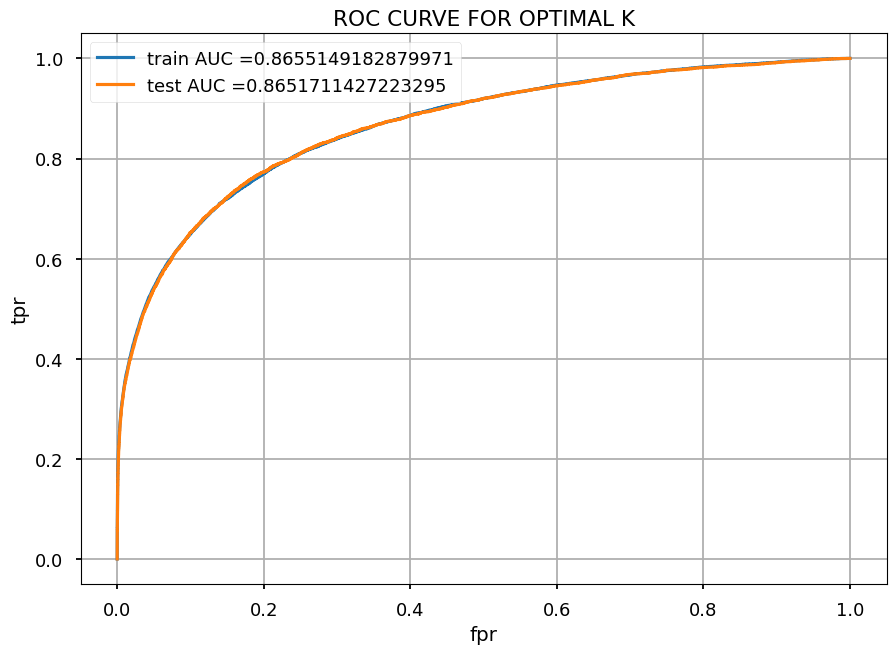

Area under train roc 0.8655149182879971
Area under test roc 0.8651711427223295


In [71]:
best_est = LogisticRegression(solver="liblinear", class_weight="balanced")
best_est = best_est.fit(x_train, y_train_)
y_pred = best_est.predict(x_cv)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train_, best_est.predict_proba(x_train)[:, 1]
)
test_fpr, test_tpr, thresholds = roc_curve(y_cv_, best_est.predict_proba(x_cv)[:, 1])
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

# Area under ROC curve
print("Area under train roc {}".format(auc(train_fpr, train_tpr)))
print("Area under test roc {}".format(auc(test_fpr, test_tpr)))

 The AUC (Area Under the ROC Curve) for both the train and test sets is 0.865, which indicates a fairly good performance of a logistic regression model. An AUC score of 0.5 would indicate a model with no discrimination ability (random guessing), while a score of 1.0 indicates perfect classification.

In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_cv_, y_pred)

array([[142480,  28483],
       [  1600,   4599]])

According to the confusion matrix, these are the results:
- True Negatives (TN): 142,480
- False Positives (FP): 28,483
- False Negatives (FN): 1,600
- True Positives (TP): 4,599

The model seems to be making a significant number of false positive predictions (28,483), meaning it's predicting fraud when it's not.
However, it is also correctly identifying a fair number of true fraud cases (4,599), which is important in fraud detection.


### Random Forest


In [73]:
df_train = pd.read_csv("data/train_combined.csv")
df_test = pd.read_csv("data/test_combined.csv")
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


In [75]:
# Numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)
print(num_cols.__len__())

# Categorical columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print(cat_cols)
print(cat_cols.__len__())

id_cols = ["TransactionID", "TransactionDT"]
target = "isFraud"

['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 

In [76]:
y_train_ = df_train["isFraud"]
X_train = df_train.drop(columns=["isFraud"])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)

(590540, 433)
(506691, 433)


In [ ]:
del df_train, df_test

In [78]:
# Scaling numeric features using Min-Max scaling
# Iterate over all columns to apply scaling only to non-categorical and non-ID columns
for col in X_train.columns:
    if col not in cat_cols and col not in id_cols:
        # Concatenate the corresponding columns from both training and test sets
        combined_data = pd.concat([X_train[col], X_test[col]])

        # Apply Min-Max scaling: (value - min) / (max - min)
        scaled_data = (combined_data - combined_data.min()) / (
            combined_data.max() - combined_data.min()
        )

        # Replace NaN values with -1 (or another appropriate value)
        scaled_data.fillna(-1, inplace=True)

        # Assign the scaled values back to X_train and X_test
        X_train[col] = scaled_data[: len(X_train)]
        X_test[col] = scaled_data[len(X_train) :]

# Clean up the temporary combined data frame
del combined_data

In [79]:
from sklearn.model_selection import train_test_split

x_train,x_cv_,y_train,y_cv = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)
idx_train = X_train.index[: int(X_train.shape[0] * 0.75)]
idx_validation = X_train.index[int(X_train.shape[0] * 0.75) :]

x_train, y_train = X_train.iloc[idx_train], y_train_.iloc[idx_train]
x_cv_, y_cv = X_train.iloc[idx_validation], y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_cv_.shape)
print(y_train.shape)
print(y_cv.shape)

(442905, 433)
(147635, 433)
(442905,)
(147635,)


In [80]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:, 1]
)
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:, 1])

# Area under ROC curve
print("Area under train roc {}".format(auc(train_fpr, train_tpr)))
print("Area under test roc {}".format(auc(test_fpr, test_tpr)))

Area under train roc 1.0
Area under test roc 0.8764128679780749


Hyper parameter tuning

In [88]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {"n_estimators": no_of_estimators, "max_depth": maximumdepth}
model = RandomizedSearchCV(
    estimator=clf, param_distributions=parameters, cv=3, n_iter=6, scoring="roc_auc"
)
model.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1),
                   n_iter=6,
                   param_distributions={'max_depth': [1, 5, 7, 10, 15, 25, 30],
                                        'n_estimators': [5, 10, 50, 100, 120]},
                   scoring='roc_auc')

In [89]:
model.best_params_

{'n_estimators': 10, 'max_depth': 7}

In [92]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=15, n_estimators=10)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_cv_)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:, 1]
)
test_fpr, test_tpr, thresholds = roc_curve(y_cv, model.predict_proba(x_cv_)[:, 1])

# Area under ROC curve
print("Area under train roc {}".format(auc(train_fpr, train_tpr)))
print("Area under test roc {}".format(auc(test_fpr, test_tpr)))

Area under train roc 0.898686701102581
Area under test roc 0.8553273967109556


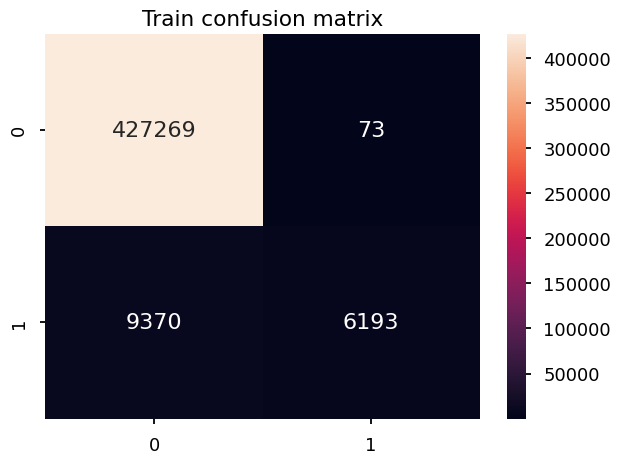

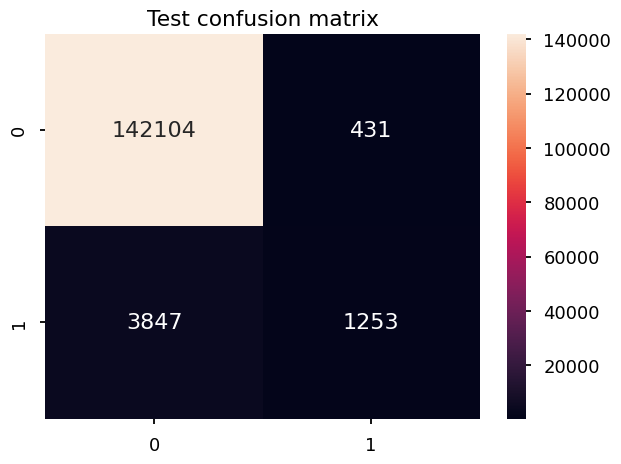

In [93]:
train_cf = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(train_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title("Train confusion matrix")
plt.show()


cv_cf = confusion_matrix(y_cv, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cv_cf, annot=True, annot_kws={"size": 16}, fmt="0")
plt.title("Test confusion matrix")
plt.show()

After Hyper parameter tuning, followed by the observation to the confusion matrix:
- Precision: 99.697% 
- Recall: 97.364% 
- F1-Score: 0.985170857511283 
